<a href="https://colab.research.google.com/github/UsfHajaj/Deep-Learning-Project/blob/main/finalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
from sklearn.metrics import confusion_matrix
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
np_config.enable_numpy_behavior()
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d datamunge/sign-language-mnist



 85% 53.0M/62.6M [00:00<00:00, 138MB/s]
100% 62.6M/62.6M [00:00<00:00, 114MB/s]


In [8]:
!unzip /content/sign-language-mnist.zip

Archive:  /content/sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [9]:
file_path = '/content/sign_mnist_train/sign_mnist_train.csv'

df = pd.read_csv(file_path)

In [10]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [11]:
df.label.sort_values().value_counts(sort = False)

0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: label, dtype: int64

In [12]:
gdf=df.iloc[:2000]

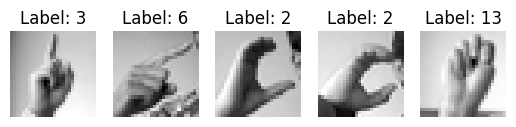

In [13]:
pixels = gdf.iloc[:, 1:].values
labels = gdf['label'].values

images = pixels.reshape(-1, 28, 28)

num_images_to_plot = 5

for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.show()

In [14]:
EPOCHS = 400
BATCH_SIZE = 64
noise_dim = 100

In [15]:

images=images.reshape(images.shape[0],28,28,1).astype('float32')
images=(images-127.5)/127.5

In [16]:
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [17]:
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [18]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [19]:
generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = keras.optimizers.legacy.Adam(1e-4)

In [20]:
def train_step(images):
    # Generating noise from a normal distribution
    fake_img_noise = tf.random.normal([BATCH_SIZE, noise_dim])
    samples_test = np.random.normal(0,1,(16, 100))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(fake_img_noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        print("gen_loss" , np.mean(gen_loss))
        print("disc_loss" , np.mean(disc_loss))
        #results = generator.predict([samples_test])
        #plot_image(results,4, 4)
        #print("gen_loss" , gen_loss)

In [21]:
def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
        for batch in dataset:
            train_step(batch)

In [ ]:
train(dataset, EPOCHS)

  0%|          | 0/400 [00:00<?, ?it/s]

gen_loss tf.Tensor(0.6643399, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4063989, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66440296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.380761, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66733134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3650551, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6676282, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3296633, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6706245, shape=(), dtype=float32)
disc_loss tf.Tensor(1.323385, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6696504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3165522, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67935693, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2947485, shape=(), dtype=float32)
gen_loss tf.Tensor(0.690928, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2620366, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68996465, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2397882, shape=(), dtype=float32)


  0%|          | 1/400 [00:09<1:04:10,  9.65s/it]

gen_loss tf.Tensor(0.5354233, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3049906, shape=(), dtype=float32)
gen_loss tf.Tensor(0.54072386, shape=(), dtype=float32)
disc_loss tf.Tensor(1.284562, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5353633, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3544753, shape=(), dtype=float32)
gen_loss tf.Tensor(0.55067, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2974387, shape=(), dtype=float32)
gen_loss tf.Tensor(0.56434965, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2801746, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5626327, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2472943, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57630515, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2734896, shape=(), dtype=float32)
gen_loss tf.Tensor(0.59533256, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2287915, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6020206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2718489, shape=(), dtype=float32)


  0%|          | 2/400 [00:12<36:57,  5.57s/it]  

gen_loss tf.Tensor(0.79824376, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1417804, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7943193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1243966, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77907515, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1999569, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77032495, shape=(), dtype=float32)
disc_loss tf.Tensor(1.155821, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7951171, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1237231, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83073366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0880964, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88173276, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0679017, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91444886, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0156729, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9667804, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0015788, shape=(), dtype=float

  1%|          | 3/400 [00:15<28:17,  4.28s/it]

gen_loss tf.Tensor(0.7766675, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1971779, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7373924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2390101, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7395235, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2672908, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72551584, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2795134, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7266296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2711462, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7528821, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2662852, shape=(), dtype=float32)
gen_loss tf.Tensor(0.781071, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2370324, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7995439, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2672825, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85177237, shape=(), dtype=float32)
disc_loss tf.Tensor(1.221559, shape=(), dtype=float32)
g

  1%|          | 4/400 [00:20<30:22,  4.60s/it]

gen_loss tf.Tensor(1.0116864, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0933619, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0682874, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0255718, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1012077, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93846977, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1359637, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99226046, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2116375, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9264996, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2658336, shape=(), dtype=float32)
disc_loss tf.Tensor(0.87977356, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2786016, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90753806, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3355187, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8413559, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3681679, shape=(), dtype=float32)
disc_loss tf.Tensor(0.81088555, shape=(), dtype=float

  1%|▏         | 5/400 [00:22<26:00,  3.95s/it]

gen_loss tf.Tensor(1.3294578, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8368847, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4048369, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7266314, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4506011, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8303219, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4631402, shape=(), dtype=float32)
disc_loss tf.Tensor(0.80270946, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5032938, shape=(), dtype=float32)
disc_loss tf.Tensor(0.82348436, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5109437, shape=(), dtype=float32)
disc_loss tf.Tensor(0.84708846, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4670756, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7995032, shape=(), dtype=float32)
gen_loss tf.Tensor(1.422873, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8962091, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4288437, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8121203, shape=(), dtype=float32)

  2%|▏         | 6/400 [00:25<23:31,  3.58s/it]

gen_loss tf.Tensor(1.4897487, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8769554, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5207422, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8785366, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4549857, shape=(), dtype=float32)
disc_loss tf.Tensor(0.78489935, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4156682, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9060876, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3588805, shape=(), dtype=float32)
disc_loss tf.Tensor(0.85646373, shape=(), dtype=float32)
gen_loss tf.Tensor(1.295974, shape=(), dtype=float32)
disc_loss tf.Tensor(0.86070824, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1398658, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88263845, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9820446, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96123934, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9068903, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0178307, shape=(), dtype=float3

  2%|▏         | 7/400 [00:28<21:52,  3.34s/it]

gen_loss tf.Tensor(1.5639277, shape=(), dtype=float32)
disc_loss tf.Tensor(0.6602373, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5690393, shape=(), dtype=float32)
disc_loss tf.Tensor(0.6362945, shape=(), dtype=float32)
gen_loss tf.Tensor(1.656801, shape=(), dtype=float32)
disc_loss tf.Tensor(0.6465874, shape=(), dtype=float32)
gen_loss tf.Tensor(1.666117, shape=(), dtype=float32)
disc_loss tf.Tensor(0.5667814, shape=(), dtype=float32)
gen_loss tf.Tensor(1.6706939, shape=(), dtype=float32)
disc_loss tf.Tensor(0.559909, shape=(), dtype=float32)
gen_loss tf.Tensor(1.6655276, shape=(), dtype=float32)
disc_loss tf.Tensor(0.5528172, shape=(), dtype=float32)
gen_loss tf.Tensor(1.7647378, shape=(), dtype=float32)
disc_loss tf.Tensor(0.54282427, shape=(), dtype=float32)
gen_loss tf.Tensor(1.7760063, shape=(), dtype=float32)
disc_loss tf.Tensor(0.51252717, shape=(), dtype=float32)
gen_loss tf.Tensor(1.8258266, shape=(), dtype=float32)
disc_loss tf.Tensor(0.48403093, shape=(), dtype=float32)
g

  2%|▏         | 8/400 [00:33<25:28,  3.90s/it]

gen_loss tf.Tensor(1.4392729, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7838783, shape=(), dtype=float32)
gen_loss tf.Tensor(1.253437, shape=(), dtype=float32)
disc_loss tf.Tensor(0.77729166, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1881573, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92807734, shape=(), dtype=float32)
gen_loss tf.Tensor(1.261184, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9658007, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2068411, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9631113, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2991875, shape=(), dtype=float32)
disc_loss tf.Tensor(1.000978, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2644895, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1973387, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2649556, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1449376, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0867193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1793575, shape=(), dtype=float32)
ge

  2%|▏         | 9/400 [00:38<27:52,  4.28s/it]

gen_loss tf.Tensor(0.973669, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2185292, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0122827, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1478717, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0873239, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0757455, shape=(), dtype=float32)
gen_loss tf.Tensor(1.131726, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9726074, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2736752, shape=(), dtype=float32)
disc_loss tf.Tensor(1.016371, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2445116, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0936174, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2357571, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0155952, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2099775, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9217229, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1726674, shape=(), dtype=float32)
disc_loss tf.Tensor(0.89359015, shape=(), dtype=float32)
gen

  2%|▎         | 10/400 [00:41<24:53,  3.83s/it]

gen_loss tf.Tensor(1.477084, shape=(), dtype=float32)
disc_loss tf.Tensor(0.75304264, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5274205, shape=(), dtype=float32)
disc_loss tf.Tensor(0.6719295, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5496857, shape=(), dtype=float32)
disc_loss tf.Tensor(0.68124557, shape=(), dtype=float32)
gen_loss tf.Tensor(1.6599112, shape=(), dtype=float32)
disc_loss tf.Tensor(0.6698923, shape=(), dtype=float32)
gen_loss tf.Tensor(1.809407, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8522413, shape=(), dtype=float32)
gen_loss tf.Tensor(1.7661211, shape=(), dtype=float32)
disc_loss tf.Tensor(0.6970645, shape=(), dtype=float32)
gen_loss tf.Tensor(1.7331872, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8399288, shape=(), dtype=float32)
gen_loss tf.Tensor(1.6749719, shape=(), dtype=float32)
disc_loss tf.Tensor(0.68723506, shape=(), dtype=float32)
gen_loss tf.Tensor(1.6819391, shape=(), dtype=float32)
disc_loss tf.Tensor(0.66639346, shape=(), dtype=float32)

  3%|▎         | 11/400 [00:44<23:35,  3.64s/it]

gen_loss tf.Tensor(1.0477109, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9594113, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1218104, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0705944, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0563842, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0505769, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0615839, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0256449, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1113689, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97127175, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0922003, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0327646, shape=(), dtype=float32)
gen_loss tf.Tensor(1.168652, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88533163, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1464584, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92877614, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2587675, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94466454, shape=(), dtype=float32

  3%|▎         | 12/400 [00:49<24:34,  3.80s/it]

gen_loss tf.Tensor(0.55917436, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6055322, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5601826, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7647436, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5262027, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7046715, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5424643, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6649513, shape=(), dtype=float32)
gen_loss tf.Tensor(0.54889464, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7860544, shape=(), dtype=float32)
gen_loss tf.Tensor(0.58582646, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7184293, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57173884, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7756463, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57338536, shape=(), dtype=float32)
disc_loss tf.Tensor(1.618887, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5954411, shape=(), dtype=float32)
disc_loss tf.Tensor(1.513728, shape=(), dtype=float32

  3%|▎         | 13/400 [00:51<22:29,  3.49s/it]

gen_loss tf.Tensor(0.5849722, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6466248, shape=(), dtype=float32)
gen_loss tf.Tensor(0.58531153, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5539913, shape=(), dtype=float32)
gen_loss tf.Tensor(0.56162703, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6604059, shape=(), dtype=float32)
gen_loss tf.Tensor(0.56320447, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6604435, shape=(), dtype=float32)
gen_loss tf.Tensor(0.54767674, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6165297, shape=(), dtype=float32)
gen_loss tf.Tensor(0.52914745, shape=(), dtype=float32)
disc_loss tf.Tensor(1.621043, shape=(), dtype=float32)
gen_loss tf.Tensor(0.51942074, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6159384, shape=(), dtype=float32)
gen_loss tf.Tensor(0.513852, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5136902, shape=(), dtype=float32)
gen_loss tf.Tensor(0.4979792, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6346077, shape=(), dtype=float3

  4%|▎         | 14/400 [00:54<21:02,  3.27s/it]

gen_loss tf.Tensor(0.6129878, shape=(), dtype=float32)
disc_loss tf.Tensor(1.378312, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6168921, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3841214, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5854884, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3827994, shape=(), dtype=float32)
gen_loss tf.Tensor(0.59285283, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4753747, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57231873, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5508702, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5741787, shape=(), dtype=float32)
disc_loss tf.Tensor(1.488333, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5786115, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4850371, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5439718, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4770858, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5068739, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5123199, shape=(), dtype=float32)
g

  4%|▍         | 15/400 [00:59<24:31,  3.82s/it]

gen_loss tf.Tensor(0.69008726, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2475164, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69380647, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2866633, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6725352, shape=(), dtype=float32)
disc_loss tf.Tensor(1.223195, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6802691, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1931049, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6860563, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2422082, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68348616, shape=(), dtype=float32)
disc_loss tf.Tensor(1.315033, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6873696, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1625764, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6665261, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2096591, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63195765, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2785732, shape=(), dtype=float32)

  4%|▍         | 16/400 [01:03<23:21,  3.65s/it]

gen_loss tf.Tensor(0.5875602, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3905672, shape=(), dtype=float32)
gen_loss tf.Tensor(0.62558067, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3751855, shape=(), dtype=float32)
gen_loss tf.Tensor(0.62332916, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3917823, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6608442, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2956018, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6284943, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4127481, shape=(), dtype=float32)
gen_loss tf.Tensor(0.64729214, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2949032, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6402058, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3059002, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65819645, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3457416, shape=(), dtype=float32)
gen_loss tf.Tensor(0.650594, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2677453, shape=(), dtype=float32

  4%|▍         | 17/400 [01:05<21:41,  3.40s/it]

gen_loss tf.Tensor(0.6696047, shape=(), dtype=float32)
disc_loss tf.Tensor(1.558172, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66890705, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4311998, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6685981, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3834114, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66212636, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4225721, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6671821, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4571242, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66393924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4336677, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67449087, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4981184, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6766903, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5731508, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67674565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4017689, shape=(), dtype=float3

  4%|▍         | 18/400 [01:08<20:28,  3.22s/it]

gen_loss tf.Tensor(0.9184802, shape=(), dtype=float32)
disc_loss tf.Tensor(1.176536, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90682113, shape=(), dtype=float32)
disc_loss tf.Tensor(1.166785, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9003285, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2842916, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87328386, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1837687, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8227074, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2101735, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8212789, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2667935, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82682043, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2457297, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7963284, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2198077, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80161005, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2809744, shape=(), dtype=float32)

  5%|▍         | 19/400 [01:13<24:01,  3.78s/it]

gen_loss tf.Tensor(0.8489615, shape=(), dtype=float32)
disc_loss tf.Tensor(1.362144, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8727806, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4884903, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8655012, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4833047, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8954885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.40257, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8921747, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4983212, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8740579, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4097403, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8859818, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4598477, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8704268, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4821894, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86277294, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3761473, shape=(), dtype=float32)
gen

  5%|▌         | 20/400 [01:16<22:24,  3.54s/it]

gen_loss tf.Tensor(1.1638914, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1157382, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1726198, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0283833, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1602952, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1110437, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1774571, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0408883, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1353045, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1054304, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1213738, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0151167, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1712725, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99536896, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1037866, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0519124, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1178689, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9665319, shape=(), dtype=float32)


  5%|▌         | 21/400 [01:19<21:04,  3.34s/it]

gen_loss tf.Tensor(1.1555443, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2085881, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1527859, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2765765, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0953968, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1985813, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0610749, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1289682, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0262526, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2129364, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0426533, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2125785, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99794775, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2826326, shape=(), dtype=float32)
gen_loss tf.Tensor(0.986763, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1988324, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94878936, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3555719, shape=(), dtype=float32)


  6%|▌         | 22/400 [01:23<21:48,  3.46s/it]

gen_loss tf.Tensor(0.7199906, shape=(), dtype=float32)
disc_loss tf.Tensor(1.170933, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71080005, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2047435, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73965603, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0909274, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7245276, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0656956, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78870386, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0644084, shape=(), dtype=float32)
gen_loss tf.Tensor(0.789631, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0714291, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83904886, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9606201, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7927525, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0219513, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8512535, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94714373, shape=(), dtype=float32

  6%|▌         | 23/400 [01:28<24:51,  3.96s/it]

gen_loss tf.Tensor(1.1807128, shape=(), dtype=float32)
disc_loss tf.Tensor(0.74881494, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0868092, shape=(), dtype=float32)
disc_loss tf.Tensor(0.81560946, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1721461, shape=(), dtype=float32)
disc_loss tf.Tensor(0.79915404, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9986577, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9402628, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9910481, shape=(), dtype=float32)
disc_loss tf.Tensor(1.053698, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0242524, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97154737, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0657804, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9203678, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9768302, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97828996, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96121573, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0684488, shape=(), dtype=float

  6%|▌         | 24/400 [01:31<24:04,  3.84s/it]

gen_loss tf.Tensor(0.739111, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5003058, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7372978, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5148087, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7066035, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5291473, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7433998, shape=(), dtype=float32)
disc_loss tf.Tensor(1.46258, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73287284, shape=(), dtype=float32)
disc_loss tf.Tensor(1.522293, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7478726, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5378358, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6995285, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4511206, shape=(), dtype=float32)
gen_loss tf.Tensor(0.734159, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5078993, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7064309, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6382971, shape=(), dtype=float32)
gen_l

  6%|▋         | 25/400 [01:34<21:56,  3.51s/it]

gen_loss tf.Tensor(0.7002257, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6581309, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73303497, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5306115, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72439146, shape=(), dtype=float32)
disc_loss tf.Tensor(1.810174, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7158273, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6410936, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71513367, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5268662, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7395811, shape=(), dtype=float32)
disc_loss tf.Tensor(1.713362, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75377965, shape=(), dtype=float32)
disc_loss tf.Tensor(1.491317, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7725941, shape=(), dtype=float32)
disc_loss tf.Tensor(1.514466, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75116116, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6865919, shape=(), dtype=float32)


  6%|▋         | 26/400 [01:37<20:35,  3.30s/it]

gen_loss tf.Tensor(0.79424465, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5664113, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79196453, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4756353, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79401684, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4908919, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8000493, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4261858, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79736036, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4456925, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82240963, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4311357, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8383169, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3934641, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83667624, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4136233, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8298951, shape=(), dtype=float32)
disc_loss tf.Tensor(1.327931, shape=(), dtype=float

  7%|▋         | 27/400 [01:41<20:58,  3.38s/it]

gen_loss tf.Tensor(0.8621841, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3110796, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82610106, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2730563, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83624625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2555208, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8300369, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3047894, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84954894, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2123886, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8484672, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1789234, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8240551, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2150229, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8576961, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1847384, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8421273, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1975859, shape=(), dtype=float32

  7%|▋         | 28/400 [01:44<20:32,  3.31s/it]

gen_loss tf.Tensor(0.8371098, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0925038, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8142713, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0679939, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8546537, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0773199, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88195807, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1071697, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8203919, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1042812, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8631943, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0978531, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8558236, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0800716, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8529831, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1205161, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9300542, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0973607, shape=(), dtype=float32)


  7%|▋         | 29/400 [01:47<19:42,  3.19s/it]

gen_loss tf.Tensor(0.77487016, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0824437, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7949284, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0735652, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7823154, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0788589, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7836026, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0541445, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7834742, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0487541, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7734399, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0900229, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8469647, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0483533, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81148005, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0341992, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81977916, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0707518, shape=(), dtype=float32

  8%|▊         | 30/400 [01:50<19:02,  3.09s/it]

gen_loss tf.Tensor(0.82787365, shape=(), dtype=float32)
disc_loss tf.Tensor(1.102997, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82682157, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0449145, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8285336, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0279722, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82147515, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0656844, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8320544, shape=(), dtype=float32)
disc_loss tf.Tensor(1.025865, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85640097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0002403, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85404396, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0500144, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86364365, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99966645, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8455533, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0450184, shape=(), dtype=float

  8%|▊         | 31/400 [01:55<22:42,  3.69s/it]

gen_loss tf.Tensor(0.9747999, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0644549, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8981739, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0896497, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9199401, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0658537, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9143056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0631728, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86959964, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0492704, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8819784, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0892673, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88324016, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0669348, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9053674, shape=(), dtype=float32)
disc_loss tf.Tensor(1.022636, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85529137, shape=(), dtype=float32)
disc_loss tf.Tensor(1.030734, shape=(), dtype=float32)


  8%|▊         | 32/400 [01:58<21:15,  3.47s/it]

gen_loss tf.Tensor(0.8429084, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3291736, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7968019, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3009651, shape=(), dtype=float32)
gen_loss tf.Tensor(0.824814, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4045095, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87291694, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2347988, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7805444, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2832377, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7436477, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3727471, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72835827, shape=(), dtype=float32)
disc_loss tf.Tensor(1.457674, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7035787, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4440391, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71018827, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3434777, shape=(), dtype=float32)


  8%|▊         | 33/400 [02:00<20:07,  3.29s/it]

gen_loss tf.Tensor(0.9105967, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4982396, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9041007, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4225135, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9287906, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4043052, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9779007, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3607605, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9807967, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3801014, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9510949, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3657898, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9446002, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3248031, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92145574, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4132504, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9878137, shape=(), dtype=float32)
disc_loss tf.Tensor(1.248024, shape=(), dtype=float32)
g

  8%|▊         | 34/400 [02:03<19:11,  3.15s/it]

gen_loss tf.Tensor(0.88621426, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4355352, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9026248, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5137489, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8697967, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4953324, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8974274, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4487187, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87840056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4915113, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8706912, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5250673, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93628514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4478292, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8713295, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5465145, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8955785, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5257726, shape=(), dtype=float32

  9%|▉         | 35/400 [02:08<22:42,  3.73s/it]

gen_loss tf.Tensor(0.80744827, shape=(), dtype=float32)
disc_loss tf.Tensor(1.615967, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81545734, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6412799, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8432064, shape=(), dtype=float32)
disc_loss tf.Tensor(1.591063, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84751076, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5655837, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80852413, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5330025, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8236615, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6751207, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8067949, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4792004, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8352448, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5745475, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8193447, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6120894, shape=(), dtype=float32)

  9%|▉         | 36/400 [02:11<21:02,  3.47s/it]

gen_loss tf.Tensor(0.94351184, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1499242, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93885905, shape=(), dtype=float32)
disc_loss tf.Tensor(1.213558, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9719822, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1736238, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9670433, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1137804, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9566048, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1296011, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99050266, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1177897, shape=(), dtype=float32)
gen_loss tf.Tensor(0.952518, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1550813, shape=(), dtype=float32)
gen_loss tf.Tensor(0.987898, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0880169, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9798366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0965278, shape=(), dtype=float32)
g

  9%|▉         | 37/400 [02:14<19:46,  3.27s/it]

gen_loss tf.Tensor(0.8675891, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2227011, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91044164, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1760551, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8726406, shape=(), dtype=float32)
disc_loss tf.Tensor(1.281973, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88304687, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2503033, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8295912, shape=(), dtype=float32)
disc_loss tf.Tensor(1.262506, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8290108, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3484658, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8385172, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3148766, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8900366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3119819, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8153299, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3733914, shape=(), dtype=float32)
g

 10%|▉         | 38/400 [02:17<18:50,  3.12s/it]

gen_loss tf.Tensor(0.62734497, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4225149, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6065737, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4494684, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6389372, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4628823, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6897035, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3453834, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70939815, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3942466, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7136409, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4213325, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7765691, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2677462, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74427915, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3358264, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75313354, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2921386, shape=(), dtype=float3

 10%|▉         | 39/400 [02:22<22:22,  3.72s/it]

gen_loss tf.Tensor(0.68106365, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3081445, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66527396, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3680415, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69901735, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3394465, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6538069, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3712451, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67706704, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3604894, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6456237, shape=(), dtype=float32)
disc_loss tf.Tensor(1.457134, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6510582, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4223782, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6782605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3192549, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6518233, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4342737, shape=(), dtype=float32

 10%|█         | 40/400 [02:25<20:39,  3.44s/it]

gen_loss tf.Tensor(0.69919384, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3424116, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7349576, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4110692, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73091376, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4312308, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7500305, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3187995, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74041015, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3413029, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7485021, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3098834, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7952328, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3682392, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7998891, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3299949, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8092531, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3312056, shape=(), dtype=float32

 10%|█         | 41/400 [02:28<19:29,  3.26s/it]

gen_loss tf.Tensor(0.7739589, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3152272, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7622485, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2693332, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76554924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2613587, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73360527, shape=(), dtype=float32)
disc_loss tf.Tensor(1.284559, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7492717, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2886298, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7428108, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3027958, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75212777, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2715013, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7380222, shape=(), dtype=float32)
disc_loss tf.Tensor(1.251689, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7419003, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2966468, shape=(), dtype=float32)


 10%|█         | 42/400 [02:30<18:36,  3.12s/it]

gen_loss tf.Tensor(0.6470816, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4728096, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6540793, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5131438, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65898, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3890027, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6609801, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4483128, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69208133, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4084777, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6877477, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4070301, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7245667, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3645853, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73621917, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3752851, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7500466, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3192834, shape=(), dtype=float32)
g

 11%|█         | 43/400 [02:34<18:52,  3.17s/it]

gen_loss tf.Tensor(0.68590504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2399809, shape=(), dtype=float32)
gen_loss tf.Tensor(0.682217, shape=(), dtype=float32)
disc_loss tf.Tensor(1.271681, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68729895, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3361572, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66152966, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2991849, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6547815, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3587654, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6351214, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3180366, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6351057, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3949683, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6439729, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3659171, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6360756, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3220798, shape=(), dtype=float32)


 11%|█         | 44/400 [02:37<19:14,  3.24s/it]

gen_loss tf.Tensor(0.85169834, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1696378, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8457123, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2366841, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8849994, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1694307, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89241296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0865299, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8675896, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1145475, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88896453, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1156597, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8825402, shape=(), dtype=float32)
disc_loss tf.Tensor(1.083802, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8813101, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1557908, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91471297, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1754842, shape=(), dtype=float32

 11%|█▏        | 45/400 [02:40<18:25,  3.11s/it]

gen_loss tf.Tensor(0.94323605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1681285, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89238364, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1411593, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88894624, shape=(), dtype=float32)
disc_loss tf.Tensor(1.188688, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8977171, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3086767, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8576307, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1968241, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7982478, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2556548, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7841047, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3609619, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81045693, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3685145, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7928116, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4388444, shape=(), dtype=float32

 12%|█▏        | 46/400 [02:43<17:51,  3.03s/it]

gen_loss tf.Tensor(0.6666611, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7110693, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6500899, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6064665, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6397132, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6158667, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6399251, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6566663, shape=(), dtype=float32)
gen_loss tf.Tensor(0.630125, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6838295, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6669193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6522417, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6979298, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6066363, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70238227, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6452308, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7174407, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6648616, shape=(), dtype=float32)
g

 12%|█▏        | 47/400 [02:45<17:28,  2.97s/it]

gen_loss tf.Tensor(0.70820975, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3343198, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6959609, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4233568, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72291493, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2899001, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72634935, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4275777, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7189615, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4347949, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72469497, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3916427, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70538807, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3814163, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70549476, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4528769, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7241239, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4375782, shape=(), dtype=floa

 12%|█▏        | 48/400 [02:51<21:10,  3.61s/it]

gen_loss tf.Tensor(0.84162545, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2818216, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8182693, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2599155, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8220841, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2636346, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84261495, shape=(), dtype=float32)
disc_loss tf.Tensor(1.215123, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82276726, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2401457, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80922455, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2561591, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8151139, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2830819, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8091043, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2696896, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8083282, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2693435, shape=(), dtype=float32

 12%|█▏        | 49/400 [02:53<19:42,  3.37s/it]

gen_loss tf.Tensor(0.73583156, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2058632, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8075741, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2207158, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77037406, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2574303, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7912634, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1585056, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80452454, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2486637, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84332865, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1527007, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8531412, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1718655, shape=(), dtype=float32)
gen_loss tf.Tensor(0.919601, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0489612, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88760114, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0170548, shape=(), dtype=float3

 12%|█▎        | 50/400 [02:56<18:44,  3.21s/it]

gen_loss tf.Tensor(0.8103589, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1478448, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8125136, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3643792, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80447924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2384086, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81401414, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3461578, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7990679, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3599942, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7607671, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3827374, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76474494, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3659661, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67226017, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6823914, shape=(), dtype=float32)
gen_loss tf.Tensor(0.700649, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5692874, shape=(), dtype=float32

 13%|█▎        | 51/400 [02:59<17:59,  3.09s/it]

gen_loss tf.Tensor(0.5910504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7224616, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6340971, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5996063, shape=(), dtype=float32)
gen_loss tf.Tensor(0.64983916, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7193439, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6680826, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7383696, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68820775, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7109078, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7221101, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6720918, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73503554, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6428576, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7471031, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7074233, shape=(), dtype=float32)
gen_loss tf.Tensor(0.751091, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5541723, shape=(), dtype=float32)

 13%|█▎        | 52/400 [03:04<21:27,  3.70s/it]

gen_loss tf.Tensor(1.0115389, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2824211, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9940373, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2335892, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0175049, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2957188, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0753602, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2436045, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0387828, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2201903, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0748385, shape=(), dtype=float32)
disc_loss tf.Tensor(1.12613, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0850682, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1341403, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0721183, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1692104, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0573913, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1561172, shape=(), dtype=float32)
gen

 13%|█▎        | 53/400 [03:07<20:00,  3.46s/it]

gen_loss tf.Tensor(0.7699119, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4499146, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67826337, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5589292, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68157446, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5486171, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6507787, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5026321, shape=(), dtype=float32)
gen_loss tf.Tensor(0.625583, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6657004, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6204641, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6116083, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63242257, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7220192, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65046746, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6521573, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6616889, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4841094, shape=(), dtype=float32

 14%|█▎        | 54/400 [03:10<18:51,  3.27s/it]

gen_loss tf.Tensor(0.69297147, shape=(), dtype=float32)
disc_loss tf.Tensor(1.35357, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6765208, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4081277, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69012487, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3842349, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6121687, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4519737, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5903739, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4916856, shape=(), dtype=float32)
gen_loss tf.Tensor(0.62276816, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4770656, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5695536, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5288069, shape=(), dtype=float32)
gen_loss tf.Tensor(0.60484517, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5099152, shape=(), dtype=float32)
gen_loss tf.Tensor(0.61773354, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4561726, shape=(), dtype=float32

 14%|█▍        | 55/400 [03:13<18:06,  3.15s/it]

gen_loss tf.Tensor(0.9882854, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0732687, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9108065, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1600664, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91911775, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0960876, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82819563, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1961379, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81557846, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1789982, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8328569, shape=(), dtype=float32)
disc_loss tf.Tensor(1.148561, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81484604, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1528599, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8082977, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1944678, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73480815, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2272015, shape=(), dtype=float3

 14%|█▍        | 56/400 [03:16<18:33,  3.24s/it]

gen_loss tf.Tensor(0.623029, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4422805, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6189704, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3580203, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6149527, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3010671, shape=(), dtype=float32)
gen_loss tf.Tensor(0.62181056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3268253, shape=(), dtype=float32)
gen_loss tf.Tensor(0.639042, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3032949, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6482462, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2968857, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6606811, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2967236, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6848918, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2559803, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67897123, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2591143, shape=(), dtype=float32)
g

 14%|█▍        | 57/400 [03:20<18:44,  3.28s/it]

gen_loss tf.Tensor(0.8087568, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0603887, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78722835, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0449922, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7442922, shape=(), dtype=float32)
disc_loss tf.Tensor(1.08967, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75855005, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0596606, shape=(), dtype=float32)
gen_loss tf.Tensor(0.755126, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0302118, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7570226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0854733, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7957837, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0435013, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7913782, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0495737, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80347264, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0684094, shape=(), dtype=float32)
g

 14%|█▍        | 58/400 [03:22<17:57,  3.15s/it]

gen_loss tf.Tensor(0.8264433, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1545255, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78890723, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1869512, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8242321, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1041622, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76923764, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1697675, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72369134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2472498, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68571377, shape=(), dtype=float32)
disc_loss tf.Tensor(1.444173, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7619885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3182074, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73275435, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2794874, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7080841, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3950764, shape=(), dtype=float3

 15%|█▍        | 59/400 [03:26<18:44,  3.30s/it]

gen_loss tf.Tensor(0.70934993, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4251492, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7719832, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4024739, shape=(), dtype=float32)
gen_loss tf.Tensor(0.703663, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4653981, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7057741, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4426678, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7081534, shape=(), dtype=float32)
disc_loss tf.Tensor(1.439528, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63239, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5027437, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72189665, shape=(), dtype=float32)
disc_loss tf.Tensor(1.514729, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78164196, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4409099, shape=(), dtype=float32)
gen_loss tf.Tensor(0.64601207, shape=(), dtype=float32)
disc_loss tf.Tensor(1.590118, shape=(), dtype=float32)
gen

 15%|█▌        | 60/400 [03:31<21:45,  3.84s/it]

gen_loss tf.Tensor(0.81130975, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3978672, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81420046, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3658112, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8504535, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3912904, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8240017, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3860925, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85585093, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3820267, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8354757, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3323486, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8766146, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2613447, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87291116, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3662986, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8608377, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3477874, shape=(), dtype=float3

 15%|█▌        | 61/400 [03:34<20:06,  3.56s/it]

gen_loss tf.Tensor(0.78494924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3674489, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79526514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3312753, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7669023, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3613819, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7971244, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3996851, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7936394, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3959177, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7918238, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3889475, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8001631, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3476844, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8266818, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3557494, shape=(), dtype=float32)
gen_loss tf.Tensor(0.813311, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5003977, shape=(), dtype=float32)


 16%|█▌        | 62/400 [03:37<18:52,  3.35s/it]

gen_loss tf.Tensor(0.7692926, shape=(), dtype=float32)
disc_loss tf.Tensor(1.363913, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7342448, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4076935, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7647205, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3304696, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74246573, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3649381, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76742524, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3773134, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7762025, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3747313, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76101494, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3758192, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7866874, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3508887, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80163354, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3097945, shape=(), dtype=float32

 16%|█▌        | 63/400 [03:40<18:04,  3.22s/it]

gen_loss tf.Tensor(0.7697403, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2314453, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7821833, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2916405, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7442273, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3026634, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7692926, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2742229, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7579049, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2937669, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7764516, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2557713, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75723577, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2977219, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71506846, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3260369, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73737615, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3175457, shape=(), dtype=float32

 16%|█▌        | 64/400 [03:43<18:03,  3.22s/it]

gen_loss tf.Tensor(0.6466373, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3560791, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6407765, shape=(), dtype=float32)
disc_loss tf.Tensor(1.359659, shape=(), dtype=float32)
gen_loss tf.Tensor(0.64949614, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3418558, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6555162, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3655691, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68081975, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3487575, shape=(), dtype=float32)
gen_loss tf.Tensor(0.677435, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3399172, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6837864, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3367712, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6941917, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3643754, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7450045, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3101554, shape=(), dtype=float32)
g

 16%|█▋        | 65/400 [03:47<18:31,  3.32s/it]

gen_loss tf.Tensor(0.70427865, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3258525, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6804105, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4646459, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67414385, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3625791, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65048873, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3939068, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6600663, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3581607, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6469919, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3966367, shape=(), dtype=float32)
gen_loss tf.Tensor(0.62806946, shape=(), dtype=float32)
disc_loss tf.Tensor(1.414603, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6030711, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4166536, shape=(), dtype=float32)
gen_loss tf.Tensor(0.61005265, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3940614, shape=(), dtype=float3

 16%|█▋        | 66/400 [03:49<17:41,  3.18s/it]

gen_loss tf.Tensor(0.5837548, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5987904, shape=(), dtype=float32)
gen_loss tf.Tensor(0.60411644, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5592189, shape=(), dtype=float32)
gen_loss tf.Tensor(0.60570526, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5912166, shape=(), dtype=float32)
gen_loss tf.Tensor(0.61284447, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5454495, shape=(), dtype=float32)
gen_loss tf.Tensor(0.608847, shape=(), dtype=float32)
disc_loss tf.Tensor(1.645705, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65382016, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5732026, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6761031, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5986354, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6545978, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5797912, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6897847, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5603637, shape=(), dtype=float32)

 17%|█▋        | 67/400 [03:52<17:06,  3.08s/it]

gen_loss tf.Tensor(0.78145754, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4043016, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7893224, shape=(), dtype=float32)
disc_loss tf.Tensor(1.391412, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7906306, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4178004, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7865413, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4048923, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80175376, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3327624, shape=(), dtype=float32)
gen_loss tf.Tensor(0.801782, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3742175, shape=(), dtype=float32)
gen_loss tf.Tensor(0.835482, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3652494, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84000695, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3613987, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82869166, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3602718, shape=(), dtype=float32)


 17%|█▋        | 68/400 [03:55<16:39,  3.01s/it]

gen_loss tf.Tensor(0.77142715, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3338138, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7723036, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3182137, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7540685, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3277857, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7494171, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3117056, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7481108, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2917706, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7319151, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3420479, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71644795, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3315465, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72762626, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2974813, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70848584, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3492353, shape=(), dtype=float3

 17%|█▋        | 69/400 [04:00<20:04,  3.64s/it]

gen_loss tf.Tensor(0.64802104, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3256984, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65903366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3309082, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6693396, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3125196, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6599994, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3253348, shape=(), dtype=float32)
gen_loss tf.Tensor(0.684125, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2781521, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67651093, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3229493, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6783869, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3101223, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6723329, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3027596, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6868991, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3267008, shape=(), dtype=float32)

 18%|█▊        | 70/400 [04:03<18:42,  3.40s/it]

gen_loss tf.Tensor(0.7689346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1960968, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73846364, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2300375, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74445295, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1950498, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7310096, shape=(), dtype=float32)
disc_loss tf.Tensor(1.227937, shape=(), dtype=float32)
gen_loss tf.Tensor(0.711831, shape=(), dtype=float32)
disc_loss tf.Tensor(1.257463, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7244178, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2493122, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7204883, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2567234, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7238232, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2591168, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71738076, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2438523, shape=(), dtype=float32)
g

 18%|█▊        | 71/400 [04:06<17:40,  3.22s/it]

gen_loss tf.Tensor(0.6642227, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4367745, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69014025, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3823354, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67904717, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4016055, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6679348, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4721196, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6518643, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4974861, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6727821, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4485998, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67779934, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4264863, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6477294, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4591153, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6309818, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4636834, shape=(), dtype=float32

 18%|█▊        | 72/400 [04:09<16:58,  3.10s/it]

gen_loss tf.Tensor(0.790927, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3004315, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8066801, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2787609, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84125465, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2127975, shape=(), dtype=float32)
gen_loss tf.Tensor(0.809783, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2741652, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84635526, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2869451, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8439723, shape=(), dtype=float32)
disc_loss tf.Tensor(1.283601, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8501437, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3080511, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87603986, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2500681, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8516791, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2791562, shape=(), dtype=float32)
g

 18%|█▊        | 73/400 [04:14<20:11,  3.70s/it]

gen_loss tf.Tensor(0.6296005, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5614399, shape=(), dtype=float32)
gen_loss tf.Tensor(0.61742485, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5633117, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65006924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5559947, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6376109, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5593195, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6648999, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5589831, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63993984, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5650156, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6569772, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5584306, shape=(), dtype=float32)
gen_loss tf.Tensor(0.64730775, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5855066, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6771804, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5459238, shape=(), dtype=float3

 18%|█▊        | 74/400 [04:17<18:43,  3.45s/it]

gen_loss tf.Tensor(1.0313146, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2672119, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0056072, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2472539, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0235323, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2443194, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99144113, shape=(), dtype=float32)
disc_loss tf.Tensor(1.260309, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94784546, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2412109, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98993516, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2060773, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0193746, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2006614, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9880245, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2076457, shape=(), dtype=float32)
gen_loss tf.Tensor(0.967058, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2544903, shape=(), dtype=float32)


 19%|█▉        | 75/400 [04:20<17:38,  3.26s/it]

gen_loss tf.Tensor(0.7267091, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3823136, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74499786, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3714962, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76220614, shape=(), dtype=float32)
disc_loss tf.Tensor(1.34618, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77918637, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3904244, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7707116, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4067417, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78475404, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3849392, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8320426, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2847809, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7877399, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3553245, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81589216, shape=(), dtype=float32)
disc_loss tf.Tensor(1.38287, shape=(), dtype=float32)


 19%|█▉        | 76/400 [04:25<20:34,  3.81s/it]

gen_loss tf.Tensor(0.69158626, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3115317, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72063875, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3647263, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70763445, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3069646, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7035539, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3399948, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7202411, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3335212, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70869094, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3186622, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73757696, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3986754, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73790234, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3597955, shape=(), dtype=float32)
gen_loss tf.Tensor(0.734851, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2816049, shape=(), dtype=float

 19%|█▉        | 77/400 [04:28<20:08,  3.74s/it]

gen_loss tf.Tensor(0.64810133, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3649111, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6317557, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5369971, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6239841, shape=(), dtype=float32)
disc_loss tf.Tensor(1.397716, shape=(), dtype=float32)
gen_loss tf.Tensor(0.62048835, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4094235, shape=(), dtype=float32)
gen_loss tf.Tensor(0.59912634, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4239523, shape=(), dtype=float32)
gen_loss tf.Tensor(0.58995605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4345787, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5805613, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3654461, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57668877, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3653722, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5737457, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3535978, shape=(), dtype=float3

 20%|█▉        | 78/400 [04:31<18:35,  3.47s/it]

gen_loss tf.Tensor(0.82347846, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2649921, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82017124, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2669489, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83562964, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2802559, shape=(), dtype=float32)
gen_loss tf.Tensor(0.849151, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2321739, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7993758, shape=(), dtype=float32)
disc_loss tf.Tensor(1.278065, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82421625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2964556, shape=(), dtype=float32)
gen_loss tf.Tensor(0.817836, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3147581, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8207564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.330776, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80218506, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3083899, shape=(), dtype=float32)


 20%|█▉        | 79/400 [04:34<17:29,  3.27s/it]

gen_loss tf.Tensor(0.70280707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4408739, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6943877, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4140576, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6930107, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4349363, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6713108, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4615431, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68779683, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3615448, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68137264, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4356236, shape=(), dtype=float32)
gen_loss tf.Tensor(0.654955, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4575682, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6615994, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4385786, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6630192, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4293249, shape=(), dtype=float32)

 20%|██        | 80/400 [04:37<16:45,  3.14s/it]

gen_loss tf.Tensor(0.6122975, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4639902, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6211183, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3783482, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63290554, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4171088, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6365395, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4563648, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6535196, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4536073, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66000146, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4000089, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6722579, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4079659, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6787727, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4413455, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69554543, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4231479, shape=(), dtype=float32

 20%|██        | 81/400 [04:42<19:50,  3.73s/it]

gen_loss tf.Tensor(0.7773017, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2699685, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7691175, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3227209, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74899316, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2894969, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7615144, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2864226, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74530035, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3033135, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73061156, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3185521, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7249801, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3287493, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72987103, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3098253, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7516092, shape=(), dtype=float32)
disc_loss tf.Tensor(1.332489, shape=(), dtype=float32

 20%|██        | 82/400 [04:45<18:23,  3.47s/it]

gen_loss tf.Tensor(0.74014103, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3469865, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73001754, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3340142, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73337555, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3007123, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7323408, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3235309, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72156936, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3278203, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7260404, shape=(), dtype=float32)
disc_loss tf.Tensor(1.306512, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7271189, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3185074, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7253721, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3112129, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72247255, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3524867, shape=(), dtype=float3

 21%|██        | 83/400 [04:48<17:18,  3.28s/it]

gen_loss tf.Tensor(0.70510685, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2517533, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70905995, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3152977, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71630806, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2774487, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71495044, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2900562, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7100031, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3610363, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71213615, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3114913, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72854793, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3321185, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7212219, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3137794, shape=(), dtype=float32)
gen_loss tf.Tensor(0.743176, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3196177, shape=(), dtype=float

 21%|██        | 84/400 [04:50<16:34,  3.15s/it]

gen_loss tf.Tensor(0.7697729, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3967106, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8028878, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3450304, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82816154, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4286568, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8062268, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4263906, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8402196, shape=(), dtype=float32)
disc_loss tf.Tensor(1.438104, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8098927, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4811348, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8327347, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4093864, shape=(), dtype=float32)
gen_loss tf.Tensor(0.853649, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3556856, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8188374, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4285383, shape=(), dtype=float32)
ge

 21%|██▏       | 85/400 [04:55<19:36,  3.74s/it]

gen_loss tf.Tensor(0.76082915, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4530413, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7906096, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3970392, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7852429, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4205765, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7736267, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4055947, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7633982, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4656701, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78648067, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4597771, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7667118, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3918271, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79143286, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4323974, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7943041, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4057624, shape=(), dtype=float32

 22%|██▏       | 86/400 [04:58<18:11,  3.48s/it]

gen_loss tf.Tensor(0.62953216, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4590385, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65752935, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4823809, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65860194, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4401711, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67629826, shape=(), dtype=float32)
disc_loss tf.Tensor(1.456136, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6724322, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4600334, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67360383, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4682809, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69315326, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4155154, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6828258, shape=(), dtype=float32)
disc_loss tf.Tensor(1.447772, shape=(), dtype=float32)
gen_loss tf.Tensor(0.701224, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3962982, shape=(), dtype=float32

 22%|██▏       | 87/400 [05:01<17:09,  3.29s/it]

gen_loss tf.Tensor(0.7196157, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3129692, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7141028, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3167096, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72342527, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2640742, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7170435, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3087184, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71150875, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3349423, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70876276, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2796415, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7142524, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3227601, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7194582, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2924428, shape=(), dtype=float32)
gen_loss tf.Tensor(0.706447, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3137465, shape=(), dtype=float32)

 22%|██▏       | 88/400 [05:04<16:23,  3.15s/it]

gen_loss tf.Tensor(0.66585183, shape=(), dtype=float32)
disc_loss tf.Tensor(1.300014, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67101467, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3340614, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6549573, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3411599, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66361094, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2880917, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6598591, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3410962, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6548563, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3208375, shape=(), dtype=float32)
gen_loss tf.Tensor(0.659517, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3345127, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6604111, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3670399, shape=(), dtype=float32)
gen_loss tf.Tensor(0.657822, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2618582, shape=(), dtype=float32)
g

 22%|██▏       | 89/400 [05:09<19:22,  3.74s/it]

gen_loss tf.Tensor(0.74457276, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2877396, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7355888, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2850618, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76332784, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2729263, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76611423, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2827208, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76587725, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2997015, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7683922, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2966347, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7677253, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2633942, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77374744, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2918911, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7958434, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2889221, shape=(), dtype=float

 22%|██▎       | 90/400 [05:12<17:55,  3.47s/it]

gen_loss tf.Tensor(0.7834565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3253164, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7568464, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3592936, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7519158, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4567788, shape=(), dtype=float32)
gen_loss tf.Tensor(0.751907, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4006343, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75143194, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3798366, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73295236, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3840702, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69925606, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3681197, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70050544, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3542523, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68813074, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3640786, shape=(), dtype=float3

 23%|██▎       | 91/400 [05:15<16:57,  3.29s/it]

gen_loss tf.Tensor(0.7370148, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3862934, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7306698, shape=(), dtype=float32)
disc_loss tf.Tensor(1.33924, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7487936, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3314183, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74015725, shape=(), dtype=float32)
disc_loss tf.Tensor(1.331363, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7692423, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3133204, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74876106, shape=(), dtype=float32)
disc_loss tf.Tensor(1.338414, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76634717, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3264475, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7534119, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3464246, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7627821, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3428671, shape=(), dtype=float32)
ge

 23%|██▎       | 92/400 [05:18<16:14,  3.16s/it]

gen_loss tf.Tensor(0.8310801, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2430449, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8249221, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2784531, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8592357, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2320375, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8492371, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2290746, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8488191, shape=(), dtype=float32)
disc_loss tf.Tensor(1.23427, shape=(), dtype=float32)
gen_loss tf.Tensor(0.862507, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2518212, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87079674, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2375443, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8127602, shape=(), dtype=float32)
disc_loss tf.Tensor(1.278847, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86754966, shape=(), dtype=float32)
disc_loss tf.Tensor(1.33377, shape=(), dtype=float32)
gen_l

 23%|██▎       | 93/400 [05:23<19:09,  3.75s/it]

gen_loss tf.Tensor(0.7941202, shape=(), dtype=float32)
disc_loss tf.Tensor(1.399221, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8076056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3457937, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7908062, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3413925, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78953767, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3570051, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7348688, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4027205, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76651603, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4017823, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76524186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3516645, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74374825, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3856229, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78494644, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3528422, shape=(), dtype=float3

 24%|██▎       | 94/400 [05:26<17:42,  3.47s/it]

gen_loss tf.Tensor(0.826432, shape=(), dtype=float32)
disc_loss tf.Tensor(1.368839, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8635893, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3771235, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82854193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3369753, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80501497, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3898485, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8073796, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3619143, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74948925, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3932604, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7596526, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2804837, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7454237, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4324036, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7746566, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3445883, shape=(), dtype=float32)


 24%|██▍       | 95/400 [05:31<20:08,  3.96s/it]

gen_loss tf.Tensor(0.58586246, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3574563, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57654166, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3692521, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57494926, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4157691, shape=(), dtype=float32)
gen_loss tf.Tensor(0.582774, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3489476, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57070255, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4108173, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5857226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3258685, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5870574, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3223763, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57589656, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3296392, shape=(), dtype=float32)
gen_loss tf.Tensor(0.58374304, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3278654, shape=(), dtype=float

 24%|██▍       | 96/400 [05:34<19:08,  3.78s/it]

gen_loss tf.Tensor(0.64257777, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3222036, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6423379, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2956319, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6424754, shape=(), dtype=float32)
disc_loss tf.Tensor(1.282342, shape=(), dtype=float32)
gen_loss tf.Tensor(0.64751554, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3400929, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65252054, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2816291, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6632455, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2808347, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67210615, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3127027, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66893536, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3122805, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6822661, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3183513, shape=(), dtype=float3

 24%|██▍       | 97/400 [05:38<18:49,  3.73s/it]

gen_loss tf.Tensor(0.7267661, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3781755, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75004476, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3816335, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7518015, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4331853, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77043146, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3483393, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7583513, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3884091, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7625062, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3811501, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77834547, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3769333, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78376484, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3654633, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75585866, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4272376, shape=(), dtype=float

 24%|██▍       | 98/400 [05:41<17:33,  3.49s/it]

gen_loss tf.Tensor(0.8605609, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1096033, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8491959, shape=(), dtype=float32)
disc_loss tf.Tensor(1.166367, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8294158, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1304947, shape=(), dtype=float32)
gen_loss tf.Tensor(0.816066, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1882862, shape=(), dtype=float32)
gen_loss tf.Tensor(0.843687, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1447182, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80848145, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1567388, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8227108, shape=(), dtype=float32)
disc_loss tf.Tensor(1.166487, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78108543, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1869609, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7625311, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2497051, shape=(), dtype=float32)
gen

 25%|██▍       | 99/400 [05:44<16:36,  3.31s/it]

gen_loss tf.Tensor(0.7531823, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3614061, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74087155, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4354544, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7348856, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4485776, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7283392, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4218311, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7230371, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5138603, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75678277, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4030224, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7532439, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4458603, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74553, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4701781, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75997806, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4816226, shape=(), dtype=float32)


 25%|██▌       | 100/400 [05:49<19:15,  3.85s/it]

gen_loss tf.Tensor(0.86001086, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3940434, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89484715, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3557177, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93202716, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3778343, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91055894, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3344717, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90807855, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3466566, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9246843, shape=(), dtype=float32)
disc_loss tf.Tensor(1.318158, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93421143, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3051326, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9252068, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3446624, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9239676, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2806649, shape=(), dtype=float

 25%|██▌       | 101/400 [05:52<18:49,  3.78s/it]

disc_loss tf.Tensor(1.1997781, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8393714, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2604423, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82782507, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2548728, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8172769, shape=(), dtype=float32)
disc_loss tf.Tensor(1.175837, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7919982, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1866472, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8211767, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2132124, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81182057, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2235155, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8448422, shape=(), dtype=float32)
disc_loss tf.Tensor(1.227366, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8307805, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2723722, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8512938, shape=(), dtype=float32)
d

 26%|██▌       | 102/400 [05:55<17:27,  3.52s/it]

gen_loss tf.Tensor(0.75234896, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3800623, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7758688, shape=(), dtype=float32)
disc_loss tf.Tensor(1.294483, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7393361, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4260917, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7389492, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2680528, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7186301, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2659069, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7350173, shape=(), dtype=float32)
disc_loss tf.Tensor(1.27514, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73737526, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3501381, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76156694, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3006432, shape=(), dtype=float32)
gen_loss tf.Tensor(0.736122, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3510419, shape=(), dtype=float32)
ge

 26%|██▌       | 103/400 [05:58<16:33,  3.35s/it]

gen_loss tf.Tensor(0.59333456, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3095188, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5561069, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4071062, shape=(), dtype=float32)
gen_loss tf.Tensor(0.54249716, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4122117, shape=(), dtype=float32)
gen_loss tf.Tensor(0.54088545, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4966505, shape=(), dtype=float32)
gen_loss tf.Tensor(0.52936053, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3881292, shape=(), dtype=float32)
gen_loss tf.Tensor(0.49649325, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5101757, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5263803, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4070132, shape=(), dtype=float32)
gen_loss tf.Tensor(0.510389, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4615414, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5132805, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4684337, shape=(), dtype=float3

 26%|██▌       | 104/400 [06:01<15:57,  3.23s/it]

gen_loss tf.Tensor(0.9284484, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4033996, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93856037, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3867354, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9723466, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3628738, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98769635, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4374563, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99562633, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3145674, shape=(), dtype=float32)
gen_loss tf.Tensor(1.009831, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3420568, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9948232, shape=(), dtype=float32)
disc_loss tf.Tensor(1.310972, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0068688, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3224789, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0148673, shape=(), dtype=float32)
disc_loss tf.Tensor(1.205935, shape=(), dtype=float32)
g

 26%|██▋       | 105/400 [06:06<18:39,  3.80s/it]

gen_loss tf.Tensor(0.8712498, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4790088, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86168814, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4480144, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8589928, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4975258, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8422886, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5603709, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8181617, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5286839, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8387879, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5228345, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7874716, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5943825, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79827005, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5644207, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7614294, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6480198, shape=(), dtype=float32)

 26%|██▋       | 106/400 [06:09<17:11,  3.51s/it]

gen_loss tf.Tensor(0.77412856, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4235923, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7858788, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3426257, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81443954, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3951827, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80713093, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3582034, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8173485, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3709066, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84634084, shape=(), dtype=float32)
disc_loss tf.Tensor(1.328877, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8523517, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3559933, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85212755, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2948247, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8695804, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3537607, shape=(), dtype=float3

 27%|██▋       | 107/400 [06:12<16:18,  3.34s/it]

gen_loss tf.Tensor(0.90196645, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1818941, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89522624, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0869644, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92063737, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1126139, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8887586, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1856451, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9296217, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0782917, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9472829, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0775542, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9464157, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0314971, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9739282, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1178923, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9799206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1472449, shape=(), dtype=float32

 27%|██▋       | 108/400 [06:15<15:46,  3.24s/it]

gen_loss tf.Tensor(0.84680235, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0374348, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8471726, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0833329, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8376143, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1461318, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81770337, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1230655, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82977146, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2276487, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81916213, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1966579, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7972458, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1646767, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79291415, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2173549, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7672885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1942757, shape=(), dtype=float

 27%|██▋       | 109/400 [06:19<16:22,  3.38s/it]

gen_loss tf.Tensor(0.59948254, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4491541, shape=(), dtype=float32)
gen_loss tf.Tensor(0.61846393, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4942312, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6550326, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3372538, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6516806, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4058763, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69897467, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4055395, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68028736, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4106398, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71957296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4026586, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73308384, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3725674, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77221644, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3263139, shape=(), dtype=flo

 28%|██▊       | 110/400 [06:22<16:17,  3.37s/it]

gen_loss tf.Tensor(0.9435247, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3045489, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93258095, shape=(), dtype=float32)
disc_loss tf.Tensor(1.260442, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9012337, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3183527, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8464746, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3681654, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8378396, shape=(), dtype=float32)
disc_loss tf.Tensor(1.239572, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85532606, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3451169, shape=(), dtype=float32)
gen_loss tf.Tensor(0.821833, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4132107, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7714803, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4774017, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72853625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3977365, shape=(), dtype=float32)
g

 28%|██▊       | 111/400 [06:25<15:34,  3.23s/it]

gen_loss tf.Tensor(0.7529832, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5566828, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71350497, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5252094, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73637885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4344628, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73243296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4839497, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71494114, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4629729, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7411321, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4010463, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7170452, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4453237, shape=(), dtype=float32)
gen_loss tf.Tensor(0.720033, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4081194, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7416835, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4326134, shape=(), dtype=float32

 28%|██▊       | 112/400 [06:28<15:10,  3.16s/it]

gen_loss tf.Tensor(0.8657856, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1410012, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86105675, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1289117, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8748598, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0563941, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8562012, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1424166, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8817486, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0814664, shape=(), dtype=float32)
gen_loss tf.Tensor(0.902488, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1411759, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86346716, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1195083, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88159174, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1572194, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9516963, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1698072, shape=(), dtype=float32)

 28%|██▊       | 113/400 [06:33<17:54,  3.74s/it]

gen_loss tf.Tensor(0.73482543, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2222261, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76890504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2380522, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8096036, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2720454, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81486905, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2745625, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8345836, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3010134, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8464701, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1669352, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86147904, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2784927, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8340602, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3073895, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7622112, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3390367, shape=(), dtype=float3

 28%|██▊       | 114/400 [06:38<19:47,  4.15s/it]

gen_loss tf.Tensor(0.80925375, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2763221, shape=(), dtype=float32)
gen_loss tf.Tensor(0.824635, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2000483, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8307911, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2237966, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83497417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2446976, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83942527, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2046332, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8228128, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2816656, shape=(), dtype=float32)
gen_loss tf.Tensor(0.848114, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2577598, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85667574, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2438531, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83859575, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1760947, shape=(), dtype=float32

 29%|██▉       | 115/400 [06:41<17:54,  3.77s/it]

gen_loss tf.Tensor(0.72856784, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2291226, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72819006, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2537408, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6934889, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2939053, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7063749, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2320237, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7102733, shape=(), dtype=float32)
disc_loss tf.Tensor(1.254001, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72424257, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2410865, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7290994, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2430682, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76053524, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1923087, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7442875, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2428079, shape=(), dtype=float32

 29%|██▉       | 116/400 [06:46<19:44,  4.17s/it]

gen_loss tf.Tensor(0.82303387, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4104033, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8532839, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3707285, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82290876, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4036303, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82102823, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4296939, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8515097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4366826, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84223354, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4086742, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8306844, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4004673, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80062205, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4247278, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8285562, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4159398, shape=(), dtype=float

 29%|██▉       | 117/400 [06:49<17:57,  3.81s/it]

gen_loss tf.Tensor(0.91968864, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1393754, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9521885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1729773, shape=(), dtype=float32)
gen_loss tf.Tensor(0.962906, shape=(), dtype=float32)
disc_loss tf.Tensor(1.258872, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97113514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.136441, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9808308, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1828699, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98520064, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0914792, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0539598, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0359817, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0367367, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1073232, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0755997, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0240903, shape=(), dtype=float32)
g

 30%|██▉       | 118/400 [06:52<16:38,  3.54s/it]

gen_loss tf.Tensor(0.8612423, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1166652, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7914823, shape=(), dtype=float32)
disc_loss tf.Tensor(1.279041, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8632345, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1456332, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8030411, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1270071, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79820526, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1599233, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80928504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.134237, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8090977, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2352422, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7836201, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2250688, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83615243, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1905774, shape=(), dtype=float32)


 30%|██▉       | 119/400 [06:55<15:37,  3.33s/it]

gen_loss tf.Tensor(0.79386437, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3969274, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78567684, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2422831, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7627201, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1516116, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7886294, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2163517, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7271298, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2357844, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7512739, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1825814, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77717936, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1940489, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7981247, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2149925, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78932893, shape=(), dtype=float32)
disc_loss tf.Tensor(1.262059, shape=(), dtype=float32

 30%|███       | 120/400 [07:00<18:02,  3.87s/it]

gen_loss tf.Tensor(0.9107052, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3263428, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9898226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2368274, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0295801, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2143369, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0272444, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2235293, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0076406, shape=(), dtype=float32)
disc_loss tf.Tensor(1.309678, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0437932, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2644589, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0866494, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2515919, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0577602, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1773858, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0722883, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2197065, shape=(), dtype=float32)
ge

 30%|███       | 121/400 [07:03<16:38,  3.58s/it]

gen_loss tf.Tensor(0.7305234, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4987822, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7846901, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4588937, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8058226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4111338, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79354817, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4531865, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7864156, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4298015, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8001767, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3639514, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76002234, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3770404, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7553739, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4179602, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7963801, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3646834, shape=(), dtype=float32)

 30%|███       | 122/400 [07:06<15:32,  3.35s/it]

gen_loss tf.Tensor(0.9029876, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3448687, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9492249, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2467725, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9705899, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4332904, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95507586, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3428397, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92401636, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3059645, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9285191, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3932627, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9217089, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4962101, shape=(), dtype=float32)
gen_loss tf.Tensor(0.882619, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3758668, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84313583, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3953805, shape=(), dtype=float32)

 31%|███       | 123/400 [07:09<14:49,  3.21s/it]

gen_loss tf.Tensor(0.8498504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3132391, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7872368, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2827891, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78259426, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2216614, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8564184, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2420697, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8348205, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2222252, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8581019, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1953145, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8594614, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1687982, shape=(), dtype=float32)
gen_loss tf.Tensor(0.853303, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2505348, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9342257, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1911966, shape=(), dtype=float32)
g

 31%|███       | 124/400 [07:14<17:23,  3.78s/it]

gen_loss tf.Tensor(0.63347936, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4078492, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6208085, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3676509, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63526356, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3109221, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6154561, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3044355, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5877989, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4163477, shape=(), dtype=float32)
gen_loss tf.Tensor(0.58135223, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4159749, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5950546, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3920625, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5873858, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4323933, shape=(), dtype=float32)
gen_loss tf.Tensor(0.56214714, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4399748, shape=(), dtype=float3

 31%|███▏      | 125/400 [07:17<16:08,  3.52s/it]

gen_loss tf.Tensor(0.63298416, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4238393, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6472958, shape=(), dtype=float32)
disc_loss tf.Tensor(1.454343, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6576518, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3427906, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6814154, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3376123, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6654655, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3703438, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66740525, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3096045, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6704935, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3704934, shape=(), dtype=float32)
gen_loss tf.Tensor(0.697426, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3434107, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67848885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4042695, shape=(), dtype=float32)


 32%|███▏      | 126/400 [07:19<15:10,  3.32s/it]

gen_loss tf.Tensor(0.7629155, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2690212, shape=(), dtype=float32)
gen_loss tf.Tensor(0.775144, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2632921, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7673665, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2183608, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74122226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2985004, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77086437, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2292192, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76745164, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3089144, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77069914, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2514081, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7657245, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2658043, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77859265, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2738347, shape=(), dtype=float3

 32%|███▏      | 127/400 [07:22<14:28,  3.18s/it]

gen_loss tf.Tensor(0.796792, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2484088, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78818893, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3106904, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7694443, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1688211, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79042673, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2677324, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7560194, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3796331, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8037781, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2826853, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76920134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3044244, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7806853, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2988136, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7868188, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2628001, shape=(), dtype=float32)

 32%|███▏      | 128/400 [07:27<17:02,  3.76s/it]

gen_loss tf.Tensor(0.79812753, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3361793, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83348215, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2680187, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82899547, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1885794, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7979845, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2434707, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8232473, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2408284, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80872154, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2264465, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80436444, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2535253, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8031593, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2552509, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8154117, shape=(), dtype=float32)
disc_loss tf.Tensor(1.244571, shape=(), dtype=float3

 32%|███▏      | 129/400 [07:30<15:49,  3.50s/it]

gen_loss tf.Tensor(0.7550467, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4163661, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76033103, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3624942, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74136513, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3624922, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75321543, shape=(), dtype=float32)
disc_loss tf.Tensor(1.379823, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7567861, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4205712, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74874675, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4047985, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7409287, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3306596, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73791206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4064239, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7342074, shape=(), dtype=float32)
disc_loss tf.Tensor(1.369801, shape=(), dtype=float32

 32%|███▎      | 130/400 [07:33<14:54,  3.31s/it]

gen_loss tf.Tensor(0.9162237, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2743981, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89998496, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2658584, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9094365, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1989923, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89797485, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2499931, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8965468, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2079604, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9158084, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2661154, shape=(), dtype=float32)
gen_loss tf.Tensor(0.879691, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2071884, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88458925, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2326254, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8958004, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2027608, shape=(), dtype=float32)

 33%|███▎      | 131/400 [07:36<14:13,  3.17s/it]

gen_loss tf.Tensor(0.8750874, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2588797, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88056076, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2418197, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86665225, shape=(), dtype=float32)
disc_loss tf.Tensor(1.161417, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83413994, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2672861, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8443873, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1997111, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8237065, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1987501, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8673852, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2599605, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82749087, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2021306, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8505285, shape=(), dtype=float32)
disc_loss tf.Tensor(1.311084, shape=(), dtype=float32)

 33%|███▎      | 132/400 [07:41<16:45,  3.75s/it]

gen_loss tf.Tensor(0.64657706, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4540625, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6610706, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4036937, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67144984, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3480122, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6374707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4390323, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6587565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4455574, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6600028, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3878174, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6587747, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4563093, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6386268, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4148798, shape=(), dtype=float32)
gen_loss tf.Tensor(0.64583313, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4755807, shape=(), dtype=float32

 33%|███▎      | 133/400 [07:44<15:31,  3.49s/it]

gen_loss tf.Tensor(0.79523456, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2529299, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7976769, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2822617, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80596614, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3034983, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7966652, shape=(), dtype=float32)
disc_loss tf.Tensor(1.278183, shape=(), dtype=float32)
gen_loss tf.Tensor(0.823101, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2573624, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8086422, shape=(), dtype=float32)
disc_loss tf.Tensor(1.288977, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81480455, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3136756, shape=(), dtype=float32)
gen_loss tf.Tensor(0.802434, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2593353, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81169856, shape=(), dtype=float32)
disc_loss tf.Tensor(1.340617, shape=(), dtype=float32)
ge

 34%|███▎      | 134/400 [07:47<14:40,  3.31s/it]

gen_loss tf.Tensor(0.7696767, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3629779, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7577553, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4351876, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8022296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3197833, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8094253, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3855096, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8353252, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3342979, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8773967, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2382547, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8671379, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3508029, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9123504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3270379, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9555495, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2659056, shape=(), dtype=float32)
g

 34%|███▍      | 135/400 [07:50<14:04,  3.19s/it]

gen_loss tf.Tensor(0.93830734, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1926908, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91314435, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1049259, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8753583, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1400329, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8541982, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1247025, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8310727, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1372318, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8220196, shape=(), dtype=float32)
disc_loss tf.Tensor(1.154644, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79459804, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1225944, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80269206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0889219, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7920555, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1331002, shape=(), dtype=float32

 34%|███▍      | 136/400 [07:55<16:33,  3.76s/it]

gen_loss tf.Tensor(0.77610815, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1430625, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7446623, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2600946, shape=(), dtype=float32)
gen_loss tf.Tensor(0.741167, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2071676, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72842276, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2112222, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70370424, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1876602, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6884827, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1805613, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6851419, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2746568, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7043828, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2455366, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70449793, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2382932, shape=(), dtype=float32

 34%|███▍      | 137/400 [07:58<15:40,  3.58s/it]

gen_loss tf.Tensor(0.7792609, shape=(), dtype=float32)
disc_loss tf.Tensor(1.253673, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77560556, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2097934, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7673373, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2178081, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82589865, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1687411, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75565284, shape=(), dtype=float32)
disc_loss tf.Tensor(1.245325, shape=(), dtype=float32)
gen_loss tf.Tensor(0.778584, shape=(), dtype=float32)
disc_loss tf.Tensor(1.277229, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76328623, shape=(), dtype=float32)
disc_loss tf.Tensor(1.252504, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7358936, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2653854, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74616355, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2859263, shape=(), dtype=float32)
g

 34%|███▍      | 138/400 [08:01<14:45,  3.38s/it]

gen_loss tf.Tensor(0.8773546, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2810206, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8323181, shape=(), dtype=float32)
disc_loss tf.Tensor(1.267982, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8581362, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4270937, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8210068, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3161346, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82724476, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4086828, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8584047, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3104341, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8864069, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3325, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8864933, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4315741, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84635663, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4439805, shape=(), dtype=float32)
gen

 35%|███▍      | 139/400 [08:04<14:11,  3.26s/it]

gen_loss tf.Tensor(0.7064738, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6976316, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70411193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5760118, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7325722, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6982939, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7449565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5599617, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70914197, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6559236, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7469206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5293219, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7389691, shape=(), dtype=float32)
disc_loss tf.Tensor(1.480741, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7741074, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3590276, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7394755, shape=(), dtype=float32)
disc_loss tf.Tensor(1.572695, shape=(), dtype=float32)
g

 35%|███▌      | 140/400 [08:09<16:31,  3.81s/it]

gen_loss tf.Tensor(1.0625134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1855736, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0595198, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1382356, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0662811, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2377065, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0627702, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1441288, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0494056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.164573, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0557399, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2217214, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0307734, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0608357, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9793035, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2659322, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9995157, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1732805, shape=(), dtype=float32)
ge

 35%|███▌      | 141/400 [08:12<15:24,  3.57s/it]

gen_loss tf.Tensor(0.6675233, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4138405, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6379343, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3274958, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6630181, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5735434, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6644436, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3981273, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68253016, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3622551, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68464804, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3637004, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73643816, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3896986, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6802879, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4365096, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6892691, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4558182, shape=(), dtype=float32

 36%|███▌      | 142/400 [08:15<14:27,  3.36s/it]

gen_loss tf.Tensor(0.6357261, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4078805, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6440469, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3370559, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6474346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3263023, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69189215, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2792954, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6762486, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4022863, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70043594, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4117334, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71287405, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3550898, shape=(), dtype=float32)
gen_loss tf.Tensor(0.691733, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3153543, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69367987, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4008893, shape=(), dtype=float32

 36%|███▌      | 143/400 [08:18<13:45,  3.21s/it]

gen_loss tf.Tensor(0.73732936, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2323837, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7350291, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2124531, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75208116, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2310331, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7416314, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2644899, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7265558, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3014433, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7305472, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2741516, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7737777, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2274693, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6886321, shape=(), dtype=float32)
disc_loss tf.Tensor(1.281194, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7010292, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2160292, shape=(), dtype=float32)


 36%|███▌      | 144/400 [08:21<13:44,  3.22s/it]

gen_loss tf.Tensor(0.78363657, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2891076, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7887536, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1775243, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79253, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2577126, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8270813, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1861916, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84579134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1512274, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8422211, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1593149, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8622987, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2411826, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79978156, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3132546, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75932825, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2310394, shape=(), dtype=float32)

 36%|███▋      | 145/400 [08:26<16:06,  3.79s/it]

gen_loss tf.Tensor(0.8637974, shape=(), dtype=float32)
disc_loss tf.Tensor(1.227582, shape=(), dtype=float32)
gen_loss tf.Tensor(0.860483, shape=(), dtype=float32)
disc_loss tf.Tensor(1.243283, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8440121, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2958026, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80080605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3266277, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8699565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2670052, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89258695, shape=(), dtype=float32)
disc_loss tf.Tensor(1.188429, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8968681, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1970118, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90247107, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2515419, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9103847, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2645564, shape=(), dtype=float32)
ge

 36%|███▋      | 146/400 [08:29<14:53,  3.52s/it]

gen_loss tf.Tensor(0.90159416, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2463572, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8703933, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2484729, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92387056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2065257, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8888793, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3050712, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8962117, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2385535, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8322168, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2746046, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8540095, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2226597, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82407516, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2197523, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8110844, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2000129, shape=(), dtype=float32

 37%|███▋      | 147/400 [08:32<14:03,  3.33s/it]

gen_loss tf.Tensor(0.7377003, shape=(), dtype=float32)
disc_loss tf.Tensor(1.230483, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6854894, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3805075, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6781126, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3190328, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6905644, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3016022, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7056356, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3002341, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6790781, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3274229, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7128192, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3299309, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74652135, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3112632, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73673517, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3696488, shape=(), dtype=float32)


 37%|███▋      | 148/400 [08:37<16:13,  3.86s/it]

gen_loss tf.Tensor(0.87757874, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2588995, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86335313, shape=(), dtype=float32)
disc_loss tf.Tensor(1.256229, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8268463, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3444959, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7952301, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2526226, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81628966, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2971866, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8186618, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2521064, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8301152, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2553515, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81615615, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2792464, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78767514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2676129, shape=(), dtype=float3

 37%|███▋      | 149/400 [08:40<14:55,  3.57s/it]

gen_loss tf.Tensor(0.7984674, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2972622, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7942333, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4565052, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7624743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4474691, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78625816, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3022711, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74051565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3586335, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7368659, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3177109, shape=(), dtype=float32)
gen_loss tf.Tensor(0.751608, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3773639, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7448326, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3263509, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76707625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3353102, shape=(), dtype=float32)

 38%|███▊      | 150/400 [08:43<14:00,  3.36s/it]

gen_loss tf.Tensor(0.79275304, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3439081, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7881199, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4670103, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83574355, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3217057, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8200943, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4492049, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83508706, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3853273, shape=(), dtype=float32)
gen_loss tf.Tensor(0.772983, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3846073, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7995844, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3879316, shape=(), dtype=float32)
gen_loss tf.Tensor(0.737229, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3070018, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74802643, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3862526, shape=(), dtype=float32)

 38%|███▊      | 151/400 [08:46<13:26,  3.24s/it]

gen_loss tf.Tensor(0.81521475, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3485744, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7777326, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3432465, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76354885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2804921, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7089252, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4006742, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7058792, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3585894, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67850053, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3541672, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7090157, shape=(), dtype=float32)
disc_loss tf.Tensor(1.320463, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75304097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3405621, shape=(), dtype=float32)
gen_loss tf.Tensor(0.738214, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2868176, shape=(), dtype=float32)

 38%|███▊      | 152/400 [08:51<15:42,  3.80s/it]

gen_loss tf.Tensor(0.73546994, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2400199, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7240747, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2064924, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7343118, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2031426, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7667459, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1841036, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71165097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2126049, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7014363, shape=(), dtype=float32)
disc_loss tf.Tensor(1.230869, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72001964, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2024434, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7287171, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2078161, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72961986, shape=(), dtype=float32)
disc_loss tf.Tensor(1.208461, shape=(), dtype=float32)

 38%|███▊      | 153/400 [08:54<14:26,  3.51s/it]

gen_loss tf.Tensor(0.7586862, shape=(), dtype=float32)
disc_loss tf.Tensor(1.334291, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7369056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.205261, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75766355, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3252378, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75801545, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2615614, shape=(), dtype=float32)
gen_loss tf.Tensor(0.751994, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2330096, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72376335, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2792293, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72128606, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3336155, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76323044, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2573624, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72716373, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3439658, shape=(), dtype=float32

 38%|███▊      | 154/400 [08:57<13:32,  3.30s/it]

gen_loss tf.Tensor(0.80804205, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1838979, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8570534, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2196605, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80951, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3046153, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79313076, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2694833, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7836334, shape=(), dtype=float32)
disc_loss tf.Tensor(1.33347, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75799346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3060865, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7271272, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3462608, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7076125, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3980365, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74882364, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3535122, shape=(), dtype=float32)
g

 39%|███▉      | 155/400 [08:59<13:01,  3.19s/it]

gen_loss tf.Tensor(0.7687819, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3759385, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8575945, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3102288, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8421279, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2908504, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9061477, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3357797, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91928625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3120253, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91427267, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3002067, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9579574, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2863666, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0251987, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3247488, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90406346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2941092, shape=(), dtype=float32

 39%|███▉      | 156/400 [09:05<15:18,  3.76s/it]

gen_loss tf.Tensor(0.8302341, shape=(), dtype=float32)
disc_loss tf.Tensor(1.348757, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85005915, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3975374, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8649039, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3145021, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85301065, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2967153, shape=(), dtype=float32)
gen_loss tf.Tensor(0.854234, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3168323, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8422844, shape=(), dtype=float32)
disc_loss tf.Tensor(1.345739, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8128207, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3785962, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8411983, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3463893, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86733234, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3436217, shape=(), dtype=float32)
g

 39%|███▉      | 157/400 [09:07<14:02,  3.47s/it]

gen_loss tf.Tensor(0.73912716, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2898029, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7756847, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2679293, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7504493, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3155726, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75175214, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3393501, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7487259, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2940208, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7658904, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2622885, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7909857, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2021174, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78192127, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2893696, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81972736, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2602434, shape=(), dtype=float3

 40%|███▉      | 158/400 [09:10<13:14,  3.28s/it]

gen_loss tf.Tensor(0.7628413, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3046696, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73730445, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3357078, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74016404, shape=(), dtype=float32)
disc_loss tf.Tensor(1.381496, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69614947, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4189777, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74077713, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3946373, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7134048, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3705374, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7261697, shape=(), dtype=float32)
disc_loss tf.Tensor(1.401407, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72918105, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3919686, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7212864, shape=(), dtype=float32)
disc_loss tf.Tensor(1.388702, shape=(), dtype=float32)

 40%|███▉      | 159/400 [09:13<12:41,  3.16s/it]

gen_loss tf.Tensor(0.773475, shape=(), dtype=float32)
disc_loss tf.Tensor(1.392061, shape=(), dtype=float32)
gen_loss tf.Tensor(0.785357, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3687497, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78671086, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2669916, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7499601, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3470821, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7225923, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3535771, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72192883, shape=(), dtype=float32)
disc_loss tf.Tensor(1.301655, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69796705, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2914035, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7275454, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3185346, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6614605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3794417, shape=(), dtype=float32)
ge

 40%|████      | 160/400 [09:18<14:58,  3.74s/it]

gen_loss tf.Tensor(0.7616346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2305491, shape=(), dtype=float32)
gen_loss tf.Tensor(0.741723, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2144412, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74705565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2254553, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70801294, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2297097, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69810784, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2000833, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71734935, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2278721, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73113996, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2212985, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72187185, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2837372, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73580664, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2380297, shape=(), dtype=floa

 40%|████      | 161/400 [09:21<13:51,  3.48s/it]

gen_loss tf.Tensor(0.85900134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2360245, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85629594, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2231227, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83619505, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2579937, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8549677, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2345101, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88398564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2171721, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8770882, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1964825, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86813617, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2404761, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8747127, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2653662, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86313057, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2344571, shape=(), dtype=floa

 40%|████      | 162/400 [09:24<13:02,  3.29s/it]

gen_loss tf.Tensor(0.88721025, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2609159, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8866134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2490985, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8371839, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2684981, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8725611, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2503651, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8413027, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2507093, shape=(), dtype=float32)
gen_loss tf.Tensor(0.822302, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3189232, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83864784, shape=(), dtype=float32)
disc_loss tf.Tensor(1.215162, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7913793, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3417289, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8029627, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2668521, shape=(), dtype=float32)
g

 41%|████      | 163/400 [09:27<12:30,  3.16s/it]

gen_loss tf.Tensor(0.7715167, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3999877, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77327347, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2720941, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7514775, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3121899, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72675437, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3202038, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71973383, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3156514, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72291315, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3021775, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7094962, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3694867, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71833587, shape=(), dtype=float32)
disc_loss tf.Tensor(1.29551, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6837803, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3455548, shape=(), dtype=float32

 41%|████      | 164/400 [09:32<14:44,  3.75s/it]

gen_loss tf.Tensor(0.8878515, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2196457, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8890096, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0739396, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8613191, shape=(), dtype=float32)
disc_loss tf.Tensor(1.086191, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8616638, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1422586, shape=(), dtype=float32)
gen_loss tf.Tensor(0.863487, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0909693, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87319493, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1031194, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8811382, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1706398, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86626714, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1709536, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9105489, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2034625, shape=(), dtype=float32)
g

 41%|████▏     | 165/400 [09:35<13:38,  3.48s/it]

gen_loss tf.Tensor(0.91262144, shape=(), dtype=float32)
disc_loss tf.Tensor(1.185857, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96078205, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2255752, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8520068, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1860325, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8240378, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2818019, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81902146, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2462494, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80493736, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3055578, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8114521, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3197362, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8412193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2907543, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8017231, shape=(), dtype=float32)
disc_loss tf.Tensor(1.438559, shape=(), dtype=float32)

 42%|████▏     | 166/400 [09:38<12:52,  3.30s/it]

gen_loss tf.Tensor(0.6585425, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4728537, shape=(), dtype=float32)
gen_loss tf.Tensor(0.636785, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4200965, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6415843, shape=(), dtype=float32)
disc_loss tf.Tensor(1.501774, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6714616, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4614298, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7391232, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4107672, shape=(), dtype=float32)
gen_loss tf.Tensor(0.736151, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3879699, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76265085, shape=(), dtype=float32)
disc_loss tf.Tensor(1.362199, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7726332, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4609197, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7772926, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3855877, shape=(), dtype=float32)
gen_

 42%|████▏     | 167/400 [09:40<12:21,  3.18s/it]

gen_loss tf.Tensor(0.91093636, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2424307, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98576415, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2410669, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9113462, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3744928, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8171318, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2021221, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8419111, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2152466, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79952514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1950597, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8352963, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1787591, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7697097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2626017, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8258053, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2832209, shape=(), dtype=float32

 42%|████▏     | 168/400 [09:46<14:32,  3.76s/it]

gen_loss tf.Tensor(0.789824, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1769011, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7912924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2483336, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7988887, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2117769, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8098464, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2187774, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8376043, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1729327, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82390076, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1945649, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81938833, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1787441, shape=(), dtype=float32)
gen_loss tf.Tensor(0.797057, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1999094, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79957503, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1884888, shape=(), dtype=float32)


 42%|████▏     | 169/400 [09:48<13:25,  3.49s/it]

gen_loss tf.Tensor(0.7770669, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3294158, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8115292, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2718923, shape=(), dtype=float32)
gen_loss tf.Tensor(0.774393, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3316764, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7540616, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3925042, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75216496, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3380013, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7364931, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4140556, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7906493, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4128284, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8138727, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3576437, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7396924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3609344, shape=(), dtype=float32)
g

 42%|████▎     | 170/400 [09:51<12:41,  3.31s/it]

gen_loss tf.Tensor(0.70651114, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4450958, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79487145, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3753692, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76498413, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3991678, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8406075, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3472488, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82996404, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4290462, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8260634, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3859112, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86542, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3168604, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85042775, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3345149, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8284812, shape=(), dtype=float32)
disc_loss tf.Tensor(1.347048, shape=(), dtype=float32)

 43%|████▎     | 171/400 [09:54<12:05,  3.17s/it]

gen_loss tf.Tensor(0.8631793, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2942634, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88937676, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2293508, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86602175, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2693578, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8335176, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2424686, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85014206, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2945709, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7894043, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2913096, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8442483, shape=(), dtype=float32)
disc_loss tf.Tensor(1.288733, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8594631, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2644038, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7797007, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3036933, shape=(), dtype=float32)

 43%|████▎     | 172/400 [09:59<14:14,  3.75s/it]

gen_loss tf.Tensor(0.71572554, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3674958, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72216237, shape=(), dtype=float32)
disc_loss tf.Tensor(1.386663, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6906122, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4489185, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63808703, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4904618, shape=(), dtype=float32)
gen_loss tf.Tensor(0.60033536, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4621382, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65315396, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4392778, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63948596, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4315574, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66217625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4135673, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6440104, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4082887, shape=(), dtype=floa

 43%|████▎     | 173/400 [10:02<13:13,  3.50s/it]

gen_loss tf.Tensor(0.72080886, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3253373, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72929966, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2792032, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72088385, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3209865, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68666184, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3271611, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7041155, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3074732, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6945754, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3243353, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70286024, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3298087, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7131318, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2706445, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74238676, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2820518, shape=(), dtype=floa

 44%|████▎     | 174/400 [10:05<12:27,  3.31s/it]

gen_loss tf.Tensor(0.9033088, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1949703, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92104614, shape=(), dtype=float32)
disc_loss tf.Tensor(1.159961, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9695877, shape=(), dtype=float32)
disc_loss tf.Tensor(1.211911, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9168353, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1468775, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95491916, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0770575, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97635293, shape=(), dtype=float32)
disc_loss tf.Tensor(1.126136, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9516003, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1289558, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94578373, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1444122, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9646895, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0746558, shape=(), dtype=float32)


 44%|████▍     | 175/400 [10:08<11:50,  3.16s/it]

gen_loss tf.Tensor(0.74450415, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4071846, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7540261, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3680065, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70770454, shape=(), dtype=float32)
disc_loss tf.Tensor(1.601882, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72277904, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4172063, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6922411, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5517669, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63417804, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4268271, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65947366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4907548, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65461075, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5031893, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6639689, shape=(), dtype=float32)
disc_loss tf.Tensor(1.487633, shape=(), dtype=float3

 44%|████▍     | 176/400 [10:13<13:58,  3.74s/it]

gen_loss tf.Tensor(0.8034699, shape=(), dtype=float32)
disc_loss tf.Tensor(1.402322, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7668228, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3499572, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74335396, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3977056, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7119465, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3222042, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78008807, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2862363, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7497183, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3736, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7415657, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3401675, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76357836, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3477317, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7789495, shape=(), dtype=float32)
disc_loss tf.Tensor(1.31426, shape=(), dtype=float32)
gen_

 44%|████▍     | 177/400 [10:16<12:54,  3.47s/it]

gen_loss tf.Tensor(0.91397774, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2675836, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9018202, shape=(), dtype=float32)
disc_loss tf.Tensor(1.265529, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8753488, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2818853, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9317312, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2388971, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92341787, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2647046, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99501693, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2288247, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9358328, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2717708, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9797007, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2377377, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9525771, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2270119, shape=(), dtype=float32)

 44%|████▍     | 178/400 [10:19<12:10,  3.29s/it]

gen_loss tf.Tensor(0.866007, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1340461, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92140836, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1237295, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8793707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1412183, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9427504, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0845966, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9419711, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0901431, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9882401, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1040933, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0581402, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1027722, shape=(), dtype=float32)
gen_loss tf.Tensor(1.017443, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1222847, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0504959, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1119695, shape=(), dtype=float32)
ge

 45%|████▍     | 179/400 [10:22<11:37,  3.15s/it]

gen_loss tf.Tensor(0.86653006, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1190654, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8230788, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1530254, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8221318, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3461015, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7747911, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2752501, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8154633, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1715705, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76430607, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1830989, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71192086, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2923388, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7883184, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2535373, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7928184, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2259786, shape=(), dtype=float32

 45%|████▌     | 180/400 [10:27<13:43,  3.74s/it]

gen_loss tf.Tensor(0.6717029, shape=(), dtype=float32)
disc_loss tf.Tensor(1.464479, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6852857, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5301671, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68601644, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5185068, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6675236, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4933088, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6751151, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5204656, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6849072, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4862106, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6634102, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5589256, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6569532, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5294932, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66965735, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5988714, shape=(), dtype=float32)


 45%|████▌     | 181/400 [10:29<12:37,  3.46s/it]

gen_loss tf.Tensor(0.87043285, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3887029, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8349689, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3660221, shape=(), dtype=float32)
gen_loss tf.Tensor(0.842701, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3545024, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8867816, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3281078, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90024424, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3016759, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9213983, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3458099, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9642929, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2463515, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92837656, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3956857, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96585864, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2809179, shape=(), dtype=float32

 46%|████▌     | 182/400 [10:32<11:53,  3.27s/it]

gen_loss tf.Tensor(0.99129033, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2140391, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9896986, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1324573, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9213426, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1971476, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9607323, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1027868, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90601325, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1526532, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8874663, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1636882, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9151082, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1833291, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8580606, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1497049, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9025683, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2098286, shape=(), dtype=float32)

 46%|████▌     | 183/400 [10:35<11:25,  3.16s/it]

gen_loss tf.Tensor(0.70258313, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3356833, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6930278, shape=(), dtype=float32)
disc_loss tf.Tensor(1.309854, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6960138, shape=(), dtype=float32)
disc_loss tf.Tensor(1.250956, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7032338, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2248719, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6724891, shape=(), dtype=float32)
disc_loss tf.Tensor(1.301151, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67713076, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2642627, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6873741, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2801025, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69695365, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3318307, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6854402, shape=(), dtype=float32)
disc_loss tf.Tensor(1.213761, shape=(), dtype=float32)
ge

 46%|████▌     | 184/400 [10:40<13:28,  3.74s/it]

gen_loss tf.Tensor(0.7470958, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1891358, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81440794, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0996985, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7891638, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1935418, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81010085, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1437128, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8249259, shape=(), dtype=float32)
disc_loss tf.Tensor(1.166168, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7975342, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1442115, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8208914, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2392015, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7803056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2357588, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8357308, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1880519, shape=(), dtype=float32)


 46%|████▋     | 185/400 [10:44<13:38,  3.81s/it]

gen_loss tf.Tensor(0.8204842, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4078201, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84681815, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4221926, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8319561, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4202695, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7990681, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4954383, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77220607, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4122393, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7729653, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4396931, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76017755, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4221668, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7419397, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4161074, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78859335, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4038043, shape=(), dtype=float3

 46%|████▋     | 186/400 [10:47<12:33,  3.52s/it]

gen_loss tf.Tensor(1.0704267, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0803379, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1711226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0911695, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1137539, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0714419, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1570766, shape=(), dtype=float32)
disc_loss tf.Tensor(1.109169, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2128363, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0377511, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1524711, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1886067, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0763352, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0586962, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0603445, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1456108, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0398265, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1382139, shape=(), dtype=float32)
ge

 47%|████▋     | 187/400 [10:50<11:48,  3.33s/it]

gen_loss tf.Tensor(0.68459404, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4714925, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68599236, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5628232, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63453174, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4944241, shape=(), dtype=float32)
gen_loss tf.Tensor(0.60824203, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4581937, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7520195, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3924266, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79141855, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3154752, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8043858, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2810631, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85274756, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3356782, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78067994, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5683601, shape=(), dtype=flo

 47%|████▋     | 188/400 [10:53<11:13,  3.18s/it]

gen_loss tf.Tensor(0.6347474, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4457223, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6416165, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4259322, shape=(), dtype=float32)
gen_loss tf.Tensor(0.658478, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3699288, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69808316, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3110806, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7268717, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3138006, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7138444, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3681026, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72880507, shape=(), dtype=float32)
disc_loss tf.Tensor(1.314562, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7305972, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3295314, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7492391, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3165638, shape=(), dtype=float32)
g

 47%|████▋     | 189/400 [10:56<11:31,  3.28s/it]

gen_loss tf.Tensor(0.72953224, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2940718, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75990963, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2930934, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7772263, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3005762, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74147975, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2980103, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7745162, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2919626, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7960372, shape=(), dtype=float32)
disc_loss tf.Tensor(1.246154, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78153515, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1877079, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78431493, shape=(), dtype=float32)
disc_loss tf.Tensor(1.289535, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7723848, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2696702, shape=(), dtype=float32

 48%|████▊     | 190/400 [11:00<11:24,  3.26s/it]

gen_loss tf.Tensor(1.0460953, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1118422, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0082519, shape=(), dtype=float32)
disc_loss tf.Tensor(1.039556, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99060667, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0775762, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0224497, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0650146, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0429404, shape=(), dtype=float32)
disc_loss tf.Tensor(1.085489, shape=(), dtype=float32)
gen_loss tf.Tensor(1.002688, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0595784, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9771428, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0606823, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9756905, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0420684, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0428429, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96685636, shape=(), dtype=float32)
ge

 48%|████▊     | 191/400 [11:02<10:55,  3.14s/it]

gen_loss tf.Tensor(0.87376034, shape=(), dtype=float32)
disc_loss tf.Tensor(1.147229, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8496815, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1452341, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8601506, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1453743, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8734766, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1911762, shape=(), dtype=float32)
gen_loss tf.Tensor(0.803455, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1979561, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7984649, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1827557, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81104934, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1960076, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82047, shape=(), dtype=float32)
disc_loss tf.Tensor(1.240797, shape=(), dtype=float32)
gen_loss tf.Tensor(0.791131, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2677271, shape=(), dtype=float32)
gen_l

 48%|████▊     | 192/400 [11:05<10:37,  3.06s/it]

gen_loss tf.Tensor(0.7525289, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4468739, shape=(), dtype=float32)
gen_loss tf.Tensor(0.784621, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4122541, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75027037, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4131354, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7149355, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4678987, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7306788, shape=(), dtype=float32)
disc_loss tf.Tensor(1.474566, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74515474, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4623891, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7160937, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5236657, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7113743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5050168, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69155717, shape=(), dtype=float32)
disc_loss tf.Tensor(1.451708, shape=(), dtype=float32)
g

 48%|████▊     | 193/400 [11:10<12:41,  3.68s/it]

gen_loss tf.Tensor(0.9841175, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2096437, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0393537, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1387887, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0013192, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2241472, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0251193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.176576, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0003167, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1305406, shape=(), dtype=float32)
gen_loss tf.Tensor(0.970719, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1217419, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0028379, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2293658, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93348575, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1829696, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9234346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1563457, shape=(), dtype=float32)
ge

 48%|████▊     | 194/400 [11:13<11:57,  3.48s/it]

gen_loss tf.Tensor(0.9349323, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1715616, shape=(), dtype=float32)
gen_loss tf.Tensor(0.910368, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2709811, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87701476, shape=(), dtype=float32)
disc_loss tf.Tensor(1.278454, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8465345, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2704962, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89831316, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2854036, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82086134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2836121, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81391805, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2383258, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8168328, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2320826, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9015298, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1803329, shape=(), dtype=float32)

 49%|████▉     | 195/400 [11:16<11:12,  3.28s/it]

gen_loss tf.Tensor(0.725555, shape=(), dtype=float32)
disc_loss tf.Tensor(1.503983, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7257419, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4552846, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7346888, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3026333, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70069385, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3509009, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7488059, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3747354, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69715846, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4727477, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6898284, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5029259, shape=(), dtype=float32)
gen_loss tf.Tensor(0.65862465, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5474322, shape=(), dtype=float32)
gen_loss tf.Tensor(0.64618605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7106247, shape=(), dtype=float32)

 49%|████▉     | 196/400 [11:21<13:01,  3.83s/it]

gen_loss tf.Tensor(0.76575756, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1981684, shape=(), dtype=float32)
gen_loss tf.Tensor(0.777696, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2755505, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7750157, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2372909, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7908424, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2065067, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7442582, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2811853, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74045837, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2356839, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74929446, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1465766, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7407569, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1883901, shape=(), dtype=float32)
gen_loss tf.Tensor(0.739393, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1494757, shape=(), dtype=float32)


 49%|████▉     | 197/400 [11:26<14:14,  4.21s/it]

gen_loss tf.Tensor(0.7540712, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3096895, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80181164, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2564814, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8103601, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3108711, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79383045, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3652086, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80696523, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2775041, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7593595, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3809483, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76805604, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3323584, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72303027, shape=(), dtype=float32)
disc_loss tf.Tensor(1.392415, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7779548, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3329403, shape=(), dtype=float3

 50%|████▉     | 198/400 [11:29<12:46,  3.80s/it]

gen_loss tf.Tensor(0.7973186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4039392, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8449393, shape=(), dtype=float32)
disc_loss tf.Tensor(1.302732, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8211569, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3303282, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7935686, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3871907, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8427409, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3482438, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8275166, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3766726, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8511759, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3161705, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85670114, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3475137, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8183123, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2973484, shape=(), dtype=float32)
g

 50%|████▉     | 199/400 [11:32<11:44,  3.51s/it]

gen_loss tf.Tensor(1.0495663, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0692663, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0049077, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1324081, shape=(), dtype=float32)
gen_loss tf.Tensor(1.030968, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0797727, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0282308, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0652543, shape=(), dtype=float32)
gen_loss tf.Tensor(1.017982, shape=(), dtype=float32)
disc_loss tf.Tensor(1.096758, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9657862, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1305021, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97553647, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0765448, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9445337, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0810245, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9659873, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1903131, shape=(), dtype=float32)
gen

 50%|█████     | 200/400 [11:35<11:00,  3.30s/it]

gen_loss tf.Tensor(0.7669424, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2486801, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81042945, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2969322, shape=(), dtype=float32)
gen_loss tf.Tensor(0.749979, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2605293, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76478744, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2817189, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78778136, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2913401, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77830315, shape=(), dtype=float32)
disc_loss tf.Tensor(1.293525, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79318106, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2682714, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7895539, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2829943, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7849707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3556957, shape=(), dtype=float32

 50%|█████     | 201/400 [11:40<12:44,  3.84s/it]

gen_loss tf.Tensor(0.90656936, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2462113, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89881533, shape=(), dtype=float32)
disc_loss tf.Tensor(1.176211, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89024764, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2129656, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87905425, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1640488, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83124346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1657186, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85184515, shape=(), dtype=float32)
disc_loss tf.Tensor(1.33428, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8530669, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2115663, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86956215, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2323959, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85634327, shape=(), dtype=float32)
disc_loss tf.Tensor(1.205905, shape=(), dtype=float3

 50%|█████     | 202/400 [11:43<11:39,  3.53s/it]

gen_loss tf.Tensor(0.70201993, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4241167, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7089591, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2149092, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7250802, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5036598, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7235025, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4235392, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7439601, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3996794, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74125, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3499793, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70175236, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5298193, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7410229, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3372283, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6925626, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4611692, shape=(), dtype=float32)
g

 51%|█████     | 203/400 [11:46<11:02,  3.36s/it]

gen_loss tf.Tensor(0.76948094, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3410879, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74540514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4350399, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7378928, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4206204, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74506813, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4138973, shape=(), dtype=float32)
gen_loss tf.Tensor(0.735805, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3639195, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7411061, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3498764, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76179385, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3453968, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72720915, shape=(), dtype=float32)
disc_loss tf.Tensor(1.35899, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7779095, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3457835, shape=(), dtype=float32)

 51%|█████     | 204/400 [11:49<10:33,  3.23s/it]

gen_loss tf.Tensor(0.868417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2184851, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89080423, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1428237, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84493196, shape=(), dtype=float32)
disc_loss tf.Tensor(1.205064, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86053056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1965438, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87418914, shape=(), dtype=float32)
disc_loss tf.Tensor(1.178781, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86314595, shape=(), dtype=float32)
disc_loss tf.Tensor(1.21152, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8666824, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2413316, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85858756, shape=(), dtype=float32)
disc_loss tf.Tensor(1.171003, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8600406, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0895491, shape=(), dtype=float32)
g

 51%|█████▏    | 205/400 [11:54<12:20,  3.79s/it]

gen_loss tf.Tensor(0.913778, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0442247, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8830737, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1205845, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90487707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.081716, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88303834, shape=(), dtype=float32)
disc_loss tf.Tensor(1.101456, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8802096, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0378114, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85297227, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1577151, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8444189, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1090162, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8729225, shape=(), dtype=float32)
disc_loss tf.Tensor(1.078968, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8571353, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1192698, shape=(), dtype=float32)
ge

 52%|█████▏    | 206/400 [11:57<11:17,  3.49s/it]

gen_loss tf.Tensor(0.84478927, shape=(), dtype=float32)
disc_loss tf.Tensor(1.33639, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8049263, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3455288, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8300823, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3339962, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8082478, shape=(), dtype=float32)
disc_loss tf.Tensor(1.364017, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8037765, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3467839, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8058125, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3026536, shape=(), dtype=float32)
gen_loss tf.Tensor(0.775638, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3923962, shape=(), dtype=float32)
gen_loss tf.Tensor(0.821947, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3772429, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81758195, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3913863, shape=(), dtype=float32)
gen_

 52%|█████▏    | 207/400 [11:59<10:37,  3.30s/it]

gen_loss tf.Tensor(0.8630606, shape=(), dtype=float32)
disc_loss tf.Tensor(1.22698, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96186185, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2382611, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9996024, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2987528, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9379889, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2725428, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9087159, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4134176, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8637516, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3680146, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78204817, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3473616, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73485386, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3200872, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7472425, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2880101, shape=(), dtype=float32)


 52%|█████▏    | 208/400 [12:03<10:19,  3.22s/it]

gen_loss tf.Tensor(0.83378583, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1384351, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8224966, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2007658, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87518305, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2383697, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9068618, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1555218, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99640787, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2141201, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9122627, shape=(), dtype=float32)
disc_loss tf.Tensor(1.259827, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9147241, shape=(), dtype=float32)
disc_loss tf.Tensor(1.141508, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83910906, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2694099, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83638984, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2951071, shape=(), dtype=float32

 52%|█████▏    | 209/400 [12:07<11:05,  3.48s/it]

gen_loss tf.Tensor(0.76531816, shape=(), dtype=float32)
disc_loss tf.Tensor(1.369479, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7062793, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4264417, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7194871, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3436474, shape=(), dtype=float32)
gen_loss tf.Tensor(0.710475, shape=(), dtype=float32)
disc_loss tf.Tensor(1.432858, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7271728, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3176417, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72857046, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3760195, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7655481, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4136899, shape=(), dtype=float32)
gen_loss tf.Tensor(0.70560837, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4983604, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77739763, shape=(), dtype=float32)
disc_loss tf.Tensor(1.301723, shape=(), dtype=float32)
g

 52%|█████▎    | 210/400 [12:11<11:40,  3.69s/it]

gen_loss tf.Tensor(0.73554385, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2552211, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7692438, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2782238, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73060566, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2765216, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6898713, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2961134, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71484053, shape=(), dtype=float32)
disc_loss tf.Tensor(1.262673, shape=(), dtype=float32)
gen_loss tf.Tensor(0.67029554, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3437201, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6652898, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3349721, shape=(), dtype=float32)
gen_loss tf.Tensor(0.68286896, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2705913, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6862259, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4370203, shape=(), dtype=float3

 53%|█████▎    | 211/400 [12:14<10:55,  3.47s/it]

gen_loss tf.Tensor(0.9587697, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0650376, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9161178, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1498206, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9075258, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0935551, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90874505, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0545225, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8964538, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0721035, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87735796, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1288986, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8930919, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1127256, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9173705, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0378072, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86832935, shape=(), dtype=float32)
disc_loss tf.Tensor(1.125312, shape=(), dtype=float32)

 53%|█████▎    | 212/400 [12:17<10:20,  3.30s/it]

gen_loss tf.Tensor(0.7896432, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1691363, shape=(), dtype=float32)
gen_loss tf.Tensor(0.800367, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2243272, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80704534, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3397973, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83865833, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2432582, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9474607, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2232201, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8666811, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2997999, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80624807, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3519872, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86809605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2892468, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8073813, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3011557, shape=(), dtype=float32

 53%|█████▎    | 213/400 [12:20<09:54,  3.18s/it]

gen_loss tf.Tensor(0.7968339, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4157836, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7420645, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4951484, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8330277, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4334294, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84056765, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4295642, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8707632, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4349295, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87764996, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4624767, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89230335, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4052315, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8784391, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3969845, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83902705, shape=(), dtype=float32)
disc_loss tf.Tensor(1.418746, shape=(), dtype=float32

 54%|█████▎    | 214/400 [12:25<11:38,  3.75s/it]

gen_loss tf.Tensor(0.9044932, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1426895, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87171644, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1696987, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8334011, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2364694, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8829794, shape=(), dtype=float32)
disc_loss tf.Tensor(1.116359, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9169344, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1678746, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9132229, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1213489, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90324134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2104834, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97391295, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2045791, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93645424, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1801952, shape=(), dtype=float32

 54%|█████▍    | 215/400 [12:28<10:48,  3.50s/it]

gen_loss tf.Tensor(0.8844664, shape=(), dtype=float32)
disc_loss tf.Tensor(1.216675, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82001543, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3968753, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86666495, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2327797, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7850357, shape=(), dtype=float32)
disc_loss tf.Tensor(1.349418, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72413975, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3214068, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6951647, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3856938, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7678254, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3591846, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8520826, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2538608, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77941513, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3033857, shape=(), dtype=float32)

 54%|█████▍    | 216/400 [12:30<10:12,  3.33s/it]

gen_loss tf.Tensor(0.81864, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1931963, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8692119, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1590885, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8804405, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1978065, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9159719, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2066934, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9517646, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1606053, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88241434, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1493535, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85064507, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1373796, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81870675, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1281652, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8097777, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0971142, shape=(), dtype=float32)


 54%|█████▍    | 217/400 [12:33<09:48,  3.22s/it]

gen_loss tf.Tensor(0.633646, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7187532, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6995707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7869105, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5548048, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7445779, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5983754, shape=(), dtype=float32)
disc_loss tf.Tensor(1.7500424, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63890266, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5782342, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6707792, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5413306, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69471675, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6073945, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6989529, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6141381, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63565785, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5387089, shape=(), dtype=float32)

 55%|█████▍    | 218/400 [12:37<10:10,  3.36s/it]

gen_loss tf.Tensor(0.7452848, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5738724, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75734854, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6115656, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75195414, shape=(), dtype=float32)
disc_loss tf.Tensor(1.655429, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7349731, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6834073, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80447483, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5503819, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7747743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5412865, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8384135, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5260208, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8861588, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5134137, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9103658, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4788357, shape=(), dtype=float32)

 55%|█████▍    | 219/400 [12:40<10:03,  3.34s/it]

gen_loss tf.Tensor(1.1469078, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8533788, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1768391, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9251851, shape=(), dtype=float32)
gen_loss tf.Tensor(1.144491, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94676393, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1735528, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8722711, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2869813, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99999917, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2134776, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0430605, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1629317, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0273141, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1273749, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0020653, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0649121, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0122697, shape=(), dtype=float32)


 55%|█████▌    | 220/400 [12:43<09:35,  3.20s/it]

gen_loss tf.Tensor(1.1155148, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0132, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1792742, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0976582, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2049072, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9794721, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1515802, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0165453, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9854327, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9842111, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0439564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0051464, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9170113, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1405681, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8521858, shape=(), dtype=float32)
disc_loss tf.Tensor(1.097692, shape=(), dtype=float32)
gen_loss tf.Tensor(0.811796, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2633004, shape=(), dtype=float32)
gen_lo

 55%|█████▌    | 221/400 [12:46<09:15,  3.11s/it]

gen_loss tf.Tensor(1.0690813, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93168426, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0964463, shape=(), dtype=float32)
disc_loss tf.Tensor(0.85459816, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1992774, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8049008, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2468578, shape=(), dtype=float32)
disc_loss tf.Tensor(0.77673364, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2853534, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7317969, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3263845, shape=(), dtype=float32)
disc_loss tf.Tensor(0.68129843, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3417809, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7746229, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3012171, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7185271, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3695629, shape=(), dtype=float32)
disc_loss tf.Tensor(0.72677207, shape=(), dtype=float

 56%|█████▌    | 222/400 [12:49<09:03,  3.05s/it]

gen_loss tf.Tensor(1.0502124, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93100506, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1354305, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0386444, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1985636, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8882644, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2674229, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8167927, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2658589, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88564074, shape=(), dtype=float32)
gen_loss tf.Tensor(1.37381, shape=(), dtype=float32)
disc_loss tf.Tensor(0.76806283, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3766708, shape=(), dtype=float32)
disc_loss tf.Tensor(0.81309015, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2466853, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8928459, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2080603, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8729046, shape=(), dtype=float32)

 56%|█████▌    | 223/400 [12:54<10:49,  3.67s/it]

gen_loss tf.Tensor(0.6244565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5067308, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6114447, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3742814, shape=(), dtype=float32)
gen_loss tf.Tensor(0.59796906, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4381114, shape=(), dtype=float32)
gen_loss tf.Tensor(0.63475466, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4774165, shape=(), dtype=float32)
gen_loss tf.Tensor(0.62226856, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4691617, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6664677, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4062507, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73280835, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3087246, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6686568, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3120971, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71049243, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3153541, shape=(), dtype=float

 56%|█████▌    | 224/400 [12:59<12:01,  4.10s/it]

gen_loss tf.Tensor(0.5641209, shape=(), dtype=float32)
disc_loss tf.Tensor(1.8499191, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5525217, shape=(), dtype=float32)
disc_loss tf.Tensor(1.8710243, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5362909, shape=(), dtype=float32)
disc_loss tf.Tensor(1.8797656, shape=(), dtype=float32)
gen_loss tf.Tensor(0.58096635, shape=(), dtype=float32)
disc_loss tf.Tensor(1.8951355, shape=(), dtype=float32)
gen_loss tf.Tensor(0.55028427, shape=(), dtype=float32)
disc_loss tf.Tensor(1.9510306, shape=(), dtype=float32)
gen_loss tf.Tensor(0.57553875, shape=(), dtype=float32)
disc_loss tf.Tensor(1.8387725, shape=(), dtype=float32)
gen_loss tf.Tensor(0.5983951, shape=(), dtype=float32)
disc_loss tf.Tensor(1.8921101, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6527338, shape=(), dtype=float32)
disc_loss tf.Tensor(1.8506559, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6602, shape=(), dtype=float32)
disc_loss tf.Tensor(1.8831241, shape=(), dtype=float32)
g

 56%|█████▋    | 225/400 [13:02<10:52,  3.73s/it]

gen_loss tf.Tensor(1.1502315, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93644285, shape=(), dtype=float32)
gen_loss tf.Tensor(1.094605, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96371824, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0980365, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0527983, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0511186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1223638, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0862849, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0296078, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0294383, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0864799, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9286633, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1939061, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9087535, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2052547, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8557314, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2078134, shape=(), dtype=float32)


 56%|█████▋    | 226/400 [13:07<12:00,  4.14s/it]

gen_loss tf.Tensor(1.0054865, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1323931, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0243725, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1528277, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0206634, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1769838, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9860194, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0806534, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9649776, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1791145, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9499628, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1748793, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9496752, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0928473, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9193276, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1722065, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94602436, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1003251, shape=(), dtype=float32)


 57%|█████▋    | 227/400 [13:10<10:48,  3.75s/it]

gen_loss tf.Tensor(0.78226733, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3857222, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81662625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3077844, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89909023, shape=(), dtype=float32)
disc_loss tf.Tensor(1.330049, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9427916, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2996461, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9977829, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1749408, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0861979, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1358551, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0549664, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1522896, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0849059, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0164067, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1316489, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99573636, shape=(), dtype=float32

 57%|█████▋    | 228/400 [13:13<10:01,  3.50s/it]

gen_loss tf.Tensor(0.90520966, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2112463, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84902185, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2278883, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9107287, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1573162, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9342164, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1755364, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97223836, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1866446, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97186226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0135659, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0117321, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9618526, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0369571, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0892059, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1383432, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0837162, shape=(), dtype=float3

 57%|█████▋    | 229/400 [13:16<09:26,  3.31s/it]

gen_loss tf.Tensor(0.85067487, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2731873, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8382374, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5069017, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7385974, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3786101, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6964996, shape=(), dtype=float32)
disc_loss tf.Tensor(1.414931, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6864383, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4731054, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6572583, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4525998, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6530204, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4964936, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7161499, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4446146, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69092965, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4251779, shape=(), dtype=float32)


 57%|█████▊    | 230/400 [13:21<10:54,  3.85s/it]

gen_loss tf.Tensor(0.8484495, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2686472, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9983511, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1747093, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89305514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2833018, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8882071, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2863964, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7661077, shape=(), dtype=float32)
disc_loss tf.Tensor(1.481419, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7694975, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4110839, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6752015, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5092895, shape=(), dtype=float32)
gen_loss tf.Tensor(0.652266, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5716686, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6834129, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5476214, shape=(), dtype=float32)
ge

 58%|█████▊    | 231/400 [13:24<09:59,  3.54s/it]

gen_loss tf.Tensor(1.1016586, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96547365, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0792304, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9962308, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0972067, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9447606, shape=(), dtype=float32)
gen_loss tf.Tensor(1.108072, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9826795, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1060575, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9442801, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0254434, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0296232, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0334175, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0247533, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0135032, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0224266, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0335909, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0274045, shape=(), dtype=float32)
g

 58%|█████▊    | 232/400 [13:27<09:19,  3.33s/it]

gen_loss tf.Tensor(0.65805817, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3340366, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7163214, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3233949, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72359455, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2822982, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81031555, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2175064, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81661016, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2484394, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82514155, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1903028, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8420707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1311303, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8864927, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1059644, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8706322, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0572988, shape=(), dtype=float

 58%|█████▊    | 233/400 [13:29<08:49,  3.17s/it]

gen_loss tf.Tensor(0.8928622, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0764904, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8699179, shape=(), dtype=float32)
disc_loss tf.Tensor(1.13884, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89353067, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1255834, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91294026, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0999758, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8824817, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0395199, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8890083, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0385346, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8702195, shape=(), dtype=float32)
disc_loss tf.Tensor(1.013613, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8647476, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0112319, shape=(), dtype=float32)
gen_loss tf.Tensor(0.856928, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0521512, shape=(), dtype=float32)
gen

 58%|█████▊    | 234/400 [13:33<08:56,  3.23s/it]

gen_loss tf.Tensor(0.9760359, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1046474, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8904212, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1876595, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0455792, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1194956, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97608626, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0589842, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8815222, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1791732, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9657929, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1949406, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98311585, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1363044, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8566786, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2042135, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8253164, shape=(), dtype=float32)
disc_loss tf.Tensor(1.241293, shape=(), dtype=float32)


 59%|█████▉    | 235/400 [13:36<09:08,  3.32s/it]

gen_loss tf.Tensor(0.7663864, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4284956, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8979173, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3318975, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83920723, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4114263, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9256762, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3576366, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93478143, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3840421, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9871317, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4127576, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0435462, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2752566, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0599368, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3308004, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0240393, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3216293, shape=(), dtype=float32)

 59%|█████▉    | 236/400 [13:39<08:40,  3.17s/it]

gen_loss tf.Tensor(1.0853151, shape=(), dtype=float32)
disc_loss tf.Tensor(1.095628, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1156092, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9692697, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1380417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0517801, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1345971, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0684385, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0988312, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0259552, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1012279, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0148988, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1200657, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0493699, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1086514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1047521, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1233997, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0299882, shape=(), dtype=float32)
ge

 59%|█████▉    | 237/400 [13:42<08:21,  3.08s/it]

gen_loss tf.Tensor(0.8560437, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4157579, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8134463, shape=(), dtype=float32)
disc_loss tf.Tensor(1.6109087, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82444036, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2973404, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80434155, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3926044, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7780782, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2973168, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7572501, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2784668, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7875238, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2547827, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79855305, shape=(), dtype=float32)
disc_loss tf.Tensor(1.234266, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79413, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2738111, shape=(), dtype=float32)
g

 60%|█████▉    | 238/400 [13:45<08:07,  3.01s/it]

gen_loss tf.Tensor(0.68183553, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3601948, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6765113, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3833005, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6657741, shape=(), dtype=float32)
disc_loss tf.Tensor(1.364378, shape=(), dtype=float32)
gen_loss tf.Tensor(0.66773343, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2626241, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6842894, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3206327, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74724096, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3342072, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7873058, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2688618, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72805876, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2586957, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83984417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1884848, shape=(), dtype=float3

 60%|█████▉    | 239/400 [13:50<09:45,  3.64s/it]

gen_loss tf.Tensor(0.81378686, shape=(), dtype=float32)
disc_loss tf.Tensor(1.174353, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8241049, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2027444, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80479807, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1714375, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78122556, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2191639, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76076883, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2063375, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77051127, shape=(), dtype=float32)
disc_loss tf.Tensor(1.148351, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76886344, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2582325, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71832186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2629402, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71547353, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2707351, shape=(), dtype=floa

 60%|██████    | 240/400 [13:53<09:04,  3.40s/it]

gen_loss tf.Tensor(0.9095801, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2493415, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9514267, shape=(), dtype=float32)
disc_loss tf.Tensor(1.302122, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9716742, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2094041, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93897575, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3329589, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9467124, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2057359, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93317515, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1909544, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8967301, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2345603, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92527074, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1990873, shape=(), dtype=float32)
gen_loss tf.Tensor(0.861297, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2406952, shape=(), dtype=float32)


 60%|██████    | 241/400 [13:56<08:34,  3.24s/it]

gen_loss tf.Tensor(0.8959836, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2594979, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82828236, shape=(), dtype=float32)
disc_loss tf.Tensor(1.338996, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86394167, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4477358, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8201605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3679485, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8123104, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4265621, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8005513, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3820448, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81362075, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3571815, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7996371, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2846167, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75362456, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3574792, shape=(), dtype=float32

 60%|██████    | 242/400 [13:59<08:13,  3.12s/it]

gen_loss tf.Tensor(0.76015985, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3149861, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74967843, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3480822, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8149857, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2419801, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8412111, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3954204, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87732303, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2428684, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86562556, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3195063, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88826054, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3205068, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88608605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3245502, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86032414, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5036273, shape=(), dtype=flo

 61%|██████    | 243/400 [14:02<08:26,  3.23s/it]

gen_loss tf.Tensor(1.0819566, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0250351, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1067264, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88855225, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0921624, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9148433, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0719879, shape=(), dtype=float32)
disc_loss tf.Tensor(0.884711, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1746341, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8881404, shape=(), dtype=float32)
gen_loss tf.Tensor(1.130378, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8870257, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1181686, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9538862, shape=(), dtype=float32)
gen_loss tf.Tensor(1.106226, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9685043, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1043918, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93276906, shape=(), dtype=float32)
ge

 61%|██████    | 244/400 [14:05<08:28,  3.26s/it]

gen_loss tf.Tensor(0.86434305, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0194068, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82359886, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0789506, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9033176, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1806118, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9276409, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0442113, shape=(), dtype=float32)
gen_loss tf.Tensor(0.984731, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98393947, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9701469, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0224309, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97830695, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0862889, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9606951, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1249957, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9789445, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1387515, shape=(), dtype=float32

 61%|██████▏   | 245/400 [14:10<09:51,  3.81s/it]

gen_loss tf.Tensor(0.71647364, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4900882, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72403896, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4076623, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6765169, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4819893, shape=(), dtype=float32)
gen_loss tf.Tensor(0.72719884, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4811816, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7418605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4038656, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77546155, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3331205, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78409094, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3483899, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83185554, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4640851, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83366287, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4248505, shape=(), dtype=flo

 62%|██████▏   | 246/400 [14:13<09:02,  3.52s/it]

gen_loss tf.Tensor(0.91113985, shape=(), dtype=float32)
disc_loss tf.Tensor(1.234904, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9156159, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2194526, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8962424, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2574077, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9784038, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1966543, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9031236, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2436944, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9236343, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1988931, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94901186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1868794, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9424, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1645204, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9438822, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1926508, shape=(), dtype=float32)
gen

 62%|██████▏   | 247/400 [14:18<10:11,  4.00s/it]

gen_loss tf.Tensor(0.9393215, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1351526, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9414823, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0930588, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91042495, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1168457, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85862255, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1624367, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81915, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2226973, shape=(), dtype=float32)
gen_loss tf.Tensor(0.806594, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2116044, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8205178, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2043273, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8176546, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3156558, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8667995, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1697184, shape=(), dtype=float32)
ge

 62%|██████▏   | 248/400 [14:21<09:14,  3.65s/it]

gen_loss tf.Tensor(0.7329674, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3498182, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7234789, shape=(), dtype=float32)
disc_loss tf.Tensor(1.438245, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6979054, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4674675, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7400223, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3796772, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7666743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3488779, shape=(), dtype=float32)
gen_loss tf.Tensor(0.77415085, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3782506, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7997228, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2979683, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7953787, shape=(), dtype=float32)
disc_loss tf.Tensor(1.302422, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79265904, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3262725, shape=(), dtype=float32)
g

 62%|██████▏   | 249/400 [14:24<08:33,  3.40s/it]

gen_loss tf.Tensor(0.78284454, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1648996, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76200336, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2325828, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86596906, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0965514, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92533636, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0906843, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95445967, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1036074, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91931564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0986118, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0036366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0388201, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0158541, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1017088, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0485098, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93550277, shape=(), dtype=flo

 62%|██████▎   | 250/400 [14:27<08:09,  3.26s/it]

gen_loss tf.Tensor(0.90587485, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0605462, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9319328, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0992702, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9206948, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95877194, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9311527, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0984294, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87137187, shape=(), dtype=float32)
disc_loss tf.Tensor(1.231343, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8895668, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1789532, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96216583, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1852903, shape=(), dtype=float32)
gen_loss tf.Tensor(0.906973, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2679788, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86848396, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1985147, shape=(), dtype=float32

 63%|██████▎   | 251/400 [14:32<09:28,  3.82s/it]

gen_loss tf.Tensor(0.83718765, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4518957, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82979167, shape=(), dtype=float32)
disc_loss tf.Tensor(1.335974, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8451909, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3748198, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80279374, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4085453, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7803338, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3431568, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78855675, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3428868, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7893738, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3650274, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83498704, shape=(), dtype=float32)
disc_loss tf.Tensor(1.309618, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8077177, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3489851, shape=(), dtype=float32

 63%|██████▎   | 252/400 [14:35<08:45,  3.55s/it]

gen_loss tf.Tensor(0.9227267, shape=(), dtype=float32)
disc_loss tf.Tensor(1.163116, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96984935, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0418439, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9885885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0989172, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95459574, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1721745, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0070503, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1102027, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9883706, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1456242, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0144643, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0762427, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9479687, shape=(), dtype=float32)
disc_loss tf.Tensor(1.084444, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9499057, shape=(), dtype=float32)
disc_loss tf.Tensor(1.139056, shape=(), dtype=float32)
ge

 63%|██████▎   | 253/400 [14:38<08:16,  3.38s/it]

gen_loss tf.Tensor(0.83236074, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1801378, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85757226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1997936, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8290093, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1433208, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7963544, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2441211, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8371429, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1799827, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8263793, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2062974, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8299217, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1813025, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8661702, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1718249, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8279619, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2007475, shape=(), dtype=float32)

 64%|██████▎   | 254/400 [14:41<07:49,  3.22s/it]

gen_loss tf.Tensor(0.7945289, shape=(), dtype=float32)
disc_loss tf.Tensor(1.133417, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8127569, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1133583, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82478267, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1303961, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8132188, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1717021, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8806281, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0864394, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91197604, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1369084, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89766324, shape=(), dtype=float32)
disc_loss tf.Tensor(1.070698, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9156066, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2301967, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8884069, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1837862, shape=(), dtype=float32)


 64%|██████▍   | 255/400 [14:46<09:08,  3.78s/it]

gen_loss tf.Tensor(0.9760544, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1864736, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94879234, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1274385, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9520243, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1314809, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8597547, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1451342, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90780187, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1067517, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85478354, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1632602, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87367105, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2398823, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8370909, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1476698, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9153398, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1336155, shape=(), dtype=float3

 64%|██████▍   | 256/400 [14:49<08:28,  3.53s/it]

gen_loss tf.Tensor(0.85306555, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2138569, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87527406, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1151903, shape=(), dtype=float32)
gen_loss tf.Tensor(0.834449, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2214847, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89005095, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2165842, shape=(), dtype=float32)
gen_loss tf.Tensor(0.928398, shape=(), dtype=float32)
disc_loss tf.Tensor(1.195788, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87571084, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1880658, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94790584, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2143066, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9020095, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1973627, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88000995, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2868912, shape=(), dtype=float32

 64%|██████▍   | 257/400 [14:52<07:57,  3.34s/it]

gen_loss tf.Tensor(1.0051707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1430198, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9823042, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1622149, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0515257, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1647002, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0495118, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0727255, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0171984, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1367288, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9608149, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0857637, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92723596, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1578181, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9678932, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0241852, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9220011, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1288463, shape=(), dtype=float32)


 64%|██████▍   | 258/400 [14:55<07:32,  3.19s/it]

gen_loss tf.Tensor(0.9740645, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1386721, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96289706, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1520255, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9059415, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9952812, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93243414, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1531062, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9768929, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1201966, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98774004, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1625831, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96065235, shape=(), dtype=float32)
disc_loss tf.Tensor(1.163132, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8887245, shape=(), dtype=float32)
disc_loss tf.Tensor(1.153042, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93125063, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0814703, shape=(), dtype=float32

 65%|██████▍   | 259/400 [15:00<08:50,  3.76s/it]

gen_loss tf.Tensor(0.81062305, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2184392, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8427565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1553348, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8656528, shape=(), dtype=float32)
disc_loss tf.Tensor(1.202812, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9032941, shape=(), dtype=float32)
disc_loss tf.Tensor(1.148469, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8584822, shape=(), dtype=float32)
disc_loss tf.Tensor(1.178057, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8782392, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2485073, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8777287, shape=(), dtype=float32)
disc_loss tf.Tensor(1.229929, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83347434, shape=(), dtype=float32)
disc_loss tf.Tensor(1.171549, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8778523, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1975971, shape=(), dtype=float32)
gen_

 65%|██████▌   | 260/400 [15:03<08:10,  3.50s/it]

gen_loss tf.Tensor(0.8767712, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2161318, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87667656, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1825479, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9054874, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1296151, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88178074, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1985762, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9260292, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2747126, shape=(), dtype=float32)
gen_loss tf.Tensor(0.958709, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1621492, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98623776, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2096009, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97128797, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1355846, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9393554, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1339836, shape=(), dtype=float32

 65%|██████▌   | 261/400 [15:05<07:40,  3.31s/it]

gen_loss tf.Tensor(0.86658293, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3516219, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83059275, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3184799, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8176043, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2810073, shape=(), dtype=float32)
gen_loss tf.Tensor(0.810675, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3341575, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8508362, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1865542, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9386392, shape=(), dtype=float32)
disc_loss tf.Tensor(1.299192, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9027084, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3230679, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99232256, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1644516, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9819533, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1821663, shape=(), dtype=float32)


 66%|██████▌   | 262/400 [15:08<07:20,  3.19s/it]

gen_loss tf.Tensor(0.8205809, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2565628, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8966068, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1956592, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78624785, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2676582, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81469667, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2357881, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8142297, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3889046, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8755345, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2171748, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86599517, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2871306, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89130783, shape=(), dtype=float32)
disc_loss tf.Tensor(1.217568, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8417228, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2536191, shape=(), dtype=float32

 66%|██████▌   | 263/400 [15:14<08:35,  3.76s/it]

gen_loss tf.Tensor(0.8365287, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0949969, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9205332, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0315889, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83285564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1491764, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7905041, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2348042, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86031663, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1710622, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83526915, shape=(), dtype=float32)
disc_loss tf.Tensor(1.182638, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90406215, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0817815, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81764793, shape=(), dtype=float32)
disc_loss tf.Tensor(1.159843, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8447995, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1619267, shape=(), dtype=float32

 66%|██████▌   | 264/400 [15:16<07:56,  3.51s/it]

gen_loss tf.Tensor(1.131897, shape=(), dtype=float32)
disc_loss tf.Tensor(0.947752, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0536441, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1597676, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0208094, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0337169, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0103439, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94634783, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9868916, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0004966, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0334733, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0230381, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0731754, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9757137, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0628432, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1134431, shape=(), dtype=float32)
gen_loss tf.Tensor(1.166616, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0001136, shape=(), dtype=float32)
gen

 66%|██████▋   | 265/400 [15:19<07:27,  3.32s/it]

gen_loss tf.Tensor(1.1882313, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2610874, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1290218, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9745374, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0462908, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0193427, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0105317, shape=(), dtype=float32)
disc_loss tf.Tensor(1.032623, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9880421, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9825529, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0792251, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99624157, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0881696, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0206954, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0764672, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0034196, shape=(), dtype=float32)
gen_loss tf.Tensor(1.073428, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0825703, shape=(), dtype=float32)
ge

 66%|██████▋   | 266/400 [15:22<07:08,  3.20s/it]

gen_loss tf.Tensor(0.8449564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2590268, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8230461, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4290969, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81454355, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3770862, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90247715, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2710516, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97887665, shape=(), dtype=float32)
disc_loss tf.Tensor(1.297605, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0098151, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3440921, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9995527, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3031079, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9534881, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1375432, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9164557, shape=(), dtype=float32)
disc_loss tf.Tensor(1.21925, shape=(), dtype=float32)
g

 67%|██████▋   | 267/400 [15:27<08:21,  3.77s/it]

gen_loss tf.Tensor(0.79244834, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3698844, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8401569, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3314764, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87390065, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4125478, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9979749, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3303332, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9673963, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2941388, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8895785, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2472504, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8691001, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3711987, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7927388, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4166352, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7679287, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3252943, shape=(), dtype=float32)

 67%|██████▋   | 268/400 [15:30<07:41,  3.50s/it]

gen_loss tf.Tensor(1.0405021, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1156456, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0199616, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1354275, shape=(), dtype=float32)
gen_loss tf.Tensor(0.938551, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2670639, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92445266, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1353956, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83547443, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1645341, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81774926, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1623019, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7991784, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1974709, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7936287, shape=(), dtype=float32)
disc_loss tf.Tensor(1.254671, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8292607, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1964539, shape=(), dtype=float32)


 67%|██████▋   | 269/400 [15:33<07:14,  3.31s/it]

gen_loss tf.Tensor(0.99279296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2550857, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9887041, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1273876, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0018393, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1308162, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9576694, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1075819, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9636595, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0790334, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0018125, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0729197, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0107858, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0782404, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9614319, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1736948, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9391024, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1525962, shape=(), dtype=float32)


 68%|██████▊   | 270/400 [15:36<06:53,  3.18s/it]

gen_loss tf.Tensor(0.9507643, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2211971, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90070033, shape=(), dtype=float32)
disc_loss tf.Tensor(1.370949, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94850266, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2666461, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9751618, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3321704, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8789092, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3190858, shape=(), dtype=float32)
gen_loss tf.Tensor(0.828604, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3900023, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85030663, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4117246, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8148761, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3887775, shape=(), dtype=float32)
gen_loss tf.Tensor(0.80593824, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3113956, shape=(), dtype=float32)

 68%|██████▊   | 271/400 [15:41<08:04,  3.76s/it]

gen_loss tf.Tensor(1.174823, shape=(), dtype=float32)
disc_loss tf.Tensor(1.006593, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1299379, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97371614, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0122348, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0584753, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98528576, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0343413, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97148055, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0585599, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87677056, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1043112, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9869627, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9836012, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9483757, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0851922, shape=(), dtype=float32)
gen_loss tf.Tensor(0.957054, shape=(), dtype=float32)
disc_loss tf.Tensor(1.168825, shape=(), dtype=float32)
g

 68%|██████▊   | 272/400 [15:44<07:27,  3.49s/it]

gen_loss tf.Tensor(0.82373023, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1542529, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9323864, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1230668, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9603145, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1310627, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93882126, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2472863, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90574825, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1843723, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8452674, shape=(), dtype=float32)
disc_loss tf.Tensor(1.283093, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78900564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2455547, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82985884, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3049006, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7701859, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2489276, shape=(), dtype=float3

 68%|██████▊   | 273/400 [15:47<07:02,  3.33s/it]

gen_loss tf.Tensor(0.86023474, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1308497, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91902995, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1406596, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0329353, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0608821, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9903911, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1407248, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0054598, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1504555, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1328325, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0100138, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1065912, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0125971, shape=(), dtype=float32)
gen_loss tf.Tensor(1.113127, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0186629, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0577673, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0885437, shape=(), dtype=float32)


 68%|██████▊   | 274/400 [15:50<06:44,  3.21s/it]

gen_loss tf.Tensor(0.9733137, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1874663, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8923985, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1754532, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8372414, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3769233, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82571554, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2163172, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8117209, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2315146, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8118266, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2130797, shape=(), dtype=float32)
gen_loss tf.Tensor(0.801795, shape=(), dtype=float32)
disc_loss tf.Tensor(1.303105, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8180765, shape=(), dtype=float32)
disc_loss tf.Tensor(1.232244, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94283205, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1877341, shape=(), dtype=float32)
ge

 69%|██████▉   | 275/400 [15:53<06:54,  3.32s/it]

gen_loss tf.Tensor(0.92730516, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3127382, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91123235, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3175775, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87247926, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3720328, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79891926, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4205196, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7833723, shape=(), dtype=float32)
disc_loss tf.Tensor(1.381881, shape=(), dtype=float32)
gen_loss tf.Tensor(0.73553324, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3901838, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79963595, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4172592, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9441302, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3319494, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85104656, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4737611, shape=(), dtype=floa

 69%|██████▉   | 276/400 [15:57<06:55,  3.35s/it]

gen_loss tf.Tensor(1.1233511, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92455745, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1088874, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9041898, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1349051, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9808877, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1042956, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9333501, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0381548, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9297528, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9712853, shape=(), dtype=float32)
disc_loss tf.Tensor(1.031051, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89399344, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1594548, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98021543, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0754031, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9507655, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1310319, shape=(), dtype=float32)

 69%|██████▉   | 277/400 [16:00<06:36,  3.23s/it]

gen_loss tf.Tensor(0.97730654, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99501896, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0456381, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0467942, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9541414, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9561144, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0164554, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97156024, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0913928, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95730835, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0264604, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99692416, shape=(), dtype=float32)
gen_loss tf.Tensor(1.086835, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9857465, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0163921, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9619466, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0437348, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9499135, shape=(), dtype=float3

 70%|██████▉   | 278/400 [16:03<06:23,  3.15s/it]

gen_loss tf.Tensor(0.7653817, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4509616, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79307324, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2827604, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88731635, shape=(), dtype=float32)
disc_loss tf.Tensor(1.195245, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9572276, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2873324, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93547183, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1866512, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9484744, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2238665, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99450004, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0967984, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9582865, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2429411, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0194943, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2004235, shape=(), dtype=float32

 70%|██████▉   | 279/400 [16:08<07:31,  3.73s/it]

gen_loss tf.Tensor(0.7720139, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2959771, shape=(), dtype=float32)
gen_loss tf.Tensor(0.84964097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3755887, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89619577, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2966582, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95084333, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2821784, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9236009, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3112645, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96720314, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2619197, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9361078, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3233074, shape=(), dtype=float32)
gen_loss tf.Tensor(0.965525, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2717494, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9191726, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2727969, shape=(), dtype=float32

 70%|███████   | 280/400 [16:11<07:11,  3.59s/it]

gen_loss tf.Tensor(0.9904127, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0969162, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9356241, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1013818, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8633062, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2147675, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8672104, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1638854, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8710942, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1246984, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9193139, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2808989, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96096706, shape=(), dtype=float32)
disc_loss tf.Tensor(1.183291, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96078867, shape=(), dtype=float32)
disc_loss tf.Tensor(1.243325, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8683685, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4619101, shape=(), dtype=float32)
g

 70%|███████   | 281/400 [16:14<06:44,  3.40s/it]

gen_loss tf.Tensor(0.91877687, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1914961, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97884536, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1207129, shape=(), dtype=float32)
gen_loss tf.Tensor(1.038142, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1216024, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0025003, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1067388, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9495809, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1611145, shape=(), dtype=float32)
gen_loss tf.Tensor(1.033737, shape=(), dtype=float32)
disc_loss tf.Tensor(1.108078, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90373814, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1486247, shape=(), dtype=float32)
gen_loss tf.Tensor(1.007582, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0513446, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0223563, shape=(), dtype=float32)
disc_loss tf.Tensor(1.060285, shape=(), dtype=float32)
gen

 70%|███████   | 282/400 [16:18<06:54,  3.51s/it]

gen_loss tf.Tensor(1.0056231, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1057894, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9629655, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0565606, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9826324, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0481098, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0491202, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0833814, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9765934, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0222304, shape=(), dtype=float32)
gen_loss tf.Tensor(1.072206, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99246836, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1377268, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92143285, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0820239, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95399964, shape=(), dtype=float32)
gen_loss tf.Tensor(1.191045, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0523615, shape=(), dtype=float32)


 71%|███████   | 283/400 [16:23<07:46,  3.99s/it]

gen_loss tf.Tensor(0.726012, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4932115, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8190198, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4287872, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78306615, shape=(), dtype=float32)
disc_loss tf.Tensor(1.510549, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87960005, shape=(), dtype=float32)
disc_loss tf.Tensor(1.465096, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8808485, shape=(), dtype=float32)
disc_loss tf.Tensor(1.437675, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82570046, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3941052, shape=(), dtype=float32)
gen_loss tf.Tensor(0.78367853, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5160737, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7599212, shape=(), dtype=float32)
disc_loss tf.Tensor(1.401179, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6895139, shape=(), dtype=float32)
disc_loss tf.Tensor(1.363856, shape=(), dtype=float32)
gen

 71%|███████   | 284/400 [16:26<07:03,  3.65s/it]

gen_loss tf.Tensor(0.9893569, shape=(), dtype=float32)
disc_loss tf.Tensor(1.120226, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0753666, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1134382, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0756989, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1543127, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0442835, shape=(), dtype=float32)
disc_loss tf.Tensor(1.150017, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0144045, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1050706, shape=(), dtype=float32)
gen_loss tf.Tensor(0.922145, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0808572, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9451643, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0601015, shape=(), dtype=float32)
gen_loss tf.Tensor(0.917733, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1079795, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82287097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2416766, shape=(), dtype=float32)
gen_

 71%|███████▏  | 285/400 [16:29<06:35,  3.44s/it]

gen_loss tf.Tensor(1.0762693, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9432174, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9376933, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9872725, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97890687, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95883954, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0060252, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93182427, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1197863, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9462303, shape=(), dtype=float32)
gen_loss tf.Tensor(1.037492, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0324473, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0241222, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9637631, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0607827, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9373612, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0438554, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9935157, shape=(), dtype=float32)

 72%|███████▏  | 286/400 [16:32<06:13,  3.28s/it]

gen_loss tf.Tensor(0.8415332, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2110187, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9449239, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1089302, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8502949, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1698009, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9384239, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2010317, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0247424, shape=(), dtype=float32)
disc_loss tf.Tensor(1.073828, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0640807, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0851047, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97708225, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0923787, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0507483, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1139681, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0651302, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0339882, shape=(), dtype=float32)
g

 72%|███████▏  | 287/400 [16:35<06:23,  3.39s/it]

gen_loss tf.Tensor(0.9809574, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1331556, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9532981, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1455104, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0508653, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0821773, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0337266, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1795759, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0338929, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1051068, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9692214, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0971528, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91971767, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1527348, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9765308, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0271323, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9228516, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0609171, shape=(), dtype=float32)


 72%|███████▏  | 288/400 [16:39<06:21,  3.40s/it]

gen_loss tf.Tensor(1.076174, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1532912, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0060685, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97030145, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96106386, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0756311, shape=(), dtype=float32)
gen_loss tf.Tensor(1.012501, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9956039, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9716191, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9990544, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99510765, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9595273, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9528439, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0517898, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0496129, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0210111, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0876896, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0764307, shape=(), dtype=float32)


 72%|███████▏  | 289/400 [16:42<06:02,  3.26s/it]

gen_loss tf.Tensor(0.88605416, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2682092, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92597103, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2031095, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99640274, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1452578, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0096021, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0616403, shape=(), dtype=float32)
gen_loss tf.Tensor(1.140903, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97667706, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1292343, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0565238, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1653868, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0527798, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2670197, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0366838, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1754844, shape=(), dtype=float32)
disc_loss tf.Tensor(0.86272305, shape=(), dtype=float3

 72%|███████▎  | 290/400 [16:45<05:50,  3.18s/it]

gen_loss tf.Tensor(0.8169764, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2505739, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9184737, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2949953, shape=(), dtype=float32)
gen_loss tf.Tensor(0.941712, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2565782, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9185469, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3604236, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1275802, shape=(), dtype=float32)
disc_loss tf.Tensor(1.159369, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1257924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1370556, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1251651, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0938886, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0551755, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0598822, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0565197, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97242844, shape=(), dtype=float32)
ge

 73%|███████▎  | 291/400 [16:48<05:37,  3.10s/it]

gen_loss tf.Tensor(0.8575977, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3250315, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8142921, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2958395, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83492714, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3202838, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91666937, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1962594, shape=(), dtype=float32)
gen_loss tf.Tensor(1.029098, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0667156, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1008489, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1701996, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0699311, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1798885, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0219035, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0919905, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9764558, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1513604, shape=(), dtype=float32)


 73%|███████▎  | 292/400 [16:53<06:39,  3.70s/it]

gen_loss tf.Tensor(1.0930482, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0284468, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0627149, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1535459, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0977526, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0279608, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1179476, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0710398, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0956415, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0110888, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0254383, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0411183, shape=(), dtype=float32)
gen_loss tf.Tensor(1.078675, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8879024, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1347384, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9754861, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0574168, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9565475, shape=(), dtype=float32)
ge

 73%|███████▎  | 293/400 [16:56<06:12,  3.49s/it]

gen_loss tf.Tensor(0.9875145, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0534824, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92356366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0574207, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88738084, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2018063, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90992635, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2149491, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94668067, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1421679, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89062357, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2403316, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83673, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2422692, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8196425, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3335549, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81864226, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3421607, shape=(), dtype=float3

 74%|███████▎  | 294/400 [16:59<05:52,  3.32s/it]

gen_loss tf.Tensor(0.9447048, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0878383, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93714684, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0409032, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97011817, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1946661, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9325651, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1524849, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97728777, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2249727, shape=(), dtype=float32)
gen_loss tf.Tensor(0.91165376, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2049309, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92665327, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3111529, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97864276, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2839315, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8792715, shape=(), dtype=float32)
disc_loss tf.Tensor(1.291063, shape=(), dtype=float

 74%|███████▍  | 295/400 [17:02<05:40,  3.25s/it]

gen_loss tf.Tensor(1.3114381, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7802103, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2113787, shape=(), dtype=float32)
disc_loss tf.Tensor(0.73543686, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2958138, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8534719, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3270147, shape=(), dtype=float32)
disc_loss tf.Tensor(0.78087956, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3284478, shape=(), dtype=float32)
disc_loss tf.Tensor(0.79175675, shape=(), dtype=float32)
gen_loss tf.Tensor(1.271226, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8140282, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2816501, shape=(), dtype=float32)
disc_loss tf.Tensor(0.79492855, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2373555, shape=(), dtype=float32)
disc_loss tf.Tensor(0.89152503, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3123713, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8278948, shape=(), dtype=float3

 74%|███████▍  | 296/400 [17:05<05:53,  3.40s/it]

gen_loss tf.Tensor(0.8603363, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1031622, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83083856, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1617298, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7999518, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1241437, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86508626, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0731409, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9840305, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0454048, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1312796, shape=(), dtype=float32)
disc_loss tf.Tensor(1.018146, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2209743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0228883, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2382563, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93889725, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2814412, shape=(), dtype=float32)
disc_loss tf.Tensor(0.856668, shape=(), dtype=float32)


 74%|███████▍  | 297/400 [17:09<05:44,  3.35s/it]

gen_loss tf.Tensor(0.8462536, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2698758, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85909814, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4009314, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9045818, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4513851, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8864641, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4981961, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8482955, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3845947, shape=(), dtype=float32)
gen_loss tf.Tensor(0.81058186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4175336, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8152473, shape=(), dtype=float32)
disc_loss tf.Tensor(1.333972, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7312829, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3515315, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83068776, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2334259, shape=(), dtype=float32)

 74%|███████▍  | 298/400 [17:11<05:27,  3.21s/it]

gen_loss tf.Tensor(1.0907328, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90501595, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9486599, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94905484, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0585805, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8220768, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1310457, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9691236, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1855987, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9692496, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2803825, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0182433, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3650892, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9613162, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2825863, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9834937, shape=(), dtype=float32)
gen_loss tf.Tensor(1.163218, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0285876, shape=(), dtype=float32)


 75%|███████▍  | 299/400 [17:14<05:13,  3.10s/it]

gen_loss tf.Tensor(0.9478034, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9803087, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0503027, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1803105, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1460445, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9763439, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2938778, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92857087, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1326003, shape=(), dtype=float32)
disc_loss tf.Tensor(1.04057, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1908402, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0685384, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1567017, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99996907, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0443408, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0384308, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0010306, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0927423, shape=(), dtype=float32)
g

 75%|███████▌  | 300/400 [17:19<06:10,  3.70s/it]

gen_loss tf.Tensor(0.92107147, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1506228, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0222411, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0339701, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9378028, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1370554, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9360073, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1633565, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0400382, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0062661, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0577979, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0259339, shape=(), dtype=float32)
gen_loss tf.Tensor(1.047547, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1508137, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1717927, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9913971, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1070957, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0539927, shape=(), dtype=float32)
g

 75%|███████▌  | 301/400 [17:22<05:46,  3.50s/it]

gen_loss tf.Tensor(1.0433612, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1028411, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99600744, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0989071, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98198175, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0602151, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8879903, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1750313, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9667587, shape=(), dtype=float32)
disc_loss tf.Tensor(1.110845, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92969817, shape=(), dtype=float32)
disc_loss tf.Tensor(1.085868, shape=(), dtype=float32)
gen_loss tf.Tensor(0.86117375, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1200912, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0211592, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9942728, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0466833, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0077499, shape=(), dtype=float32)

 76%|███████▌  | 302/400 [17:25<05:21,  3.28s/it]

gen_loss tf.Tensor(0.99310154, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1716211, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0005791, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2408667, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0064616, shape=(), dtype=float32)
disc_loss tf.Tensor(1.137057, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0641836, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2462237, shape=(), dtype=float32)
gen_loss tf.Tensor(1.090673, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2690833, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98159117, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2289339, shape=(), dtype=float32)
gen_loss tf.Tensor(1.043047, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3353177, shape=(), dtype=float32)
gen_loss tf.Tensor(0.910067, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2793329, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79700625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.438776, shape=(), dtype=float32)
gen

 76%|███████▌  | 303/400 [17:28<05:04,  3.14s/it]

gen_loss tf.Tensor(1.1146929, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2095184, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1347764, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0148696, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0485684, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0228491, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0311459, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1160438, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9890065, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0424206, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87658733, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1165396, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9224325, shape=(), dtype=float32)
disc_loss tf.Tensor(1.176385, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9708653, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1091354, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0351045, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98443604, shape=(), dtype=float32)


 76%|███████▌  | 304/400 [17:33<05:57,  3.73s/it]

gen_loss tf.Tensor(0.8639766, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3187867, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9841219, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0996306, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96300924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1481724, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95510453, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1261386, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98537254, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1095345, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9776004, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1015804, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0143807, shape=(), dtype=float32)
disc_loss tf.Tensor(1.183152, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0341245, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0771539, shape=(), dtype=float32)
gen_loss tf.Tensor(1.035343, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0532831, shape=(), dtype=float32)


 76%|███████▋  | 305/400 [17:36<05:32,  3.50s/it]

gen_loss tf.Tensor(0.95372826, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1126571, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97266614, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0980941, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85534453, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1980897, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89669967, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1023011, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93145424, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1129884, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9188957, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2017418, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98489606, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2217441, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0219078, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1190711, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9999524, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2645403, shape=(), dtype=floa

 76%|███████▋  | 306/400 [17:39<05:12,  3.33s/it]

gen_loss tf.Tensor(1.0640503, shape=(), dtype=float32)
disc_loss tf.Tensor(0.922027, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0209439, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9191439, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1493028, shape=(), dtype=float32)
disc_loss tf.Tensor(0.86762106, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1068883, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9376521, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1794538, shape=(), dtype=float32)
disc_loss tf.Tensor(0.86901224, shape=(), dtype=float32)
gen_loss tf.Tensor(1.131643, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9590397, shape=(), dtype=float32)
gen_loss tf.Tensor(1.182759, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91961646, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1872652, shape=(), dtype=float32)
disc_loss tf.Tensor(0.87061656, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1213064, shape=(), dtype=float32)
disc_loss tf.Tensor(0.86143434, shape=(), dtype=float32)

 77%|███████▋  | 307/400 [17:42<04:57,  3.20s/it]

gen_loss tf.Tensor(0.72807175, shape=(), dtype=float32)
disc_loss tf.Tensor(1.251436, shape=(), dtype=float32)
gen_loss tf.Tensor(0.71754146, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2077942, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7561147, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2179694, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7953585, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1974049, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8700261, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2509276, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9803033, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1641066, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0082647, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2742033, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0464106, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2138712, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9915591, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2670364, shape=(), dtype=float32)


 77%|███████▋  | 308/400 [17:47<05:47,  3.78s/it]

gen_loss tf.Tensor(0.8902565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0484354, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82752776, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1617749, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8090488, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1415107, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0731031, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0568757, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1858455, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1251802, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0963945, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2494999, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0875971, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1317775, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0602965, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1183684, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0342462, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0709326, shape=(), dtype=float32)


 77%|███████▋  | 309/400 [17:50<05:19,  3.51s/it]

gen_loss tf.Tensor(1.0638664, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0236886, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0229686, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0304549, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9879136, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9246614, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1141949, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9678678, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0635314, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0635538, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1558068, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0714681, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2238711, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0581574, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2147455, shape=(), dtype=float32)
disc_loss tf.Tensor(1.014168, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0487247, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0264151, shape=(), dtype=float32)
ge

 78%|███████▊  | 310/400 [17:53<05:01,  3.35s/it]

gen_loss tf.Tensor(1.0581946, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0299876, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9866917, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0871332, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9201216, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0622435, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92563057, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0391494, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9257572, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1221901, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9660772, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9779382, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9247894, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0447038, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0864837, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99908507, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0264815, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97794515, shape=(), dtype=float32

 78%|███████▊  | 311/400 [17:56<04:48,  3.24s/it]

gen_loss tf.Tensor(1.304235, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7842773, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2099421, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8911456, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1731044, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9216222, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1571834, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91582835, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1627116, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94829804, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2479739, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8580736, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0758364, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0030829, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1700338, shape=(), dtype=float32)
disc_loss tf.Tensor(1.045789, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1365225, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9415767, shape=(), dtype=float32)
g

 78%|███████▊  | 312/400 [18:01<05:34,  3.80s/it]

gen_loss tf.Tensor(1.2106016, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3611932, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0907869, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4757661, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92976105, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3472054, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9024911, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3029739, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87185967, shape=(), dtype=float32)
disc_loss tf.Tensor(1.314219, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9793813, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2965028, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98125184, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3506126, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0874798, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2388823, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1200209, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2261136, shape=(), dtype=float32)

 78%|███████▊  | 313/400 [18:04<05:05,  3.51s/it]

gen_loss tf.Tensor(0.9512223, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1274676, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8894811, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4574448, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92230093, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2805171, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9038326, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2057996, shape=(), dtype=float32)
gen_loss tf.Tensor(1.053363, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2555776, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1481367, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0739563, shape=(), dtype=float32)
gen_loss tf.Tensor(1.11833, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1883047, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0297322, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1575589, shape=(), dtype=float32)
gen_loss tf.Tensor(1.05077, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1551185, shape=(), dtype=float32)
gen_l

 78%|███████▊  | 314/400 [18:07<04:46,  3.33s/it]

gen_loss tf.Tensor(1.1118726, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7685048, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2440546, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9276424, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2430329, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8540089, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2867126, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9385526, shape=(), dtype=float32)
gen_loss tf.Tensor(1.345488, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8902776, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2223607, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88710034, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1022141, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9769796, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99088436, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8766123, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92804873, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8946532, shape=(), dtype=float32)

 79%|███████▉  | 315/400 [18:10<04:31,  3.19s/it]

gen_loss tf.Tensor(1.0550717, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0744008, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1482174, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1964203, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1806347, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0993515, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0957679, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0373566, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0171906, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1216483, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9479841, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1399531, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87971544, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1197433, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0234661, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1312377, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9728624, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1077914, shape=(), dtype=float32)


 79%|███████▉  | 316/400 [18:15<05:16,  3.77s/it]

gen_loss tf.Tensor(1.3762978, shape=(), dtype=float32)
disc_loss tf.Tensor(1.013483, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3010674, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0252397, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1725903, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9555893, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1465334, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9534961, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2144486, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9284226, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2265676, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9445318, shape=(), dtype=float32)
gen_loss tf.Tensor(1.361834, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0009706, shape=(), dtype=float32)
gen_loss tf.Tensor(1.334676, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9760063, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2595198, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9492079, shape=(), dtype=float32)
gen_

 79%|███████▉  | 317/400 [18:18<04:51,  3.51s/it]

gen_loss tf.Tensor(1.1907245, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0811847, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1455863, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1233984, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2336553, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0871694, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1495938, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8621434, shape=(), dtype=float32)
gen_loss tf.Tensor(1.101877, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0610969, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0878258, shape=(), dtype=float32)
disc_loss tf.Tensor(1.019192, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0502839, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1381605, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1521707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2224767, shape=(), dtype=float32)
gen_loss tf.Tensor(1.038293, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3093224, shape=(), dtype=float32)
gen_

 80%|███████▉  | 318/400 [18:21<04:32,  3.32s/it]

gen_loss tf.Tensor(0.84828645, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4357331, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8390073, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3912306, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82220924, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4753611, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82036006, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3252281, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89854676, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3631825, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8008629, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2454685, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75759053, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1910703, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8039898, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2978902, shape=(), dtype=float32)
gen_loss tf.Tensor(0.89337176, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2063143, shape=(), dtype=floa

 80%|███████▉  | 319/400 [18:23<04:19,  3.20s/it]

gen_loss tf.Tensor(1.270169, shape=(), dtype=float32)
disc_loss tf.Tensor(0.81370956, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3714643, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8012388, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3040905, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8343928, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3044888, shape=(), dtype=float32)
disc_loss tf.Tensor(0.87349147, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3481376, shape=(), dtype=float32)
disc_loss tf.Tensor(0.87657845, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2363706, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9171698, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1757054, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94391096, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0737884, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9639826, shape=(), dtype=float32)
gen_loss tf.Tensor(1.023715, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94361496, shape=(), dtype=float32

 80%|████████  | 320/400 [18:27<04:25,  3.31s/it]

gen_loss tf.Tensor(1.0796999, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1727298, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1751399, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1468625, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2167735, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1609844, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1699672, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1104634, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0800085, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0150561, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0273166, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0936644, shape=(), dtype=float32)
gen_loss tf.Tensor(1.044065, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0062702, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9740238, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1451869, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9789567, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0361215, shape=(), dtype=float32)
ge

 80%|████████  | 321/400 [18:30<04:23,  3.34s/it]

gen_loss tf.Tensor(1.1283727, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2742996, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1536345, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1141521, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2856346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2824373, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1283143, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2013869, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1414104, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0934572, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9512066, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1912401, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85646546, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1817415, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7694444, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1540462, shape=(), dtype=float32)
gen_loss tf.Tensor(0.877496, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1257381, shape=(), dtype=float32)
g

 80%|████████  | 322/400 [18:33<04:08,  3.19s/it]

gen_loss tf.Tensor(0.9989008, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0380608, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9041071, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1287568, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9676157, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1266072, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0719035, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0130882, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1464429, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0004362, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2256063, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9323941, shape=(), dtype=float32)
gen_loss tf.Tensor(1.257322, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0452243, shape=(), dtype=float32)
gen_loss tf.Tensor(1.343682, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96213365, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1975944, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8923115, shape=(), dtype=float32)
ge

 81%|████████  | 323/400 [18:36<03:57,  3.09s/it]

gen_loss tf.Tensor(1.0014096, shape=(), dtype=float32)
disc_loss tf.Tensor(0.994051, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1001471, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9051413, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0995978, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0402262, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0271462, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9719214, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0850391, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8844147, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1083541, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9225656, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1314615, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9635779, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1393633, shape=(), dtype=float32)
disc_loss tf.Tensor(1.033956, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1889701, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94958365, shape=(), dtype=float32)
ge

 81%|████████  | 324/400 [18:39<03:49,  3.02s/it]

gen_loss tf.Tensor(0.91099596, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1568353, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8778762, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3699607, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8338113, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2899965, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8643346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.340069, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96987236, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1913738, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0423384, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2639887, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1605159, shape=(), dtype=float32)
disc_loss tf.Tensor(1.310338, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99245095, shape=(), dtype=float32)
disc_loss tf.Tensor(1.30869, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8968254, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3560406, shape=(), dtype=float32)
ge

 81%|████████▏ | 325/400 [18:43<04:02,  3.24s/it]

 tf.Tensor(1.4054961, shape=(), dtype=float32)
disc_loss tf.Tensor(1.009871, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2412052, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0205667, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0761867, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0091021, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9099691, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0683923, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90433955, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0160319, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9265863, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1171114, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2033938, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0309601, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1985047, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0838112, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3173611, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98250467, shape=(), dtype=float32)
gen_loss

 82%|████████▏ | 326/400 [18:46<03:57,  3.20s/it]

gen_loss tf.Tensor(0.7956566, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2203425, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8159584, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2599583, shape=(), dtype=float32)
gen_loss tf.Tensor(1.035569, shape=(), dtype=float32)
disc_loss tf.Tensor(1.216516, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1013542, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0690649, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2076292, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0221452, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2018563, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0411274, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3452967, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9639416, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2344172, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92349154, shape=(), dtype=float32)
gen_loss tf.Tensor(1.27773, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96685535, shape=(), dtype=float32)
gen

 82%|████████▏ | 327/400 [18:49<03:46,  3.11s/it]

gen_loss tf.Tensor(0.9597212, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0956286, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0164447, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9027341, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0407009, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0465083, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1031495, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1053324, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0625149, shape=(), dtype=float32)
disc_loss tf.Tensor(1.116745, shape=(), dtype=float32)
gen_loss tf.Tensor(1.061543, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0649366, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9995591, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1716338, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9974611, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0627024, shape=(), dtype=float32)
gen_loss tf.Tensor(0.92849535, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0709898, shape=(), dtype=float32)
ge

 82%|████████▏ | 328/400 [18:52<03:37,  3.02s/it]

gen_loss tf.Tensor(1.0873716, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2277622, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0524198, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1285386, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0387609, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1237788, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9733912, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2596927, shape=(), dtype=float32)
gen_loss tf.Tensor(1.044996, shape=(), dtype=float32)
disc_loss tf.Tensor(1.235156, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0455832, shape=(), dtype=float32)
disc_loss tf.Tensor(1.258054, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0561637, shape=(), dtype=float32)
disc_loss tf.Tensor(1.25086, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0555643, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2885644, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1089892, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1753988, shape=(), dtype=float32)
gen_lo

 82%|████████▏ | 329/400 [18:55<03:34,  3.02s/it]

gen_loss tf.Tensor(1.0758417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0663898, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1093075, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93859583, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1328514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0151278, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1789756, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9433471, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2129297, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94822806, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2814348, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9503543, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2959938, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0429872, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3365884, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96056795, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2583196, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9043159, shape=(), dtype=float32

 82%|████████▎ | 330/400 [18:58<03:45,  3.22s/it]

gen_loss tf.Tensor(1.2634525, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0719581, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1972505, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2544727, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1294328, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1519551, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8456701, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1799103, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75460804, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2059561, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8084367, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1720562, shape=(), dtype=float32)
gen_loss tf.Tensor(0.76038754, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3085938, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9813908, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2478856, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0567374, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1619033, shape=(), dtype=float32)

 83%|████████▎ | 331/400 [19:01<03:36,  3.14s/it]

gen_loss tf.Tensor(1.1220787, shape=(), dtype=float32)
disc_loss tf.Tensor(0.989774, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93288463, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1442268, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8536242, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1242821, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8644867, shape=(), dtype=float32)
disc_loss tf.Tensor(1.087703, shape=(), dtype=float32)
gen_loss tf.Tensor(0.83539283, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1781577, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9522227, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0173694, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9086176, shape=(), dtype=float32)
disc_loss tf.Tensor(1.116385, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0117707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0791085, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1479398, shape=(), dtype=float32)
disc_loss tf.Tensor(1.030716, shape=(), dtype=float32)
gen

 83%|████████▎ | 332/400 [19:04<03:28,  3.07s/it]

gen_loss tf.Tensor(1.1569829, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8240433, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0516202, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8430941, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1304917, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0610526, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1448233, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96746826, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1669003, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9276187, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3210845, shape=(), dtype=float32)
disc_loss tf.Tensor(0.86712545, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1274734, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93782437, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1516211, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8697692, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1448686, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92040163, shape=(), dtype=float3

 83%|████████▎ | 333/400 [19:07<03:20,  2.99s/it]

gen_loss tf.Tensor(1.132605, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2415705, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1058047, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1570207, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97613716, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1492547, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1531255, shape=(), dtype=float32)
disc_loss tf.Tensor(1.142409, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0701097, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1906996, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99631274, shape=(), dtype=float32)
disc_loss tf.Tensor(1.183447, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0016944, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2528648, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9627799, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1670367, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9479032, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1662362, shape=(), dtype=float32)
ge

 84%|████████▎ | 334/400 [19:12<03:59,  3.63s/it]

gen_loss tf.Tensor(1.3234434, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98601115, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1366053, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9153517, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1152152, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0593021, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0535016, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0104692, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1097786, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9612905, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0196471, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1102462, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1964478, shape=(), dtype=float32)
disc_loss tf.Tensor(0.901355, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2110701, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8942957, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0518011, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0914881, shape=(), dtype=float32)
g

 84%|████████▍ | 335/400 [19:15<03:41,  3.40s/it]

gen_loss tf.Tensor(0.95963514, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0957875, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8134403, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1069639, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8222802, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2023393, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9374163, shape=(), dtype=float32)
disc_loss tf.Tensor(1.130944, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95584565, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0678743, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0098187, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1898974, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0946927, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0888476, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1350374, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1080873, shape=(), dtype=float32)
gen_loss tf.Tensor(1.090277, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0752544, shape=(), dtype=float32)
g

 84%|████████▍ | 336/400 [19:18<03:28,  3.25s/it]

gen_loss tf.Tensor(0.90987337, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1213814, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87185466, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94744843, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9997309, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1146827, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1278832, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0717313, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1729157, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0179286, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2334499, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9998496, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2367456, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0171437, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0581698, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0843427, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0176432, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0336475, shape=(), dtype=float32

 84%|████████▍ | 337/400 [19:21<03:17,  3.13s/it]

gen_loss tf.Tensor(1.0710467, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0847768, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1260154, shape=(), dtype=float32)
disc_loss tf.Tensor(0.89508444, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1143082, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0014384, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0693884, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0350673, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0982232, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0577805, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1125343, shape=(), dtype=float32)
disc_loss tf.Tensor(1.013735, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1199963, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0650091, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1405492, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95053196, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1183044, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0152457, shape=(), dtype=float32)


 84%|████████▍ | 338/400 [19:26<03:50,  3.72s/it]

gen_loss tf.Tensor(0.94837546, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0861313, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9103376, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0356393, shape=(), dtype=float32)
gen_loss tf.Tensor(0.94997156, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9766021, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0972058, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93671316, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2935266, shape=(), dtype=float32)
disc_loss tf.Tensor(0.89240193, shape=(), dtype=float32)
gen_loss tf.Tensor(1.309442, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98163706, shape=(), dtype=float32)
gen_loss tf.Tensor(1.382604, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9074039, shape=(), dtype=float32)
gen_loss tf.Tensor(1.385437, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9203143, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2669872, shape=(), dtype=float32)
disc_loss tf.Tensor(0.89566594, shape=(), dtype=float32

 85%|████████▍ | 339/400 [19:29<03:30,  3.46s/it]

gen_loss tf.Tensor(0.7985712, shape=(), dtype=float32)
disc_loss tf.Tensor(1.344243, shape=(), dtype=float32)
gen_loss tf.Tensor(0.74481994, shape=(), dtype=float32)
disc_loss tf.Tensor(1.674689, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75883186, shape=(), dtype=float32)
disc_loss tf.Tensor(1.471654, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7574653, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5949029, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6509557, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5319359, shape=(), dtype=float32)
gen_loss tf.Tensor(0.6681442, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4692678, shape=(), dtype=float32)
gen_loss tf.Tensor(0.69551533, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4512701, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8034414, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4092753, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8022299, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4015477, shape=(), dtype=float32)
g

 85%|████████▌ | 340/400 [19:31<03:16,  3.27s/it]

gen_loss tf.Tensor(1.5030141, shape=(), dtype=float32)
disc_loss tf.Tensor(0.785679, shape=(), dtype=float32)
gen_loss tf.Tensor(1.6762905, shape=(), dtype=float32)
disc_loss tf.Tensor(0.6937893, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5559963, shape=(), dtype=float32)
disc_loss tf.Tensor(0.75576055, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5220082, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7339845, shape=(), dtype=float32)
gen_loss tf.Tensor(1.307029, shape=(), dtype=float32)
disc_loss tf.Tensor(0.77474266, shape=(), dtype=float32)
gen_loss tf.Tensor(1.169852, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7369679, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0348222, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88972497, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0800357, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7738222, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0808609, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8486908, shape=(), dtype=float32)
g

 85%|████████▌ | 341/400 [19:34<03:04,  3.13s/it]

gen_loss tf.Tensor(0.9535067, shape=(), dtype=float32)
disc_loss tf.Tensor(1.176835, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98301363, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1566627, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8737273, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3040289, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82819307, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3716068, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0268624, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3653617, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0913193, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3252611, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9757366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3344927, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0811126, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1145284, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8360529, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3453887, shape=(), dtype=float32)


 86%|████████▌ | 342/400 [19:38<03:05,  3.20s/it]

gen_loss tf.Tensor(0.9316368, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0001923, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0155635, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1508803, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0755358, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1578234, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1825337, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1937444, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0780627, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1829057, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0226296, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1483145, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93389773, shape=(), dtype=float32)
disc_loss tf.Tensor(1.256962, shape=(), dtype=float32)
gen_loss tf.Tensor(0.948455, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2415686, shape=(), dtype=float32)
gen_loss tf.Tensor(1.163749, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1145699, shape=(), dtype=float32)
gen

 86%|████████▌ | 343/400 [19:41<03:07,  3.30s/it]

gen_loss tf.Tensor(1.1643118, shape=(), dtype=float32)
disc_loss tf.Tensor(0.80530155, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2857113, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8969922, shape=(), dtype=float32)
gen_loss tf.Tensor(1.449244, shape=(), dtype=float32)
disc_loss tf.Tensor(0.79417384, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4692621, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7384257, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4478712, shape=(), dtype=float32)
disc_loss tf.Tensor(0.76253057, shape=(), dtype=float32)
gen_loss tf.Tensor(1.459743, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8919108, shape=(), dtype=float32)
gen_loss tf.Tensor(1.489428, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7973957, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3927381, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7827816, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2684703, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8907039, shape=(), dtype=float32)
g

 86%|████████▌ | 344/400 [19:44<02:57,  3.18s/it]

gen_loss tf.Tensor(0.85481346, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1674684, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88396573, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2698064, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0957536, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0491663, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0498652, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1981565, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96315765, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1769097, shape=(), dtype=float32)
gen_loss tf.Tensor(1.018765, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1922702, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0086305, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1267104, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97436893, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2363646, shape=(), dtype=float32)
gen_loss tf.Tensor(0.82270384, shape=(), dtype=float32)
disc_loss tf.Tensor(1.238964, shape=(), dtype=float32

 86%|████████▋ | 345/400 [19:47<02:49,  3.08s/it]

gen_loss tf.Tensor(1.1739877, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0288869, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1163225, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0513493, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0355251, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1270925, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0172348, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1124147, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9786359, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0773306, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9225367, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0612559, shape=(), dtype=float32)
gen_loss tf.Tensor(0.939415, shape=(), dtype=float32)
disc_loss tf.Tensor(1.048731, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8594747, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1807824, shape=(), dtype=float32)
gen_loss tf.Tensor(0.789591, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2136647, shape=(), dtype=float32)
gen_

 86%|████████▋ | 346/400 [19:50<02:42,  3.01s/it]

gen_loss tf.Tensor(0.9845768, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0499647, shape=(), dtype=float32)
gen_loss tf.Tensor(1.125911, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9761797, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9757526, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0356512, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9923631, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97079885, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1812985, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9765614, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2790928, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0147078, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2721014, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0581062, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2774339, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0986449, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0884137, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9604113, shape=(), dtype=float32)
g

 87%|████████▋ | 347/400 [19:55<03:12,  3.64s/it]

gen_loss tf.Tensor(1.1566854, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2017392, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0834503, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1884776, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0684366, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1345627, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0623007, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2064638, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0332278, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1190779, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0307937, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1471272, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9768828, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1704302, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96187234, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1531041, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9869695, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2736485, shape=(), dtype=float32)


 87%|████████▋ | 348/400 [19:58<02:57,  3.41s/it]

gen_loss tf.Tensor(1.1207657, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8282374, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0960085, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8338088, shape=(), dtype=float32)
gen_loss tf.Tensor(1.005249, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91776663, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1789594, shape=(), dtype=float32)
disc_loss tf.Tensor(0.769502, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2397239, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8611938, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2576516, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8904009, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4262654, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9151842, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3187845, shape=(), dtype=float32)
disc_loss tf.Tensor(0.84856117, shape=(), dtype=float32)
gen_loss tf.Tensor(1.36035, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8550675, shape=(), dtype=float32)
gen

 87%|████████▋ | 349/400 [20:01<02:44,  3.23s/it]

gen_loss tf.Tensor(0.9662174, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2272892, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9944191, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2218776, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1039302, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1123253, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1057888, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1139847, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0577154, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2031189, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0022948, shape=(), dtype=float32)
disc_loss tf.Tensor(1.277683, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0253232, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1432681, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0698316, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0391839, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1320307, shape=(), dtype=float32)
disc_loss tf.Tensor(1.02317, shape=(), dtype=float32)
gen_

 88%|████████▊ | 350/400 [20:03<02:35,  3.11s/it]

gen_loss tf.Tensor(1.1807775, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9379292, shape=(), dtype=float32)
gen_loss tf.Tensor(1.158402, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0554546, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2639394, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0175929, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1551635, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0538491, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0470048, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9653783, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9434875, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0473627, shape=(), dtype=float32)
gen_loss tf.Tensor(1.001011, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1664295, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0561705, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1491065, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0108676, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1102524, shape=(), dtype=float32)
gen

 88%|████████▊ | 351/400 [20:07<02:38,  3.23s/it]

gen_loss tf.Tensor(1.3096623, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88189155, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2280861, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97407985, shape=(), dtype=float32)
gen_loss tf.Tensor(1.227483, shape=(), dtype=float32)
disc_loss tf.Tensor(0.85999817, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2683269, shape=(), dtype=float32)
disc_loss tf.Tensor(0.911535, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3467581, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8469608, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4339252, shape=(), dtype=float32)
disc_loss tf.Tensor(0.6969815, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3978547, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91934174, shape=(), dtype=float32)
gen_loss tf.Tensor(1.453018, shape=(), dtype=float32)
disc_loss tf.Tensor(0.852905, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2270403, shape=(), dtype=float32)
disc_loss tf.Tensor(0.86697096, shape=(), dtype=float32)


 88%|████████▊ | 352/400 [20:10<02:37,  3.28s/it]

gen_loss tf.Tensor(0.96795654, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1720622, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99752337, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1734295, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9988739, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1890705, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0306463, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1136966, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1460505, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0414139, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1229494, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1103485, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1372819, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0138762, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2532796, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92005765, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1122012, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0533354, shape=(), dtype=float32

 88%|████████▊ | 353/400 [20:13<02:27,  3.15s/it]

gen_loss tf.Tensor(1.1208243, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9592978, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0706036, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94117856, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99844736, shape=(), dtype=float32)
disc_loss tf.Tensor(0.82189953, shape=(), dtype=float32)
gen_loss tf.Tensor(1.004071, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0879971, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1849332, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0173004, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4137524, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94897217, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2169548, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9933176, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2929187, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0010581, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0766475, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0024923, shape=(), dtype=float32

 88%|████████▊ | 354/400 [20:16<02:20,  3.06s/it]

gen_loss tf.Tensor(1.0953068, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0080798, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0029881, shape=(), dtype=float32)
disc_loss tf.Tensor(1.090061, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1573663, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9456747, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0995448, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9767927, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1371876, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9615729, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1117892, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0050172, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1105316, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0203165, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0953999, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0628943, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2328031, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88321847, shape=(), dtype=float32)
g

 89%|████████▉ | 355/400 [20:19<02:15,  3.01s/it]

gen_loss tf.Tensor(1.2547343, shape=(), dtype=float32)
disc_loss tf.Tensor(1.145015, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2578045, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2284156, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1248591, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1676854, shape=(), dtype=float32)
gen_loss tf.Tensor(1.094466, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1066905, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9729923, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0610716, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0346644, shape=(), dtype=float32)
disc_loss tf.Tensor(1.060893, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0709764, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0655783, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0498611, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1604717, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1776875, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0419606, shape=(), dtype=float32)
gen_

 89%|████████▉ | 356/400 [20:24<02:40,  3.64s/it]

gen_loss tf.Tensor(1.2374742, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93578655, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3482625, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0898274, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2824417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0862885, shape=(), dtype=float32)
gen_loss tf.Tensor(1.193474, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0574048, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8821975, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0928861, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8476794, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1367316, shape=(), dtype=float32)
gen_loss tf.Tensor(0.85957575, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1537536, shape=(), dtype=float32)
gen_loss tf.Tensor(0.95266694, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1770009, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1355469, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1208991, shape=(), dtype=float32)

 89%|████████▉ | 357/400 [20:27<02:32,  3.55s/it]

gen_loss tf.Tensor(1.2303927, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99991, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1065838, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9956856, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0380423, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0662708, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9909531, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0620073, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98043585, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0120919, shape=(), dtype=float32)
gen_loss tf.Tensor(0.93714523, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0504038, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0015827, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0201367, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9854387, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1342082, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1166005, shape=(), dtype=float32)
disc_loss tf.Tensor(1.086418, shape=(), dtype=float32)
ge

 90%|████████▉ | 358/400 [20:30<02:20,  3.34s/it]

gen_loss tf.Tensor(1.2726768, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9280712, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0708647, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0493162, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0011712, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0359108, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0163604, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95987, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1103728, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9215466, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1197088, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0317123, shape=(), dtype=float32)
gen_loss tf.Tensor(1.156347, shape=(), dtype=float32)
disc_loss tf.Tensor(0.84592617, shape=(), dtype=float32)
gen_loss tf.Tensor(1.277308, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93738246, shape=(), dtype=float32)
gen_loss tf.Tensor(1.275914, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92378134, shape=(), dtype=float32)
gen

 90%|████████▉ | 359/400 [20:33<02:10,  3.19s/it]

gen_loss tf.Tensor(1.232427, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8542361, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2684151, shape=(), dtype=float32)
disc_loss tf.Tensor(0.79717374, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1418545, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93855107, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1952127, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98055315, shape=(), dtype=float32)
gen_loss tf.Tensor(1.201743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0375292, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2170194, shape=(), dtype=float32)
disc_loss tf.Tensor(0.87553227, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2072215, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9677882, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1990845, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94080126, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1584632, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0313764, shape=(), dtype=float32

 90%|█████████ | 360/400 [20:38<02:30,  3.77s/it]

gen_loss tf.Tensor(1.3154652, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0536346, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4506716, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90814555, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2975821, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0448453, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2889009, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0161922, shape=(), dtype=float32)
gen_loss tf.Tensor(1.246056, shape=(), dtype=float32)
disc_loss tf.Tensor(0.81937045, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1453556, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9156021, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0843419, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8874719, shape=(), dtype=float32)
gen_loss tf.Tensor(1.215226, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96271956, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2770724, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8640486, shape=(), dtype=float32)


 90%|█████████ | 361/400 [20:41<02:15,  3.48s/it]

gen_loss tf.Tensor(0.95846224, shape=(), dtype=float32)
disc_loss tf.Tensor(1.220953, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9836036, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2463443, shape=(), dtype=float32)
gen_loss tf.Tensor(0.79475737, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2917609, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8645014, shape=(), dtype=float32)
disc_loss tf.Tensor(1.335001, shape=(), dtype=float32)
gen_loss tf.Tensor(0.75144315, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1875653, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8147982, shape=(), dtype=float32)
disc_loss tf.Tensor(1.310792, shape=(), dtype=float32)
gen_loss tf.Tensor(0.934147, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1094377, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0905523, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1258204, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1525731, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1566219, shape=(), dtype=float32)
ge

 90%|█████████ | 362/400 [20:44<02:05,  3.29s/it]

gen_loss tf.Tensor(1.081116, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96924657, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2413521, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90100753, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1576453, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95322746, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3819554, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99546456, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2842209, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1192567, shape=(), dtype=float32)
gen_loss tf.Tensor(1.107755, shape=(), dtype=float32)
disc_loss tf.Tensor(1.200125, shape=(), dtype=float32)
gen_loss tf.Tensor(1.004262, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1918418, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0069807, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1494067, shape=(), dtype=float32)
gen_loss tf.Tensor(0.886887, shape=(), dtype=float32)
disc_loss tf.Tensor(1.178217, shape=(), dtype=float32)
gen

 91%|█████████ | 363/400 [20:47<01:57,  3.17s/it]

gen_loss tf.Tensor(1.2563099, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9616914, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2692627, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91046214, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2357365, shape=(), dtype=float32)
disc_loss tf.Tensor(0.83428735, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2779142, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8984499, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1057458, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94278544, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1906656, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90180945, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2589703, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90264595, shape=(), dtype=float32)
gen_loss tf.Tensor(1.211297, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9018761, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3298222, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98734665, shape=(), dtype=float

 91%|█████████ | 364/400 [20:52<02:14,  3.75s/it]

gen_loss tf.Tensor(1.1363541, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0986594, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9661887, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9959118, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9623593, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0059428, shape=(), dtype=float32)
gen_loss tf.Tensor(0.87974703, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0472633, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1773129, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0932101, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0892141, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1174686, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2574642, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0667058, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2900281, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0268023, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1032133, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1447738, shape=(), dtype=float32)


 91%|█████████▏| 365/400 [20:55<02:01,  3.47s/it]

gen_loss tf.Tensor(1.1080155, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0450684, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2261553, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9771361, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1819177, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93124044, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99609804, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0123835, shape=(), dtype=float32)
gen_loss tf.Tensor(1.062375, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9821739, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0261784, shape=(), dtype=float32)
disc_loss tf.Tensor(1.00607, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9835328, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0824296, shape=(), dtype=float32)
gen_loss tf.Tensor(1.289494, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9054838, shape=(), dtype=float32)
gen_loss tf.Tensor(1.266416, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0531832, shape=(), dtype=float32)
gen_

 92%|█████████▏| 366/400 [20:57<01:51,  3.28s/it]

gen_loss tf.Tensor(0.85888743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0650613, shape=(), dtype=float32)
gen_loss tf.Tensor(0.90102714, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0343375, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9563595, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1832485, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1143472, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9474502, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1552088, shape=(), dtype=float32)
disc_loss tf.Tensor(1.001835, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2144347, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0330567, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2921755, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9872105, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2421159, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0245914, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0790513, shape=(), dtype=float32)
disc_loss tf.Tensor(0.959617, shape=(), dtype=float32)
g

 92%|█████████▏| 367/400 [21:00<01:44,  3.15s/it]

gen_loss tf.Tensor(1.1518962, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8836796, shape=(), dtype=float32)
gen_loss tf.Tensor(1.20065, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9776002, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2213297, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0252992, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2245458, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9392352, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2616465, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0436335, shape=(), dtype=float32)
gen_loss tf.Tensor(1.194917, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0574548, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0116267, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9764572, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0119417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0694582, shape=(), dtype=float32)
gen_loss tf.Tensor(0.7908972, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1302453, shape=(), dtype=float32)
gen_

 92%|█████████▏| 368/400 [21:05<01:59,  3.74s/it]

gen_loss tf.Tensor(1.3297051, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7992373, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3871095, shape=(), dtype=float32)
disc_loss tf.Tensor(0.85756534, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4835491, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9076597, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3822361, shape=(), dtype=float32)
disc_loss tf.Tensor(0.822573, shape=(), dtype=float32)
gen_loss tf.Tensor(1.251214, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90474737, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3815358, shape=(), dtype=float32)
disc_loss tf.Tensor(0.85982454, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2050017, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8587364, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2360508, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88367265, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2094996, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8262371, shape=(), dtype=float32)

 92%|█████████▏| 369/400 [21:08<01:47,  3.47s/it]

gen_loss tf.Tensor(1.0754025, shape=(), dtype=float32)
disc_loss tf.Tensor(0.959376, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2704628, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99421984, shape=(), dtype=float32)
gen_loss tf.Tensor(1.403861, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9355632, shape=(), dtype=float32)
gen_loss tf.Tensor(1.307721, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94917774, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3753141, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8674563, shape=(), dtype=float32)
gen_loss tf.Tensor(1.318619, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7660146, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2091953, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9223567, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2380071, shape=(), dtype=float32)
disc_loss tf.Tensor(0.83717537, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1452186, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8201004, shape=(), dtype=float32)
ge

 92%|█████████▎| 370/400 [21:11<01:38,  3.29s/it]

gen_loss tf.Tensor(1.1875817, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0971355, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0944847, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2337735, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1419389, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0449805, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9860382, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1471319, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97587687, shape=(), dtype=float32)
disc_loss tf.Tensor(1.104158, shape=(), dtype=float32)
gen_loss tf.Tensor(1.040998, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0820681, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0684762, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0012559, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1137991, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9661957, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0327425, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0340166, shape=(), dtype=float32)
ge

 93%|█████████▎| 371/400 [21:14<01:31,  3.16s/it]

gen_loss tf.Tensor(1.1142435, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9499311, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0240657, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0776815, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0393343, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9781366, shape=(), dtype=float32)
gen_loss tf.Tensor(1.040108, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1160342, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1812727, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9979778, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1144885, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1511636, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1606466, shape=(), dtype=float32)
disc_loss tf.Tensor(1.075385, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1183578, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0230759, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96305907, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0792432, shape=(), dtype=float32)
ge

 93%|█████████▎| 372/400 [21:17<01:30,  3.24s/it]

gen_loss tf.Tensor(1.040962, shape=(), dtype=float32)
disc_loss tf.Tensor(0.89330786, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1274844, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94706774, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2108846, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9184242, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2570806, shape=(), dtype=float32)
disc_loss tf.Tensor(0.931738, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0827338, shape=(), dtype=float32)
disc_loss tf.Tensor(1.041755, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0966094, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0221463, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0905844, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0151478, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9980581, shape=(), dtype=float32)
disc_loss tf.Tensor(0.89856344, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1169894, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0043262, shape=(), dtype=float32)
g

 93%|█████████▎| 373/400 [21:21<01:29,  3.31s/it]

gen_loss tf.Tensor(1.153607, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0205284, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2142236, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0289347, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1994956, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9670826, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1504462, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9372055, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1178038, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1439036, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0712321, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0752959, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0766454, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0452174, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0105693, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0649488, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1537242, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9296647, shape=(), dtype=float32)
ge

 94%|█████████▎| 374/400 [21:24<01:22,  3.17s/it]

gen_loss tf.Tensor(1.2483857, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9417243, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3151925, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9060362, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2792435, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8839104, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2138438, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8439464, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1703887, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8526705, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1021285, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9255633, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1493324, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0408497, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1208782, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9691458, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3260756, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90314174, shape=(), dtype=float32)


 94%|█████████▍| 375/400 [21:29<01:33,  3.75s/it]

gen_loss tf.Tensor(0.9037893, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2056862, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9625548, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0963595, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8600606, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1971397, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0979635, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1558305, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0413828, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1820368, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1226027, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1708194, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1679808, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0697165, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0462394, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0546725, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9619533, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0854247, shape=(), dtype=float32)
g

 94%|█████████▍| 376/400 [21:34<01:39,  4.16s/it]

gen_loss tf.Tensor(1.4095267, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91373575, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3160253, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8346966, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2438757, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8833694, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1664234, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90692776, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2048901, shape=(), dtype=float32)
disc_loss tf.Tensor(0.7538217, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2528241, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8240322, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2166784, shape=(), dtype=float32)
disc_loss tf.Tensor(0.811988, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2391374, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0243754, shape=(), dtype=float32)
gen_loss tf.Tensor(1.326742, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88369715, shape=(), dtype=float32)


 94%|█████████▍| 377/400 [21:37<01:26,  3.75s/it]

gen_loss tf.Tensor(1.0954356, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0046755, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2348914, shape=(), dtype=float32)
disc_loss tf.Tensor(0.77262926, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3690541, shape=(), dtype=float32)
disc_loss tf.Tensor(0.957975, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3123422, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0790082, shape=(), dtype=float32)
gen_loss tf.Tensor(1.100169, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0535014, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0580454, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0154028, shape=(), dtype=float32)
gen_loss tf.Tensor(0.96996653, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0598528, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9914564, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0103371, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1153467, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0283756, shape=(), dtype=float32)
g

 94%|█████████▍| 378/400 [21:39<01:16,  3.47s/it]

gen_loss tf.Tensor(1.0575404, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1279421, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0064108, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2230239, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1596661, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1855783, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0915818, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0854609, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3018436, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1498222, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3306155, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0099046, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4177693, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9660133, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3584442, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8759147, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2848654, shape=(), dtype=float32)
disc_loss tf.Tensor(0.833866, shape=(), dtype=float32)
ge

 95%|█████████▍| 379/400 [21:42<01:08,  3.28s/it]

gen_loss tf.Tensor(1.2497137, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9078188, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2190188, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90293026, shape=(), dtype=float32)
gen_loss tf.Tensor(1.267072, shape=(), dtype=float32)
disc_loss tf.Tensor(0.76792574, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4156629, shape=(), dtype=float32)
disc_loss tf.Tensor(0.90742564, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2064695, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95451933, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1990782, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93931603, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1056943, shape=(), dtype=float32)
disc_loss tf.Tensor(0.88390034, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0383883, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92978203, shape=(), dtype=float32)
gen_loss tf.Tensor(1.056286, shape=(), dtype=float32)
disc_loss tf.Tensor(1.018341, shape=(), dtype=float3

 95%|█████████▌| 380/400 [21:46<01:05,  3.29s/it]

gen_loss tf.Tensor(1.206922, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0683494, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4833493, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0100398, shape=(), dtype=float32)
gen_loss tf.Tensor(1.6061223, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8950053, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2239907, shape=(), dtype=float32)
disc_loss tf.Tensor(1.067726, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2762058, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0037503, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2447047, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0075719, shape=(), dtype=float32)
gen_loss tf.Tensor(0.99019945, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1436396, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9924596, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1674854, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0202932, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0600376, shape=(), dtype=float32)
ge

 95%|█████████▌| 381/400 [21:49<01:03,  3.37s/it]

gen_loss tf.Tensor(1.0768055, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98723686, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1258006, shape=(), dtype=float32)
disc_loss tf.Tensor(0.86122936, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1517456, shape=(), dtype=float32)
disc_loss tf.Tensor(0.927453, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2911998, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9916246, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3146142, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0201694, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1814282, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9935412, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9695306, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99918956, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8153651, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2281213, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9137854, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0723683, shape=(), dtype=float32)

 96%|█████████▌| 382/400 [21:52<00:58,  3.23s/it]

gen_loss tf.Tensor(1.2409954, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9008634, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1380161, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9159486, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0395432, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1393502, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0999868, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97771305, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1821198, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97331417, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2636938, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0830985, shape=(), dtype=float32)
gen_loss tf.Tensor(1.239919, shape=(), dtype=float32)
disc_loss tf.Tensor(1.080745, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0315666, shape=(), dtype=float32)
disc_loss tf.Tensor(1.134047, shape=(), dtype=float32)
gen_loss tf.Tensor(1.006892, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0725366, shape=(), dtype=float32)
gen

 96%|█████████▌| 383/400 [21:55<00:52,  3.12s/it]

gen_loss tf.Tensor(1.3376997, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9875569, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2568198, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0732958, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0799892, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5024745, shape=(), dtype=float32)
gen_loss tf.Tensor(0.97428435, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0893531, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9709047, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1540883, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8084604, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2828233, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9132869, shape=(), dtype=float32)
disc_loss tf.Tensor(1.136609, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9555563, shape=(), dtype=float32)
disc_loss tf.Tensor(1.5038033, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0959754, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2079182, shape=(), dtype=float32)
g

 96%|█████████▌| 384/400 [21:58<00:48,  3.05s/it]

gen_loss tf.Tensor(1.3485756, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9713484, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4788172, shape=(), dtype=float32)
disc_loss tf.Tensor(0.992398, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1301641, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0323023, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9670816, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0336158, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0246745, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1495882, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0145798, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0443087, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9922622, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1150688, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1010134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1223955, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1670914, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1371808, shape=(), dtype=float32)
ge

 96%|█████████▋| 385/400 [22:03<00:54,  3.66s/it]

gen_loss tf.Tensor(1.4169762, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8570007, shape=(), dtype=float32)
gen_loss tf.Tensor(1.481175, shape=(), dtype=float32)
disc_loss tf.Tensor(0.80551314, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4316499, shape=(), dtype=float32)
disc_loss tf.Tensor(0.87404335, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2500525, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8057097, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4031249, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8067921, shape=(), dtype=float32)
gen_loss tf.Tensor(1.193896, shape=(), dtype=float32)
disc_loss tf.Tensor(0.82479465, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2298362, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8422522, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2880921, shape=(), dtype=float32)
disc_loss tf.Tensor(0.79543614, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2128069, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0064232, shape=(), dtype=float32)

 96%|█████████▋| 386/400 [22:06<00:48,  3.44s/it]

gen_loss tf.Tensor(1.1543367, shape=(), dtype=float32)
disc_loss tf.Tensor(0.84082615, shape=(), dtype=float32)
gen_loss tf.Tensor(1.20417, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0060067, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2139593, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9152926, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1102732, shape=(), dtype=float32)
disc_loss tf.Tensor(0.95235616, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2673136, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9966065, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2425581, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9708055, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1808316, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1015568, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2807891, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9690219, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1771531, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99925303, shape=(), dtype=float32)


 97%|█████████▋| 387/400 [22:09<00:42,  3.24s/it]

gen_loss tf.Tensor(1.1092259, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0001196, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1567413, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9190478, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2900572, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8957161, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4855498, shape=(), dtype=float32)
disc_loss tf.Tensor(0.83476704, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3918929, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8640133, shape=(), dtype=float32)
gen_loss tf.Tensor(1.392175, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9484086, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5015651, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8307278, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1389383, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9432995, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9742181, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0871038, shape=(), dtype=float32)
g

 97%|█████████▋| 388/400 [22:11<00:37,  3.11s/it]

gen_loss tf.Tensor(1.1612567, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0676855, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1836663, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96478546, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1371442, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8910383, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2062154, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0095, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2222443, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8941858, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3010626, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8707608, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3397843, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91401744, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2678297, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93947923, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1710346, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9450382, shape=(), dtype=float32)
g

 97%|█████████▋| 389/400 [22:15<00:35,  3.21s/it]

gen_loss tf.Tensor(1.3191817, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96451104, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1713331, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0658011, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2103976, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0221479, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0596669, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0741826, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2712867, shape=(), dtype=float32)
disc_loss tf.Tensor(0.77395105, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0750659, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8909414, shape=(), dtype=float32)
gen_loss tf.Tensor(1.112133, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9468732, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1696229, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9138266, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2175307, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96210045, shape=(), dtype=float32)

 98%|█████████▊| 390/400 [22:18<00:32,  3.28s/it]

gen_loss tf.Tensor(1.3519223, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99445724, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1548688, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1891799, shape=(), dtype=float32)
gen_loss tf.Tensor(1.201802, shape=(), dtype=float32)
disc_loss tf.Tensor(1.094551, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1713767, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0517513, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0274446, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0657215, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1749401, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0903184, shape=(), dtype=float32)
gen_loss tf.Tensor(1.5013189, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9916084, shape=(), dtype=float32)
gen_loss tf.Tensor(1.330548, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0137475, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0666002, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0931112, shape=(), dtype=float32)
gen

 98%|█████████▊| 391/400 [22:21<00:28,  3.15s/it]

gen_loss tf.Tensor(0.98082685, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1822609, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8795043, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1261746, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9017832, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2052584, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0523562, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1679275, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0934684, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3052473, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1503441, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2919385, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0576218, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1934334, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0904442, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1280175, shape=(), dtype=float32)
gen_loss tf.Tensor(0.8339683, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1383109, shape=(), dtype=float32)


 98%|█████████▊| 392/400 [22:24<00:24,  3.05s/it]

gen_loss tf.Tensor(1.0466907, shape=(), dtype=float32)
disc_loss tf.Tensor(0.951589, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1553183, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9406464, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2267463, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9220949, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1288221, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0141865, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3081241, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9339979, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2095313, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98801005, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0349686, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0842357, shape=(), dtype=float32)
gen_loss tf.Tensor(1.085911, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0575235, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1213487, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9209622, shape=(), dtype=float32)
ge

 98%|█████████▊| 393/400 [22:27<00:21,  3.01s/it]

gen_loss tf.Tensor(1.3395826, shape=(), dtype=float32)
disc_loss tf.Tensor(0.93235636, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3025281, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0315326, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4198682, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9200175, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3503966, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8447823, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2425373, shape=(), dtype=float32)
disc_loss tf.Tensor(0.87123716, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2137482, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9492514, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2357879, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9775934, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2720156, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9091753, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2587031, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0484505, shape=(), dtype=float32)

 98%|█████████▊| 394/400 [22:32<00:21,  3.64s/it]

gen_loss tf.Tensor(1.2178162, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9918229, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1181655, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9202212, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9630343, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0831305, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1005392, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0750315, shape=(), dtype=float32)
gen_loss tf.Tensor(1.216312, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94930625, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4277835, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9979029, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2614211, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1422882, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1711072, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1390374, shape=(), dtype=float32)
gen_loss tf.Tensor(1.148828, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0233608, shape=(), dtype=float32)
ge

 99%|█████████▉| 395/400 [22:35<00:16,  3.38s/it]

gen_loss tf.Tensor(1.2130783, shape=(), dtype=float32)
disc_loss tf.Tensor(1.026686, shape=(), dtype=float32)
gen_loss tf.Tensor(1.013818, shape=(), dtype=float32)
disc_loss tf.Tensor(0.979613, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98585904, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99003494, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1150818, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0582939, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1928134, shape=(), dtype=float32)
disc_loss tf.Tensor(1.35924, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0741823, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0815802, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1057239, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0487986, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0594513, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0848606, shape=(), dtype=float32)
gen_loss tf.Tensor(1.056201, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1621463, shape=(), dtype=float32)
gen_l

 99%|█████████▉| 396/400 [22:38<00:12,  3.23s/it]

gen_loss tf.Tensor(1.0788875, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9410026, shape=(), dtype=float32)
gen_loss tf.Tensor(0.98661494, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96095574, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2183721, shape=(), dtype=float32)
disc_loss tf.Tensor(0.84372294, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2492962, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1400864, shape=(), dtype=float32)
gen_loss tf.Tensor(1.34428, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97340435, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2800661, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0329994, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2088171, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96552634, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1752734, shape=(), dtype=float32)
disc_loss tf.Tensor(0.91436756, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1881704, shape=(), dtype=float32)
disc_loss tf.Tensor(0.98490834, shape=(), dtype=float

 99%|█████████▉| 397/400 [22:41<00:09,  3.13s/it]

gen_loss tf.Tensor(1.4192026, shape=(), dtype=float32)
disc_loss tf.Tensor(0.99644417, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3274604, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9761727, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0236928, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0700634, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0222131, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1020616, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9068552, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1693791, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9865087, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2399294, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1353245, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1323776, shape=(), dtype=float32)
gen_loss tf.Tensor(1.4321787, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1276827, shape=(), dtype=float32)
gen_loss tf.Tensor(1.390902, shape=(), dtype=float32)
disc_loss tf.Tensor(1.326868, shape=(), dtype=float32)
ge

100%|█████████▉| 398/400 [22:44<00:06,  3.27s/it]

gen_loss tf.Tensor(1.1753867, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0613627, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2547499, shape=(), dtype=float32)
disc_loss tf.Tensor(0.8471111, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2064433, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9652164, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2058996, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0678324, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3271394, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0132985, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3675611, shape=(), dtype=float32)
disc_loss tf.Tensor(0.97040796, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3332641, shape=(), dtype=float32)
disc_loss tf.Tensor(0.94842327, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2690325, shape=(), dtype=float32)
disc_loss tf.Tensor(0.96656716, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2135704, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0027934, shape=(), dtype=float32

100%|█████████▉| 399/400 [22:48<00:03,  3.31s/it]

gen_loss tf.Tensor(1.1511064, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9489792, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1778307, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9402937, shape=(), dtype=float32)
gen_loss tf.Tensor(1.3268619, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0666614, shape=(), dtype=float32)
gen_loss tf.Tensor(1.2541574, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9735843, shape=(), dtype=float32)
gen_loss tf.Tensor(1.1763809, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0166059, shape=(), dtype=float32)
gen_loss tf.Tensor(0.9715071, shape=(), dtype=float32)
disc_loss tf.Tensor(1.1452514, shape=(), dtype=float32)
gen_loss tf.Tensor(0.88885635, shape=(), dtype=float32)
disc_loss tf.Tensor(0.9971024, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0416179, shape=(), dtype=float32)
disc_loss tf.Tensor(1.163237, shape=(), dtype=float32)
gen_loss tf.Tensor(1.0193627, shape=(), dtype=float32)
disc_loss tf.Tensor(1.0856115, shape=(), dtype=float32)
g

100%|██████████| 400/400 [22:50<00:00,  3.43s/it]

gen_loss tf.Tensor(0.9814677, shape=(), dtype=float32)
disc_loss tf.Tensor(0.92331517, shape=(), dtype=float32)


In [ ]:
os.makedirs('/content/drive/MyDrive/DeepLearning')

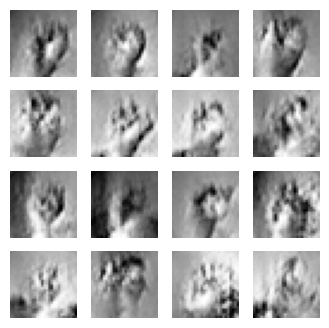

In [22]:
# Save the generator weights to a file
#generator.save_weights('/content/drive/MyDrive/DeepLearning/'+'generator_weights.h5')

# Load the generator weights from the file
generator.load_weights('/content/drive/MyDrive/DeepLearning/'+'generator_weights.h5')

# Save the discriminator weights to a file
#discriminator.save_weights('/content/drive/MyDrive/DeepLearning/'+'discriminator_weights.h5')

# Load the discriminator weights from the file
discriminator.load_weights('/content/drive/MyDrive/DeepLearning/'+'discriminator_weights.h5')

# Generate some fake images using the trained generator
noise = tf.random.normal([16, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i]*0.5 + 0.5).numpy(),cmap='gray')
    plt.axis('off')
plt.show()

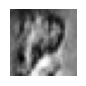

In [23]:
noise = tf.random.normal([1, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i]*0.5 + 0.5).numpy(),cmap='gray')
    plt.axis('off')
plt.show()

In [24]:
generated_images.shape

TensorShape([1, 28, 28, 1])

In [ ]:
os.makedirs('/content/drive/MyDrive/DeepLearning/test_img')

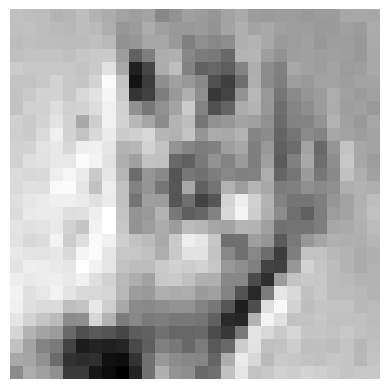

In [ ]:
output_path='/content/drive/MyDrive/DeepLearning/test_img/'
for i in range(0,100):
    noise = tf.random.normal([1, noise_dim])
    generated_images = generator(noise, training=False)
    generated_images = (0.5 * generated_images + 0.5).numpy()
    generated_images=generated_images.reshape(28,28,1).astype('float32')
    plt.imshow(generated_images,cmap='gray')
    plt.axis('off')
    plt.savefig(output_path+'{}'.format(i))

In [25]:
x_train = df.iloc[:, 1:].values
y_train = df['label'].values

x_train=x_train.reshape(x_train.shape[0],28,28,1).astype('float32')
x_train=(x_train-127.5)/127.5

In [26]:
n_class=25

model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape =(28,28,1) ),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(n_class, activation=tf.nn.softmax)
  ])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
callbacks = [
            EarlyStopping(patience = 5, verbose=1),
            ReduceLROnPlateau(monitor='val_accuracy',factor = 0.5, patience = 3, min_lr = 0.000001, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/DeepLearning/model_hd.h5', monitor='val_loss', save_best_only=True,
            verbose=1)

    ]

In [28]:
history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split = 0.2,callbacks=callbacks)

Epoch 1/5
172/172 [==============================] - ETA: 0s - loss: 1.2528 - accuracy: 0.6308
Epoch 1: val_loss improved from inf to 0.32909, saving model to /content/drive/MyDrive/DeepLearning/model_hd.h5
172/172 [==============================] - 7s 12ms/step - loss: 1.2528 - accuracy: 0.6308 - val_loss: 0.3291 - val_accuracy: 0.9020 - lr: 0.0010
Epoch 2/5
170/172 [============================>.] - ETA: 0s - loss: 0.1753 - accuracy: 0.9552
Epoch 2: val_loss improved from 0.32909 to 0.06826, saving model to /content/drive/MyDrive/DeepLearning/model_hd.h5
172/172 [==============================] - 1s 5ms/step - loss: 0.1745 - accuracy: 0.9554 - val_loss: 0.0683 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 3/5
164/172 [===========================>..] - ETA: 0s - loss: 0.0361 - accuracy: 0.9967
Epoch 3: val_loss improved from 0.06826 to 0.01842, saving model to /content/drive/MyDrive/DeepLearning/model_hd.h5
172/172 [==============================] - 1s 5ms/step - loss: 0.0353 - accuracy: 

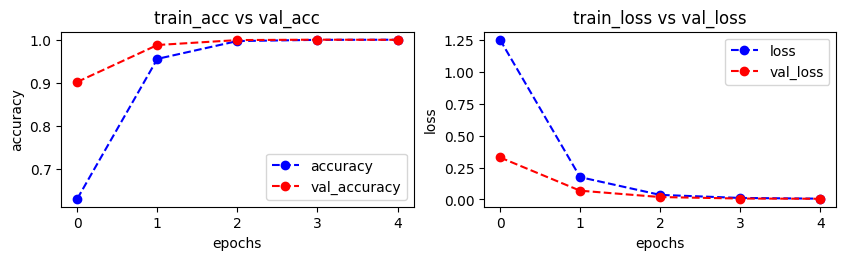

In [29]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

In [30]:
file_test_path = '/content/sign_mnist_test.csv'

tdf = pd.read_csv(file_test_path)

x_test = tdf.iloc[:, 1:].values
y_test = tdf['label'].values

images_test=x_test.reshape(x_test.shape[0],28,28,1).astype('float32')
images_test=(images_test-127.5)/127.5

In [31]:
test_loss, test_acc = model.evaluate(images_test, y_test)

225/225 [==============================] - 1s 3ms/step - loss: 0.4038 - accuracy: 0.9076


In [32]:
predictions = model.predict(images_test)
pred_labels = np.argmax(predictions, axis = 1)

225/225 [==============================] - 0s 2ms/step


In [33]:
pred_df = pd.DataFrame()
pred_df['predictions'] = pred_labels
pred_df['real'] = y_test
pred_df.head()

,predictions,real
0,6,6
1,5,5
2,10,10
3,0,0
4,3,3


In [34]:
gen_img='/content/drive/MyDrive/DeepLearning/test_img'

In [35]:
images = []
for filename in os.listdir(gen_img):
  img = tf.io.read_file(gen_img + "/" + filename)
  img = tf.image.decode_image(img, channels=1)
  img = tf.image.resize(img, (28, 28))
  img = tf.cast(img, tf.float32)
  img = (img - 127.5) / 127.5
  images.append(img)


In [36]:
images = np.array(images, dtype = 'float32')

In [37]:
images.shape

(100, 28, 28, 1)

In [38]:
predictions = model.predict(images)
pred_labels = np.argmax(predictions, axis = 1)

4/4 [==============================] - 0s 4ms/step


In [40]:
pred_labels[0:100]

array([14, 10,  8, 14,  8, 15, 14,  5,  8, 15, 14, 18,  8,  8, 14, 15,  1,
       14,  6, 23, 14,  8,  8, 14,  6,  2, 14, 14,  8, 14,  8, 14, 14, 14,
        1, 14,  8, 14,  8, 16, 14, 14,  8,  6, 15, 14, 14,  6,  7,  8, 19,
       16, 15,  1, 15, 10, 14, 10, 14,  6, 14,  8,  8, 10, 14,  8, 14, 19,
       15,  8, 14,  8, 14, 14, 23, 10, 14, 15,  8,  8, 14,  6,  8, 23,  6,
        8,  5, 14, 14,  8, 23,  8,  8,  5, 14, 14, 14,  8, 14, 15])

In [104]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [110]:
# prompt: how to preprosses image in x_train for ResNet50 model
x_train = df.iloc[:, 1:].values
y_train = df['label'].values
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],28,28).astype('float32')

In [111]:
x_train.shape

(27455, 28, 28)

In [112]:

# expand new axis, channel axis
x_train = np.expand_dims(x_train, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
x_train = np.repeat(x_train, 3, axis=-1)

# it's always better to normalize
x_train = x_train.astype('float32') / 255

# resize the input shape , i.e. old shape: 28, new shape: 32
x_train = tf.image.resize(x_train, [32,32]) # if we want to resize

# one hot
y_train = tf.keras.utils.to_categorical(y_train , num_classes=n_class)

print(x_train.shape, y_train.shape)

(27455, 32, 32, 3) (27455, 25)


In [47]:
x_test = tdf.iloc[:, 1:].values
y_test = tdf['label'].values
x_test = np.array(x_test)
y_train = np.array(y_train)
x_test=x_test.reshape(x_test.shape[0],28,28).astype('float32')

# expand new axis, channel axis
x_test = np.expand_dims(x_test, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
x_test = np.repeat(x_test, 3, axis=-1)

# it's always better to normalize
x_test = x_test.astype('float32') / 255

# resize the input shape , i.e. old shape: 28, new shape: 32
x_test = tf.image.resize(x_test, [32,32]) # if we want to resize

# one hot
y_test = tf.keras.utils.to_categorical(y_test , num_classes=n_class)

print(x_test.shape, y_test.shape)

(7172, 32, 32, 3) (7172, 25)


In [44]:
input = tf.keras.Input(shape=(32,32,3))
efnet = ResNet50(weights='imagenet',include_top = False,input_tensor = input)
# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

# Finally, we add a classification layer.
output = Dense(n_class, activation='softmax', use_bias=True)(gap)

# bind all
modelres = tf.keras.Model(efnet.input, output)

94765736/94765736 [==============================] - 1s 0us/step


In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
callbacks = [
            EarlyStopping(patience = 5, verbose=1),
            ReduceLROnPlateau(monitor='val_accuracy',factor = 0.5, patience = 3, min_lr = 0.000001, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/DeepLearning/modelResNet_hd.h5', monitor='val_loss', save_best_only=True,
            verbose=1)

    ]

In [46]:
modelres.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())
# fit
history = modelres.fit(x_train, y_train, batch_size=128, epochs=5, validation_split = 0.2,callbacks=callbacks)

Epoch 1/5
172/172 [==============================] - ETA: 0s - loss: 0.4839 - categorical_accuracy: 0.8840


Epoch 1: val_loss improved from inf to 3.65553, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 57s 123ms/step - loss: 0.4839 - categorical_accuracy: 0.8840 - val_loss: 3.6555 - val_categorical_accuracy: 0.0410 - lr: 0.0010
Epoch 2/5
172/172 [==============================] - ETA: 0s - loss: 0.1774 - categorical_accuracy: 0.9664


Epoch 2: val_loss improved from 3.65553 to 3.41535, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 18s 104ms/step - loss: 0.1774 - categorical_accuracy: 0.9664 - val_loss: 3.4153 - val_categorical_accuracy: 0.0432 - lr: 0.0010
Epoch 3/5
172/172 [==============================] - ETA: 0s - loss: 0.1416 - categorical_accuracy: 0.9749


Epoch 3: val_loss did not improve from 3.41535
172/172 [==============================] - 13s 76ms/step - loss: 0.1416 - categorical_accuracy: 0.9749 - val_loss: 4.8698 - val_categorical_accuracy: 0.0419 - lr: 0.0010
Epoch 4/5
172/172 [==============================] - ETA: 0s - loss: 0.0851 - categorical_accuracy: 0.9890


Epoch 4: val_loss did not improve from 3.41535
172/172 [==============================] - 12s 71ms/step - loss: 0.0851 - categorical_accuracy: 0.9890 - val_loss: 3.9656 - val_categorical_accuracy: 0.1014 - lr: 0.0010
Epoch 5/5
172/172 [==============================] - ETA: 0s - loss: 0.1170 - categorical_accuracy: 0.9799


Epoch 5: val_loss did not improve from 3.41535
172/172 [==============================] - 13s 75ms/step - loss: 0.1170 - categorical_accuracy: 0.9799 - val_loss: 194.2487 - val_categorical_accuracy: 0.1448 - lr: 0.0010


In [50]:
test_loss_res, test_acc_res = modelres.evaluate(x_test, y_test)

225/225 [==============================] - 3s 14ms/step - loss: 105.8944 - categorical_accuracy: 0.1333


In [51]:
losses=[]
acc=[]
losses.append(test_loss_res)
acc.append(test_acc_res)

In [64]:
MobileNet= MobileNetV2(include_top=False,input_shape=(32,32,3),pooling
='avg',classes=2,weights='imagenet')
for layer in MobileNet.layers:
 layer.trainable=False
model_MobileNetF = Sequential()
model_MobileNetF.add(MobileNet)
model_MobileNetF.add(Flatten())
model_MobileNetF.add(Dense(512, activation='relu'))
model_MobileNetF.add(Dense(n_class, activation='softmax'))
model_MobileNetF.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               655872    
                                                                 
 dense_8 (Dense)             (None, 25)                12825     
                                                                 
Total params: 2926681 (11.16 MB)
Trainable params: 668697 (2.55 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [65]:
callbacks = [
            EarlyStopping(patience = 5, verbose=1),
            ReduceLROnPlateau(monitor='val_accuracy',factor = 0.5, patience = 3, min_lr = 0.000001, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/DeepLearning/modelResNet_hd.h5', monitor='val_loss', save_best_only=True,
            verbose=1)

    ]

In [66]:
model_MobileNetF.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())
# fit
history = model_MobileNetF.fit(x_train, y_train, batch_size=128, epochs=5, validation_split = 0.2,callbacks=callbacks)

Epoch 1/5
172/172 [==============================] - ETA: 0s - loss: 2.3292 - categorical_accuracy: 0.3372


Epoch 1: val_loss improved from inf to 1.85292, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 15s 65ms/step - loss: 2.3292 - categorical_accuracy: 0.3372 - val_loss: 1.8529 - val_categorical_accuracy: 0.4422 - lr: 0.0010
Epoch 2/5
167/172 [============================>.] - ETA: 0s - loss: 1.6839 - categorical_accuracy: 0.4895


Epoch 2: val_loss improved from 1.85292 to 1.57007, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 3s 16ms/step - loss: 1.6814 - categorical_accuracy: 0.4910 - val_loss: 1.5701 - val_categorical_accuracy: 0.5192 - lr: 0.0010
Epoch 3/5
167/172 [============================>.] - ETA: 0s - loss: 1.4643 - categorical_accuracy: 0.5553


Epoch 3: val_loss improved from 1.57007 to 1.41642, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 3s 16ms/step - loss: 1.4630 - categorical_accuracy: 0.5559 - val_loss: 1.4164 - val_categorical_accuracy: 0.5607 - lr: 0.0010
Epoch 4/5
168/172 [============================>.] - ETA: 0s - loss: 1.3216 - categorical_accuracy: 0.5964


Epoch 4: val_loss improved from 1.41642 to 1.29652, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 3s 15ms/step - loss: 1.3210 - categorical_accuracy: 0.5961 - val_loss: 1.2965 - val_categorical_accuracy: 0.5952 - lr: 0.0010
Epoch 5/5
168/172 [============================>.] - ETA: 0s - loss: 1.2073 - categorical_accuracy: 0.6301


Epoch 5: val_loss improved from 1.29652 to 1.19216, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 3s 18ms/step - loss: 1.2077 - categorical_accuracy: 0.6303 - val_loss: 1.1922 - val_categorical_accuracy: 0.6370 - lr: 0.0010


In [68]:
test_loss_res, test_acc_res = model_MobileNetF.evaluate(x_test, y_test)

225/225 [==============================] - 3s 11ms/step - loss: 1.8384 - categorical_accuracy: 0.4449


In [69]:
losses.append(test_loss_res)
acc.append(test_acc_res)

In [82]:
losses

[1.8384255170822144, 105.89435577392578]

In [96]:
MobileNet0= MobileNet(include_top=False,input_shape=(32,32,3),pooling
='avg',classes=2,weights='imagenet')
for layer in MobileNet0.layers:
 layer.trainable=False
model_MobileNet0 = Sequential()
model_MobileNet0.add(MobileNet0)
model_MobileNet0.add(Flatten())
model_MobileNet0.add(Dense(512, activation='relu'))
model_MobileNet0.add(Dense(n_class, activation='softmax'))
model_MobileNet0.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1024)              3228864   
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dense_10 (Dense)            (None, 25)                12825     
                                                                 
Total params: 3766489 (14.37 MB)
Trainable params: 537625 (2.05 MB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [97]:
callbacks = [
            EarlyStopping(patience = 5, verbose=1),
            ReduceLROnPlateau(monitor='val_accuracy',factor = 0.5, patience = 3, min_lr = 0.000001, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/DeepLearning/modelResNet_hd.h5', monitor='val_loss', save_best_only=True,
            verbose=1)

    ]

In [99]:
model_MobileNet0.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())
# fit
history = model_MobileNet0.fit(x_train, y_train, batch_size=128, epochs=5, validation_split = 0.2,callbacks=callbacks)

Epoch 1/5
172/172 [==============================] - ETA: 0s - loss: 2.8206 - categorical_accuracy: 0.1646


Epoch 1: val_loss did not improve from 0.87377
172/172 [==============================] - 7s 23ms/step - loss: 2.8206 - categorical_accuracy: 0.1646 - val_loss: 2.5565 - val_categorical_accuracy: 0.2225 - lr: 0.0010
Epoch 2/5
170/172 [============================>.] - ETA: 0s - loss: 2.4592 - categorical_accuracy: 0.2357


Epoch 2: val_loss did not improve from 0.87377
172/172 [==============================] - 2s 11ms/step - loss: 2.4589 - categorical_accuracy: 0.2356 - val_loss: 2.3952 - val_categorical_accuracy: 0.2522 - lr: 0.0010
Epoch 3/5
172/172 [==============================] - ETA: 0s - loss: 2.3442 - categorical_accuracy: 0.2621


Epoch 3: val_loss did not improve from 0.87377
172/172 [==============================] - 2s 10ms/step - loss: 2.3442 - categorical_accuracy: 0.2621 - val_loss: 2.2992 - val_categorical_accuracy: 0.2799 - lr: 0.0010
Epoch 4/5
168/172 [============================>.] - ETA: 0s - loss: 2.2699 - categorical_accuracy: 0.2819


Epoch 4: val_loss did not improve from 0.87377
172/172 [==============================] - 2s 10ms/step - loss: 2.2690 - categorical_accuracy: 0.2826 - val_loss: 2.2462 - val_categorical_accuracy: 0.2912 - lr: 0.0010
Epoch 5/5
171/172 [============================>.] - ETA: 0s - loss: 2.2144 - categorical_accuracy: 0.2912


Epoch 5: val_loss did not improve from 0.87377
172/172 [==============================] - 2s 10ms/step - loss: 2.2148 - categorical_accuracy: 0.2910 - val_loss: 2.2049 - val_categorical_accuracy: 0.3074 - lr: 0.0010


In [100]:
test_loss_res, test_acc_res = model_MobileNet0.evaluate(x_test, y_test)

225/225 [==============================] - 2s 6ms/step - loss: 2.4817 - categorical_accuracy: 0.2441


In [101]:
losses.append(test_loss_res)
acc.append(test_acc_res)

In [113]:
# prompt: how to preprosses image in x_train for ResNet50 model
x_train = df.iloc[:, 1:].values
y_train = df['label'].values
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],28,28).astype('float32')

x_train = np.expand_dims(x_train, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
x_train = np.repeat(x_train, 3, axis=-1)

# it's always better to normalize
x_train = x_train.astype('float32') / 255

# resize the input shape , i.e. old shape: 28, new shape: 32
x_train = tf.image.resize(x_train, [75,75]) # if we want to resize

# one hot
y_train = tf.keras.utils.to_categorical(y_train , num_classes=n_class)

print(x_train.shape, y_train.shape)

(27455, 75, 75, 3) (27455, 25)


In [115]:
InceptionV3= InceptionV3(include_top=False,input_shape=(75,75,3),pooling
='avg',classes=2,weights='imagenet')
for layer in InceptionV3.layers:
 layer.trainable=False
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3)
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(512, activation='relu'))
model_InceptionV3.add(Dense(n_class, activation='softmax'))
model_InceptionV3.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               1049088   
                                                                 
 dense_12 (Dense)            (None, 25)                12825     
                                                                 
Total params: 22864697 (87.22 MB)
Trainable params: 1061913 (4.05 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [116]:
callbacks = [
            EarlyStopping(patience = 5, verbose=1),
            ReduceLROnPlateau(monitor='val_accuracy',factor = 0.5, patience = 3, min_lr = 0.000001, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/DeepLearning/modelResNet_hd.h5', monitor='val_loss', save_best_only=True,
            verbose=1)

    ]

In [117]:
model_InceptionV3.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())
# fit
history = model_InceptionV3.fit(x_train, y_train, batch_size=128, epochs=5, validation_split = 0.2,callbacks=callbacks)

Epoch 1/5
172/172 [==============================] - ETA: 0s - loss: 0.3539 - categorical_accuracy: 0.9172


Epoch 1: val_loss improved from inf to 0.04668, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 23s 82ms/step - loss: 0.3539 - categorical_accuracy: 0.9172 - val_loss: 0.0467 - val_categorical_accuracy: 0.9927 - lr: 0.0010
Epoch 2/5
171/172 [============================>.] - ETA: 0s - loss: 0.0211 - categorical_accuracy: 0.9979


Epoch 2: val_loss improved from 0.04668 to 0.02347, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 8s 47ms/step - loss: 0.0211 - categorical_accuracy: 0.9979 - val_loss: 0.0235 - val_categorical_accuracy: 0.9953 - lr: 0.0010
Epoch 3/5
171/172 [============================>.] - ETA: 0s - loss: 0.0073 - categorical_accuracy: 0.9999


Epoch 3: val_loss improved from 0.02347 to 0.01791, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 10s 61ms/step - loss: 0.0073 - categorical_accuracy: 0.9999 - val_loss: 0.0179 - val_categorical_accuracy: 0.9956 - lr: 0.0010
Epoch 4/5
171/172 [============================>.] - ETA: 0s - loss: 0.0034 - categorical_accuracy: 1.0000


Epoch 4: val_loss improved from 0.01791 to 0.01380, saving model to /content/drive/MyDrive/DeepLearning/modelResNet_hd.h5
172/172 [==============================] - 9s 53ms/step - loss: 0.0034 - categorical_accuracy: 1.0000 - val_loss: 0.0138 - val_categorical_accuracy: 0.9960 - lr: 0.0010
Epoch 5/5
172/172 [==============================] - ETA: 0s - loss: 0.0020 - categorical_accuracy: 1.0000


Epoch 5: val_loss did not improve from 0.01380
172/172 [==============================] - 7s 40ms/step - loss: 0.0020 - categorical_accuracy: 1.0000 - val_loss: 0.0138 - val_categorical_accuracy: 0.9962 - lr: 0.0010


In [121]:
test_loss_res, test_acc_res = model_InceptionV3.evaluate(x_test, y_test)

225/225 [==============================] - 6s 12ms/step - loss: nan - categorical_accuracy: 0.0462


In [122]:
losses.append(test_loss_res)
acc.append(test_acc_res)

In [123]:
model_df = pd.DataFrame()
model_df['losses'] = losses
model_df['acc'] = acc
model_df.head()

,losses,acc
0,1.838426,0.133296
1,105.894356,0.444925
2,2.481747,0.244144
3,2.481747,0.244144
4,NaN,0.046152


In [87]:

images = np.array(images)
images=images.reshape(images.shape[0],28,28).astype('float32')

# expand new axis, channel axis
images = np.expand_dims(images, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
images = np.repeat(images, 3, axis=-1)

# it's always better to normalize
images = images.astype('float32') / 255

# resize the input shape , i.e. old shape: 28, new shape: 32
images = tf.image.resize(images, [32,32]) # if we want to resize



print(images.shape)

(100, 32, 32, 3)


In [89]:
predictions = model_MobileNetF.predict(images)
pred_labels = np.argmax(predictions, axis = 1)

4/4 [==============================] - 2s 10ms/step


In [90]:
pred_labels[0:100]

array([15, 23,  8,  8,  8,  8,  8,  8,  8, 23,  8,  8,  8,  8, 15,  8,  8,
       15,  8,  8,  8,  8,  8,  8, 23,  8,  8,  8, 15,  8, 23,  8,  8,  8,
        8, 23,  8,  8,  8, 23,  8,  8,  8,  8,  8,  8, 23,  8,  8,  8,  8,
        8,  8,  8, 15,  8,  8,  8, 23,  8,  8, 23,  8,  8,  8, 23,  8, 23,
        8,  8,  8,  8,  8,  8,  8,  8, 15,  8,  8,  8, 23,  8, 15,  8,  8,
        8,  8, 15,  8,  8,  8, 15,  8,  8,  8,  8,  8, 23,  8,  8])